RSA   2   1   764.7000002179993   2425.799999400624
0  RSA   2   2          135.300001         1609.300001
1  RSA   2   3          123.400001          903.800001
2  RSA   2   4           90.599999          895.800000
3  RSA   2   5          128.000001         1214.000000
4  RSA   2   6          161.600001         1209.500000

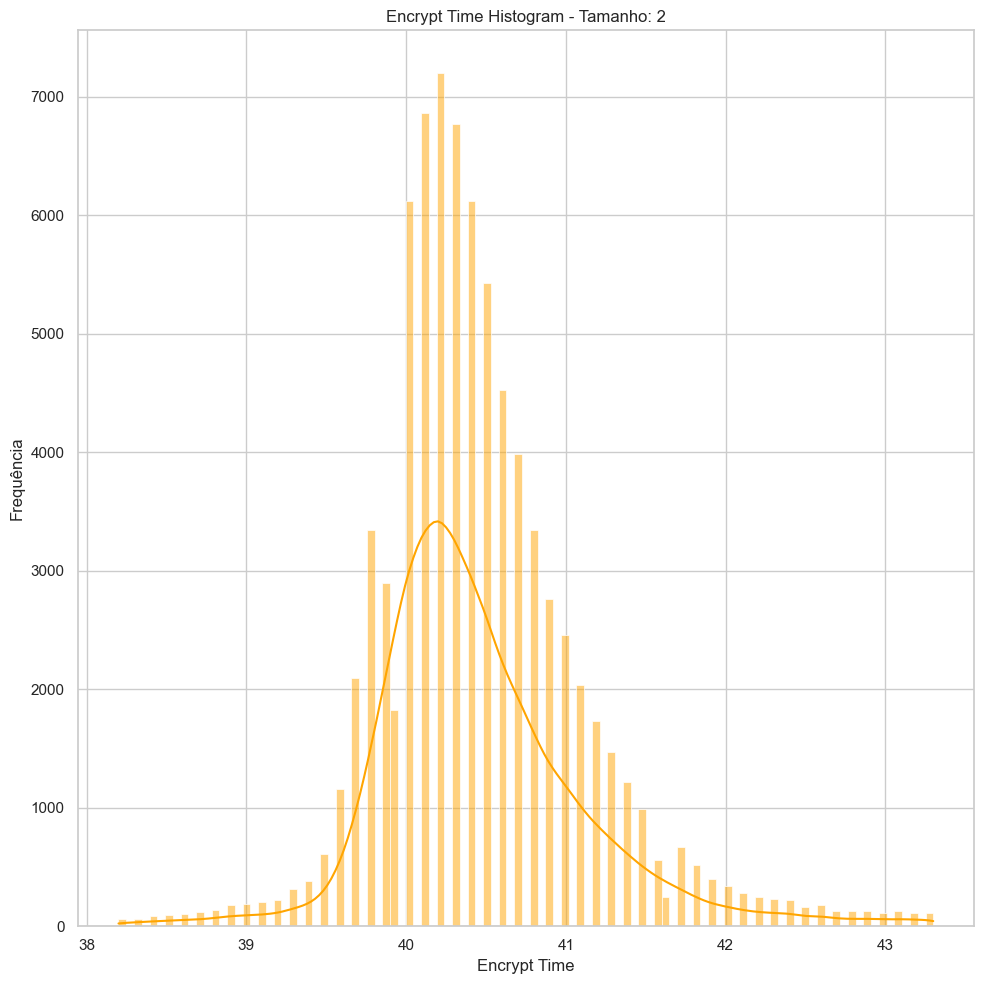

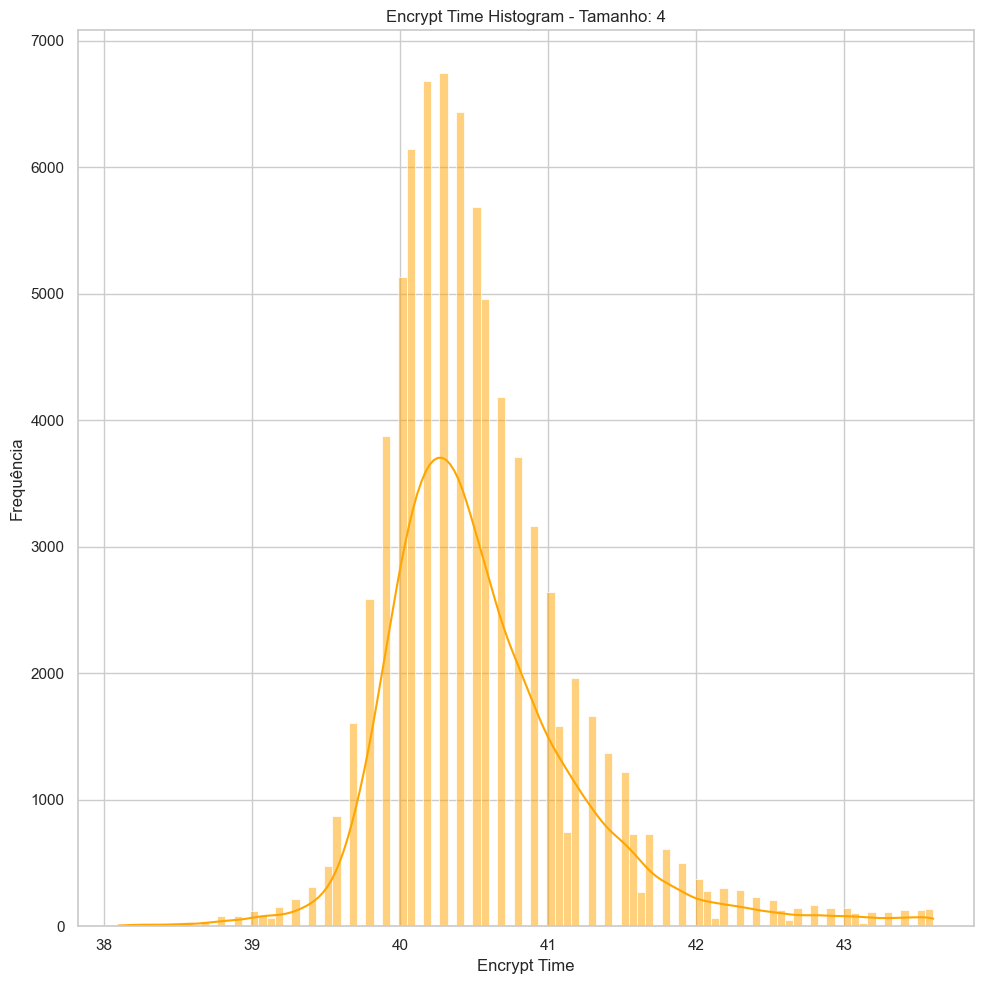

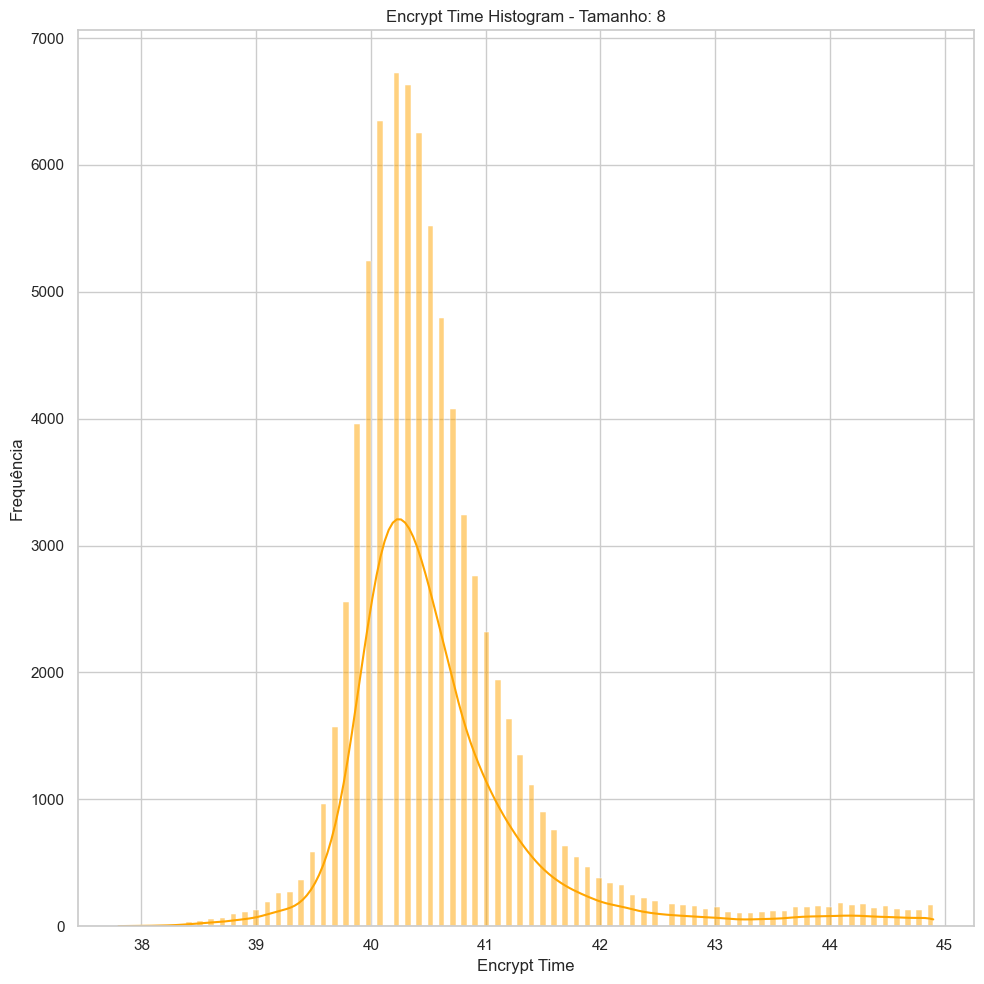

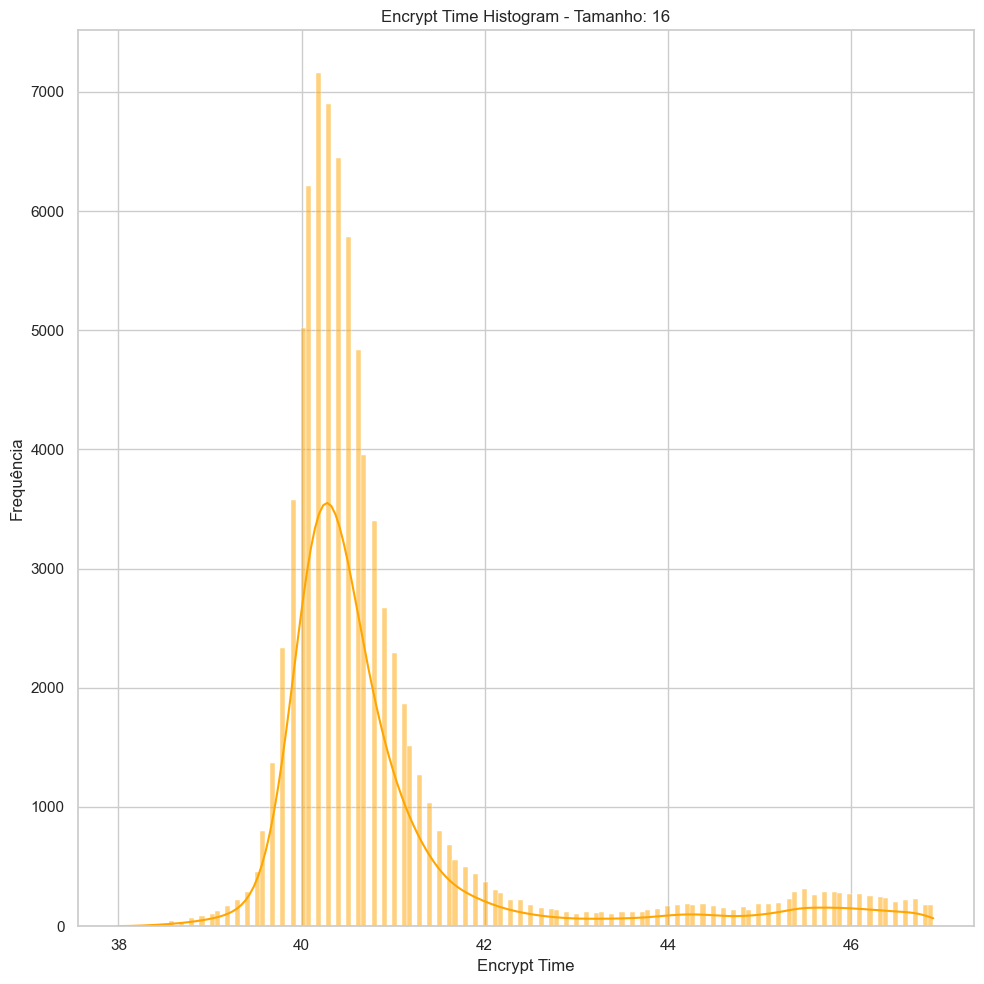

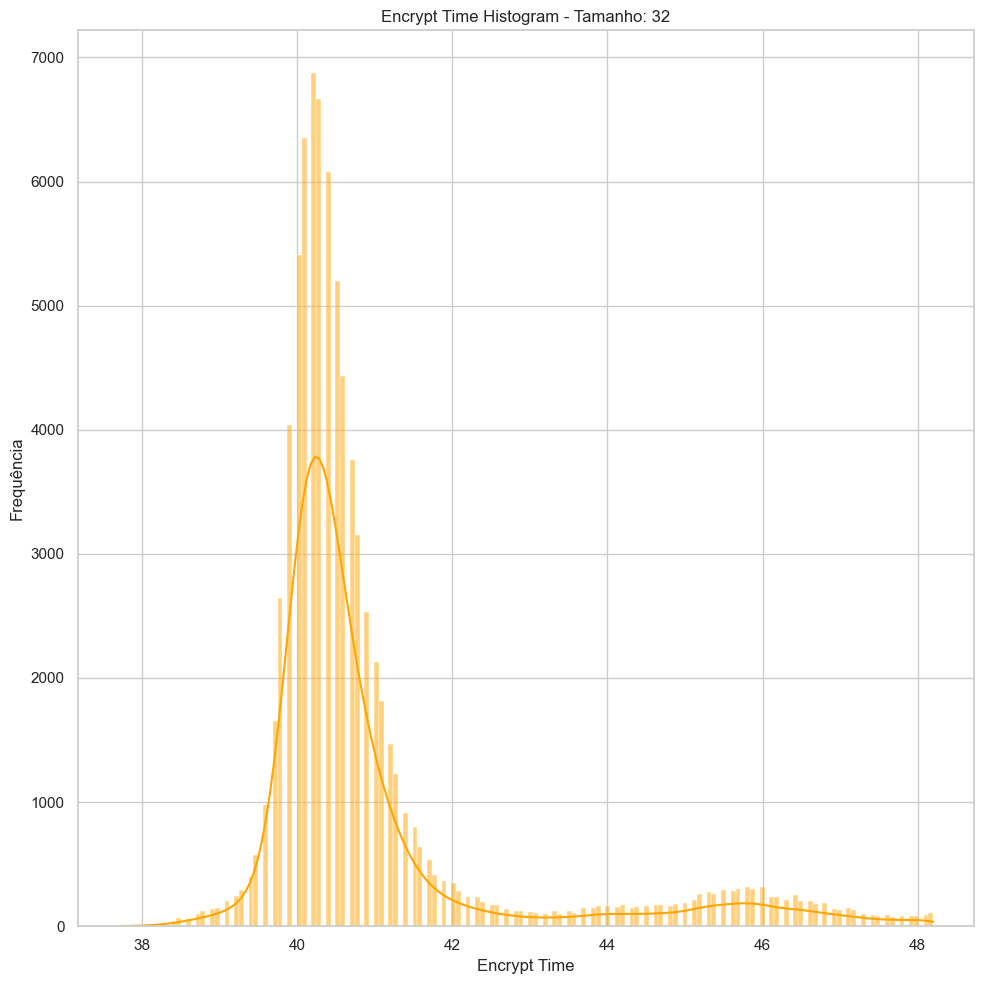

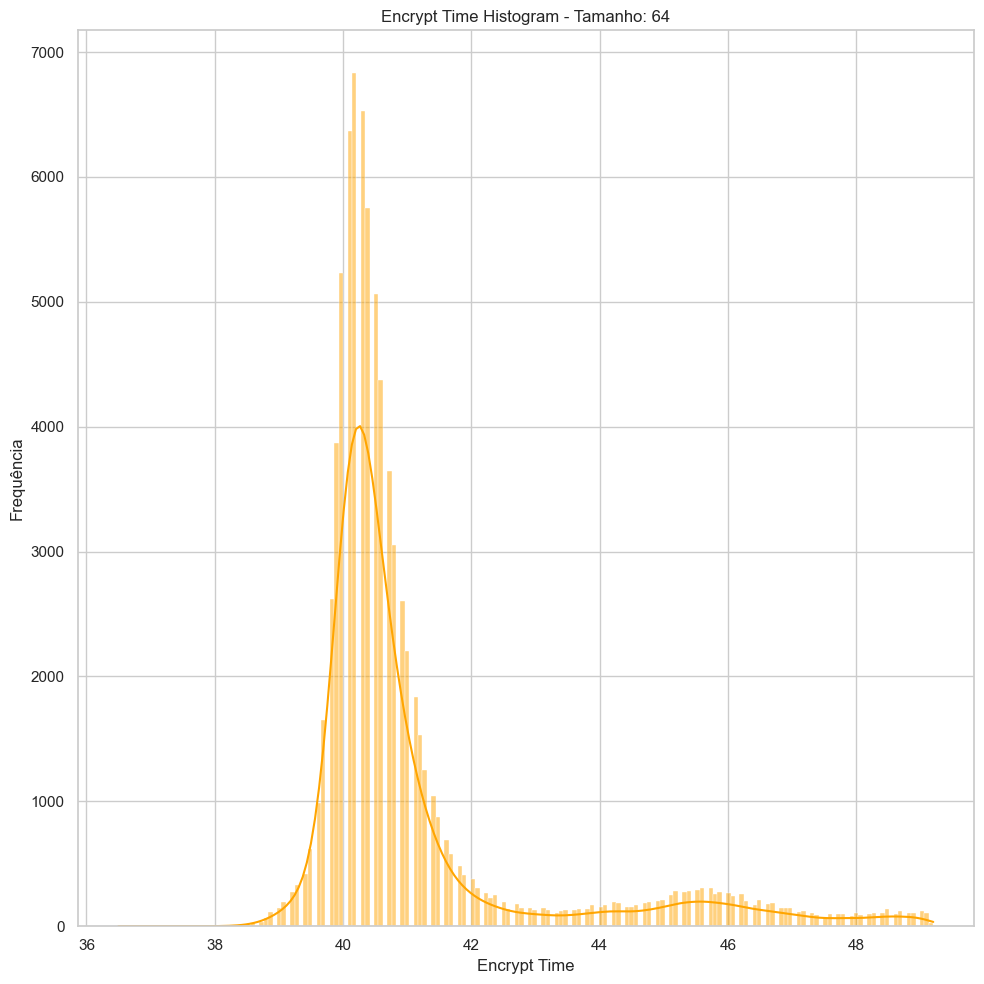

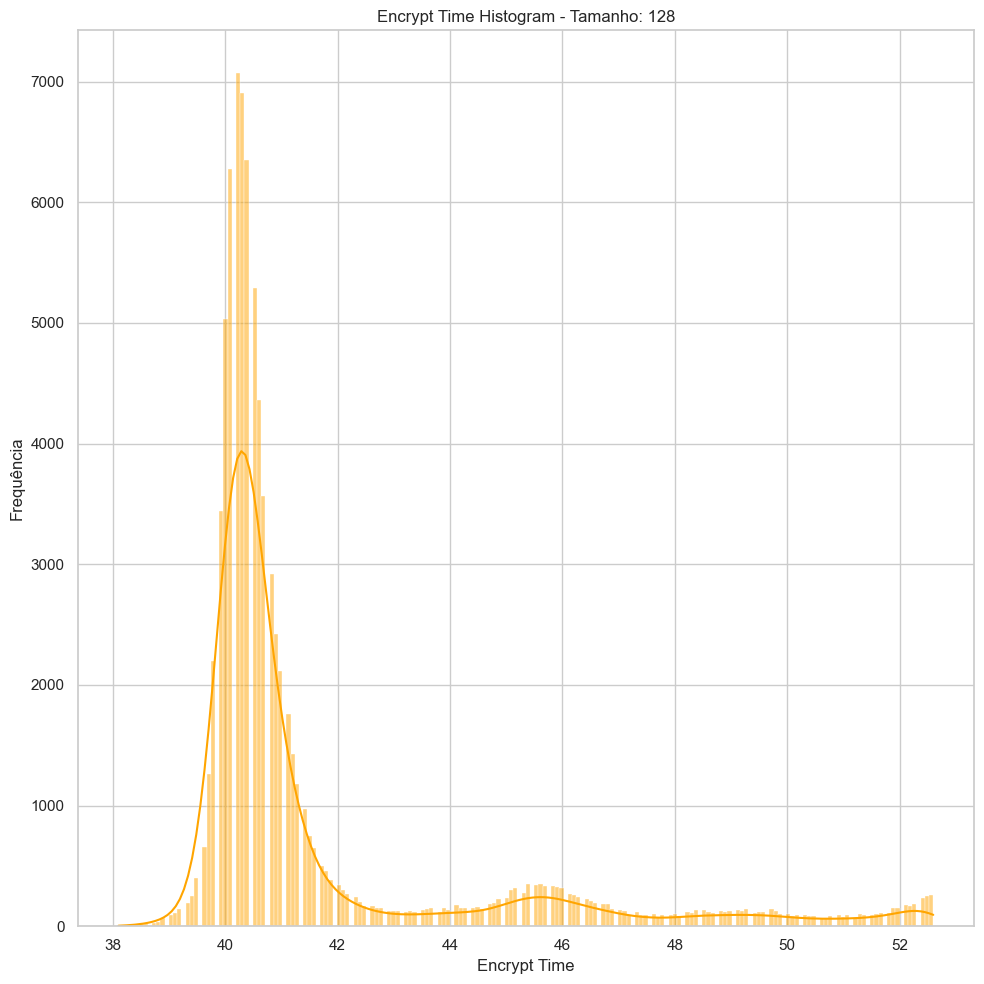

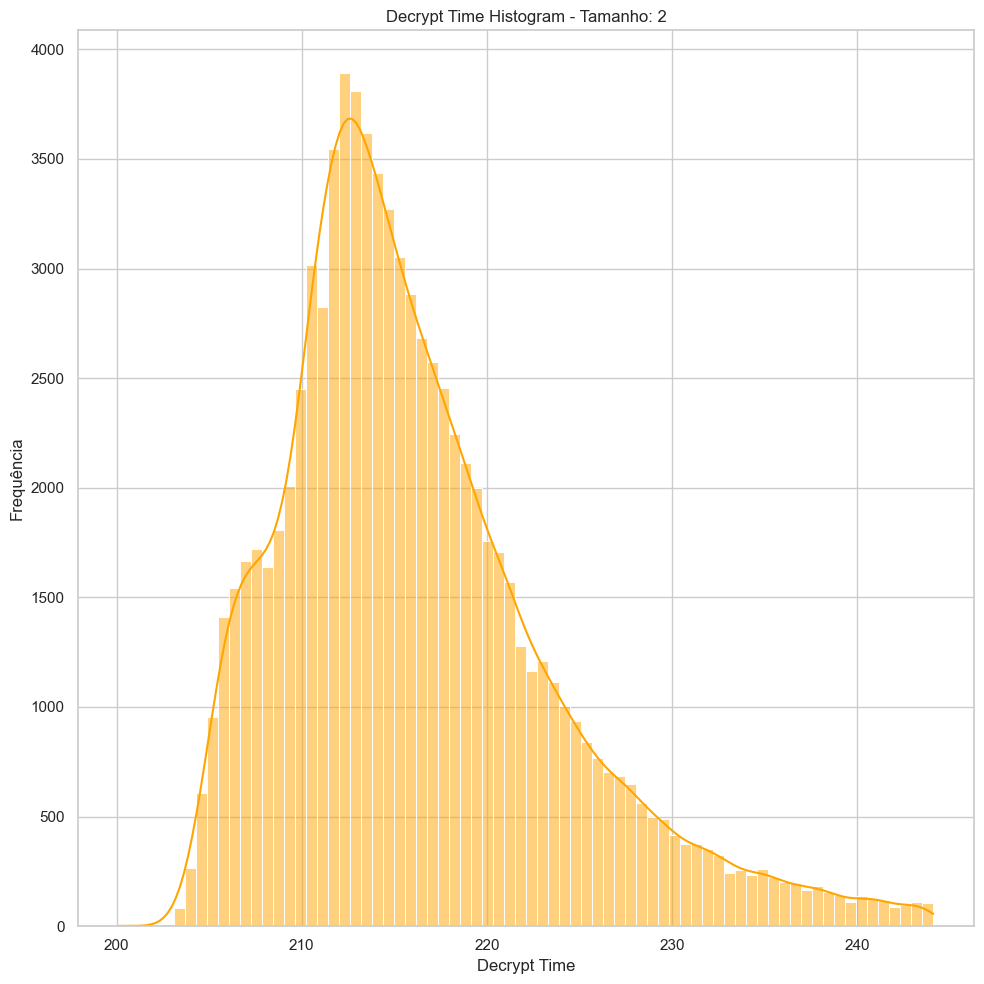

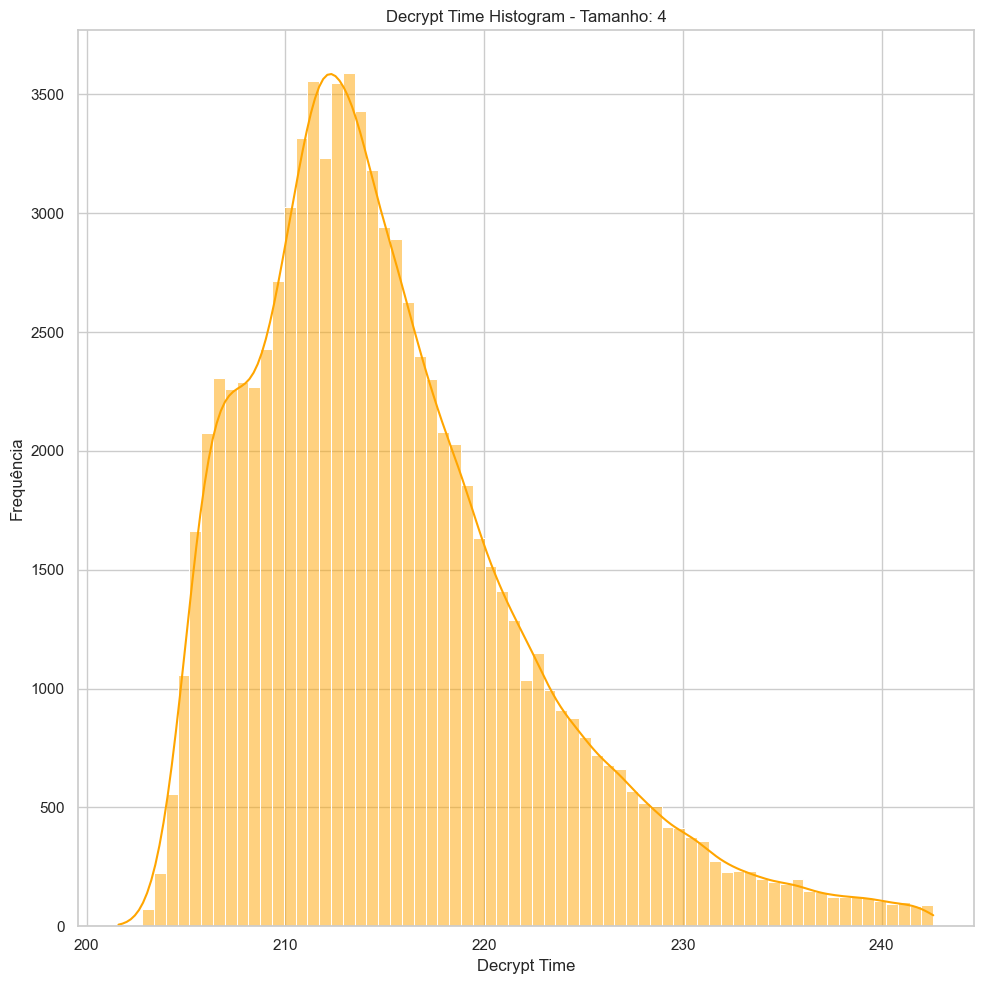

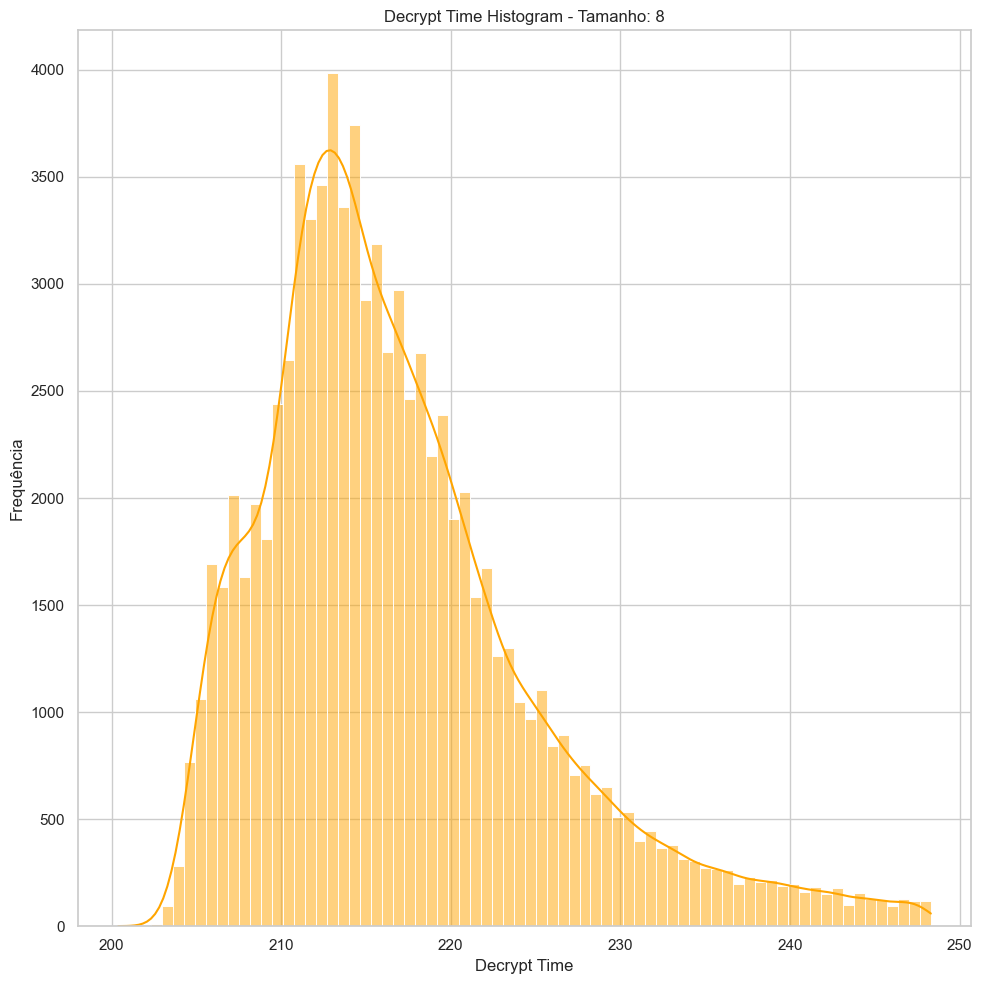

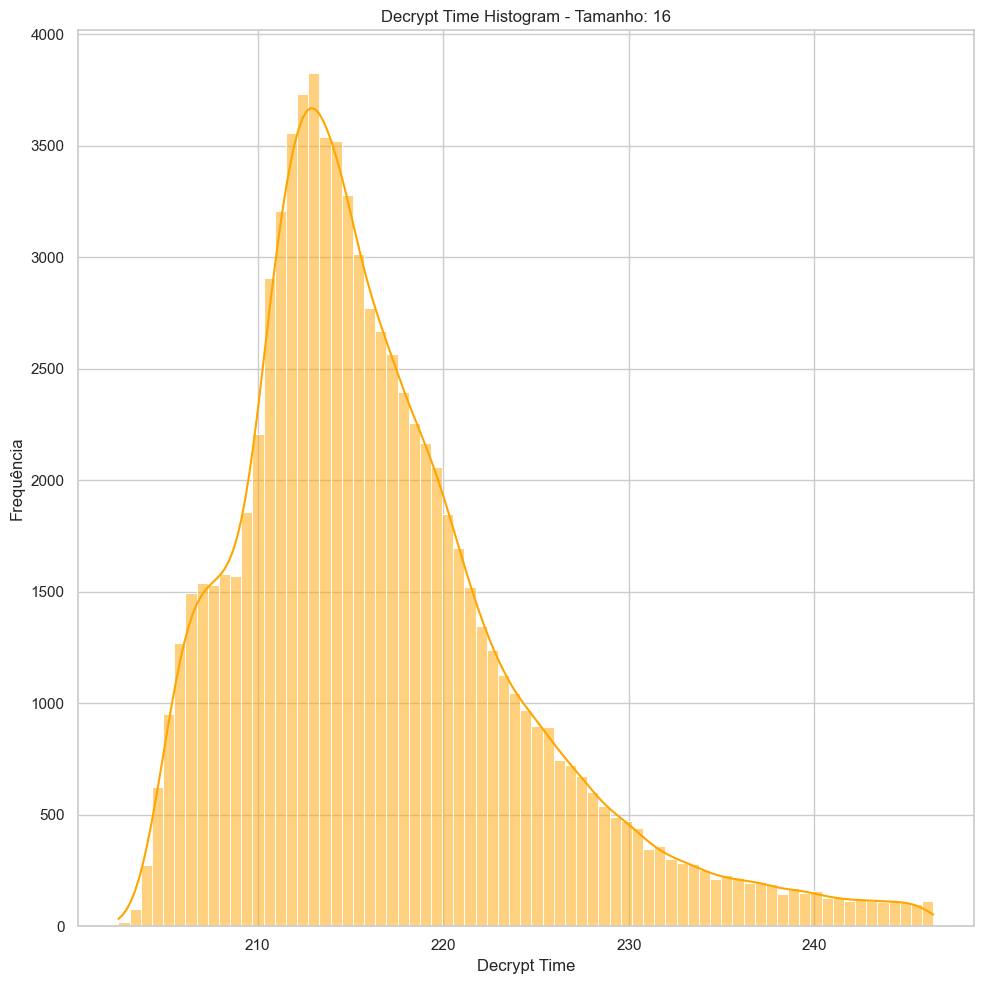

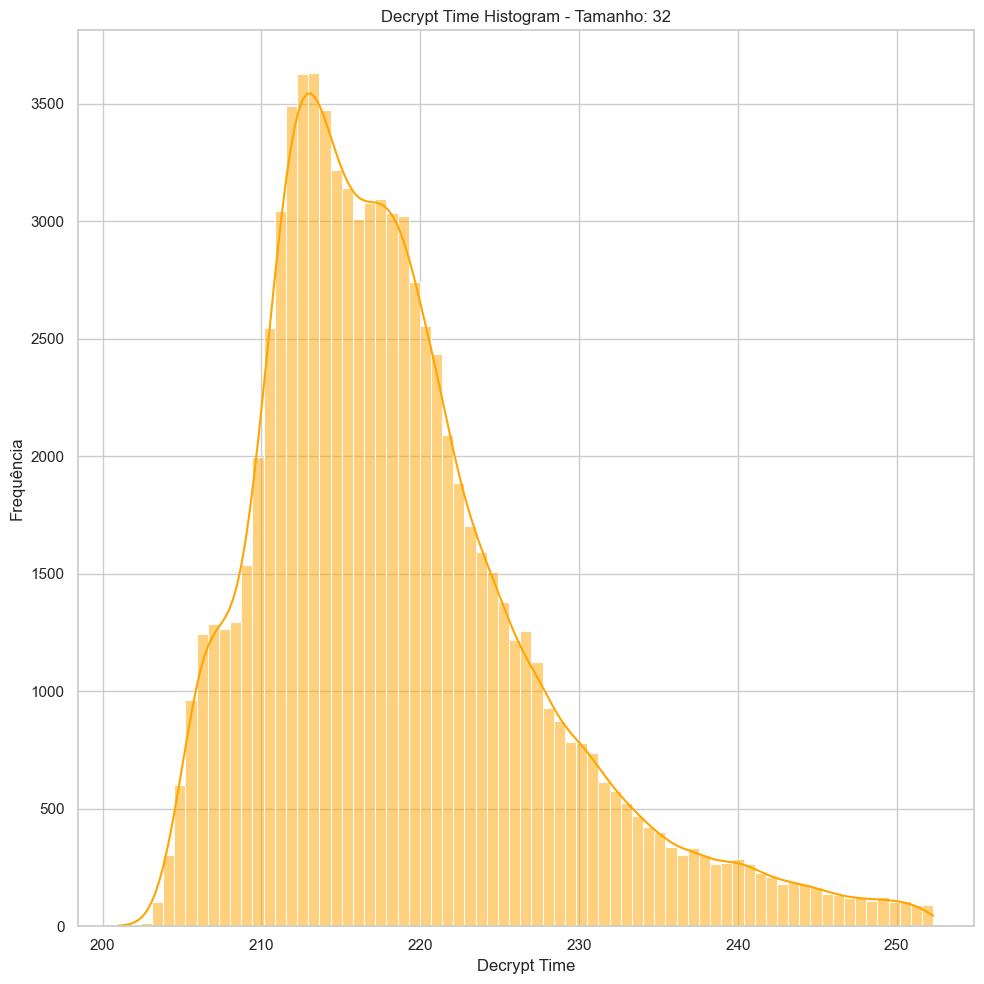

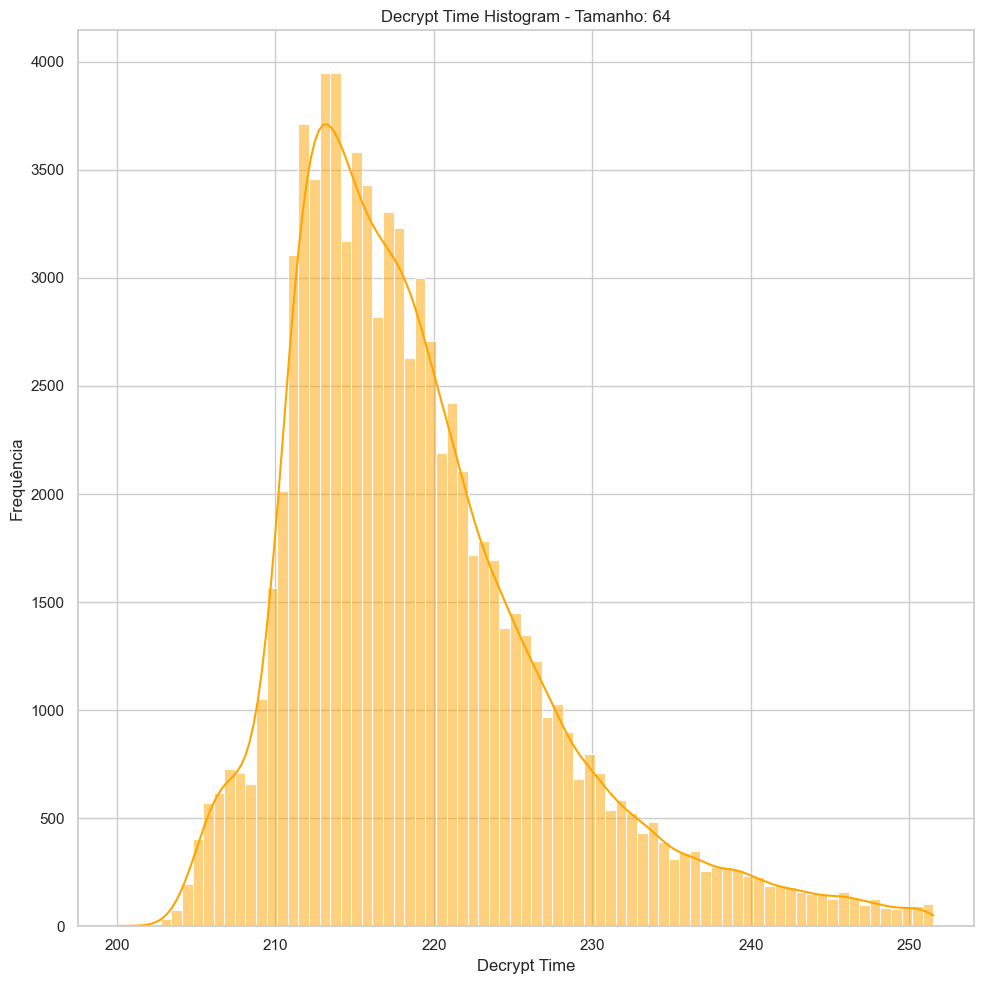

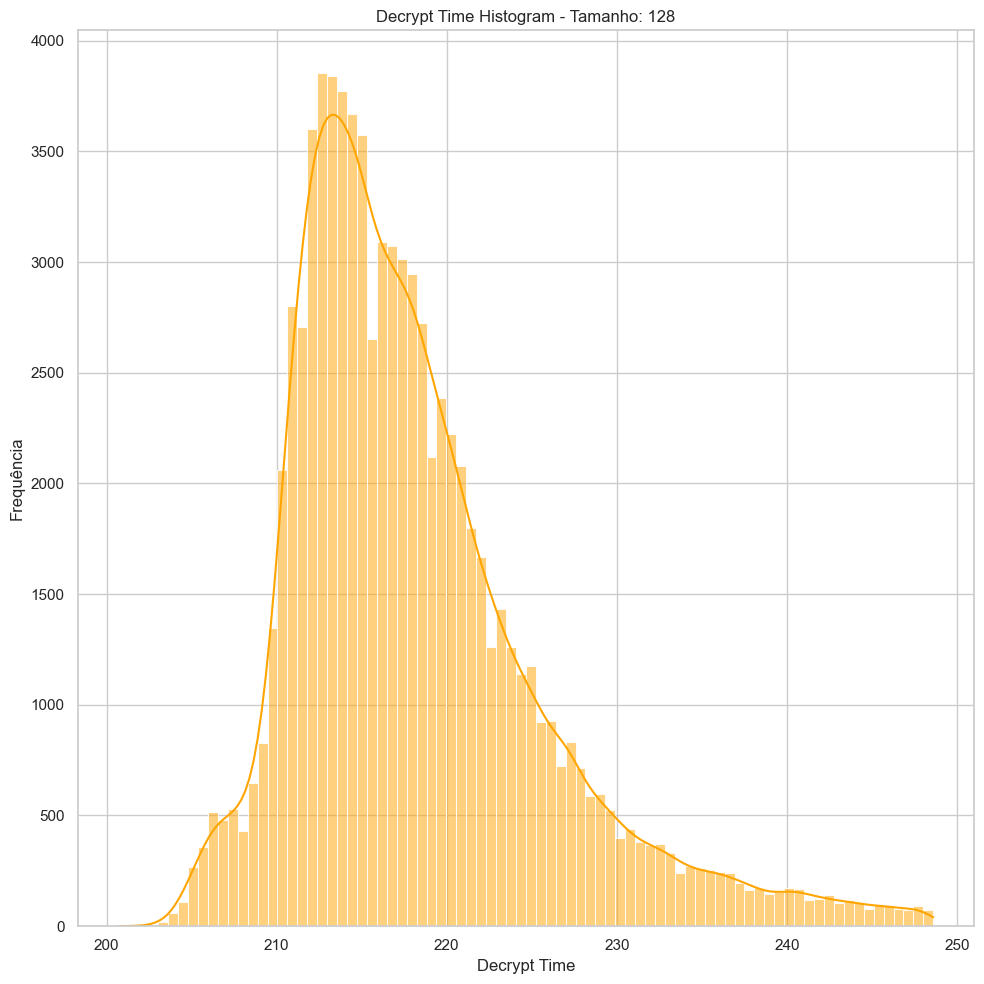

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import iqr

# Lê o ficheiro CSV
df = pd.read_csv('rsa_s.csv')

# Remove linhas com valores nulos nas colunas necessárias
df = df.dropna(subset=['tempo_incrypt', 'tempo_decrypt', 'tamanho'])

# Função para remover outliers usando o método IQR
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr_value = q3 - q1
    lower = q1 - 1.5 * iqr_value
    upper = q3 + 1.5 * iqr_value
    return data[(data >= lower) & (data <= upper)]

# Estilo do gráfico
sns.set(style='whitegrid')

# Loop por cada tamanho de ficheiro único para tempo_incrypt
for tamanho_valor in df['tamanho'].unique():
    subset = df[df['tamanho'] == tamanho_valor]['tempo_incrypt']
    subset_clean = remove_outliers(subset)


    # Escolher o número ideal de bins com base na regra de Freedman-Diaconis
    bin_width = 2 * iqr(subset_clean) / (len(subset_clean) ** (1/3))
    bin_width *= 1.5  # Aumenta a largura dos bins em 50%
    if bin_width == 0:
        continue  # Evita erro se IQR for 0
    bins = int((subset_clean.max() - subset_clean.min()) / bin_width)

    # Plot do histograma
    plt.figure(figsize=(10,10))
    sns.histplot(subset_clean, bins=bins, kde=True, color='orange')
    plt.title(f'Encrypt Time Histogram - Tamanho: {tamanho_valor}')
    plt.xlabel('Encrypt Time')
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

# Loop por cada tamanho de ficheiro único para tempo_decrypt
for tamanho_valor in df['tamanho'].unique():
    subset = df[df['tamanho'] == tamanho_valor]['tempo_decrypt']
    subset_clean = remove_outliers(subset)

    if len(subset_clean) < 50:
        continue  # Ignora se menos de 50 amostras após remover outliers

    # Escolher o número ideal de bins com base na regra de Freedman-Diaconis
    bin_width = 2 * iqr(subset_clean) / (len(subset_clean) ** (1/3))
    bin_width *= 1.5  # Aumenta a largura dos bins em 50%
    if bin_width == 0:
        continue  # Evita erro se IQR for 0
    bins = int((subset_clean.max() - subset_clean.min()) / bin_width)

    # Plot do histograma
    plt.figure(figsize=(10,10))
    sns.histplot(subset_clean, bins=bins, kde=True, color='orange')
    plt.title(f'Decrypt Time Histogram - Tamanho: {tamanho_valor}')
    plt.xlabel('Decrypt Time')
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

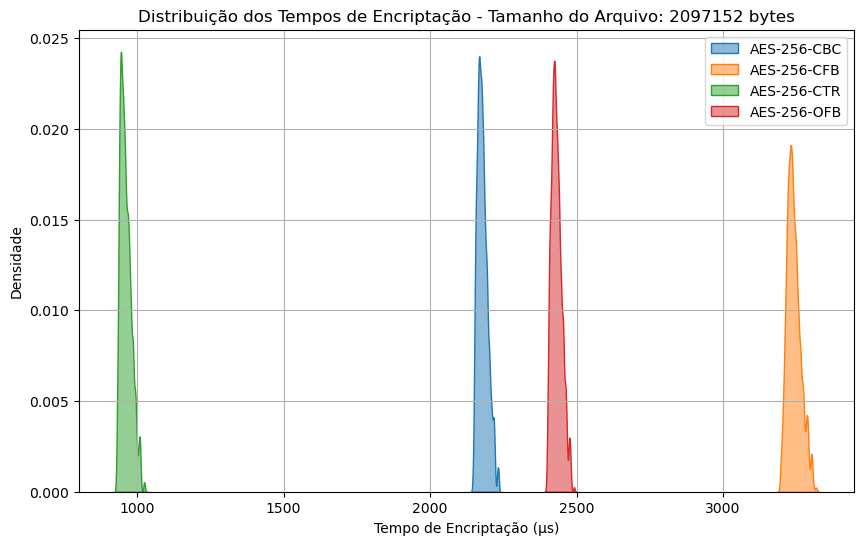

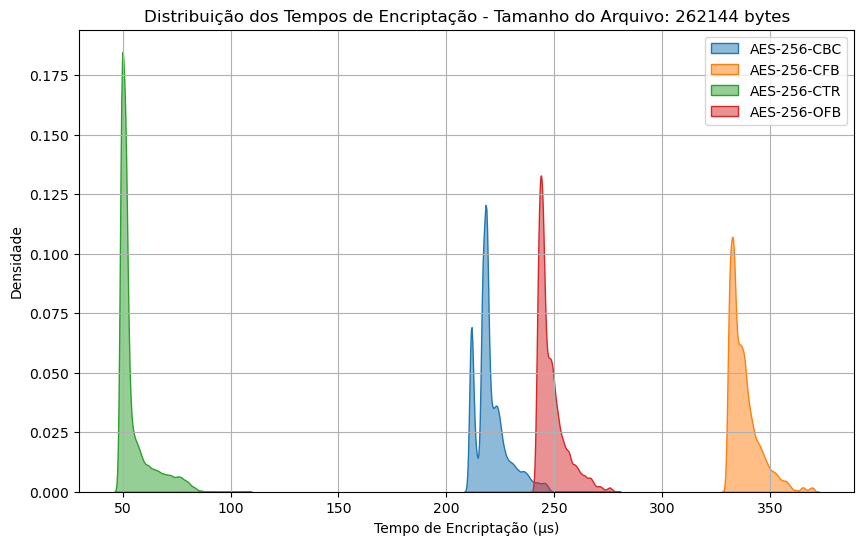

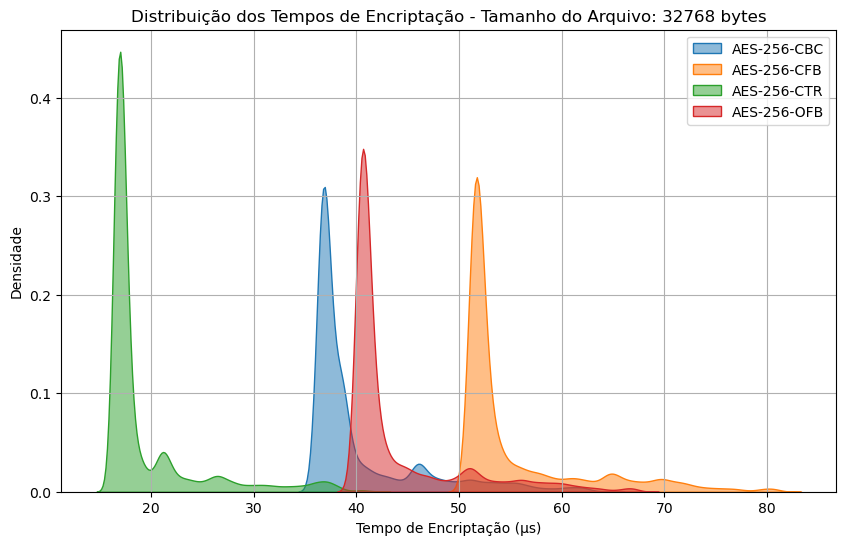

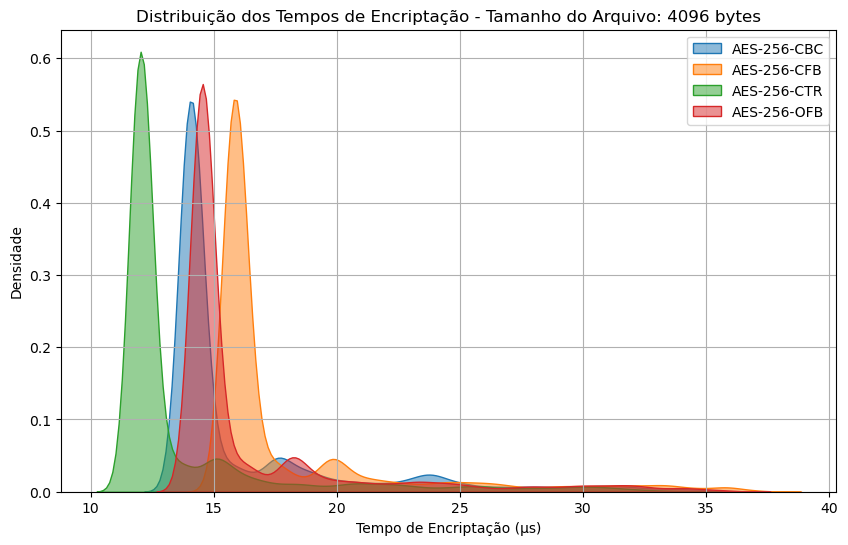

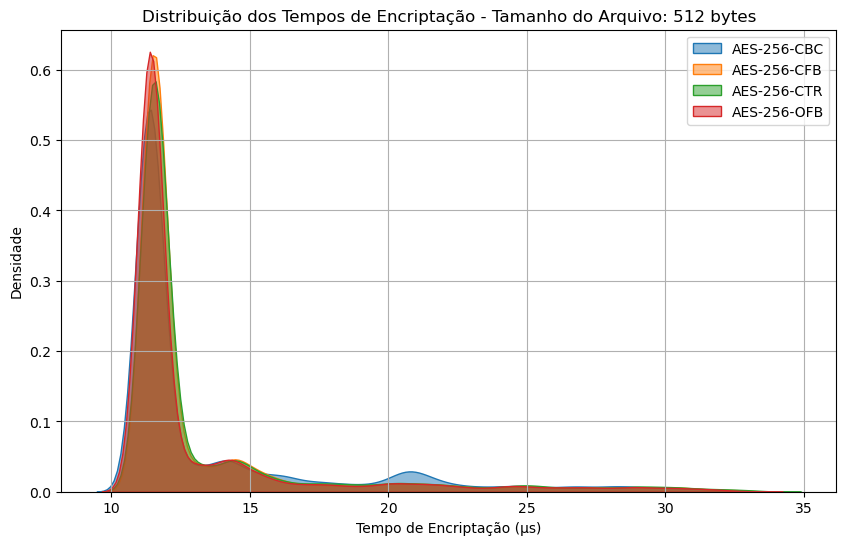

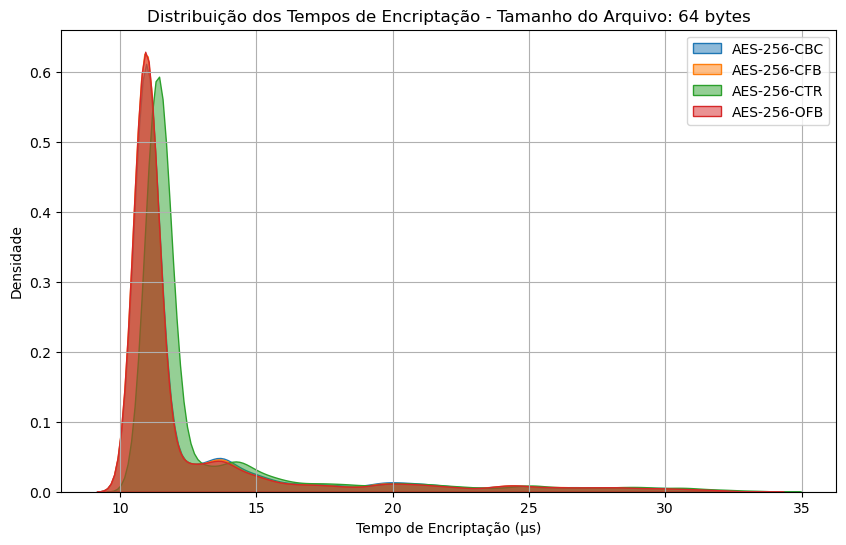

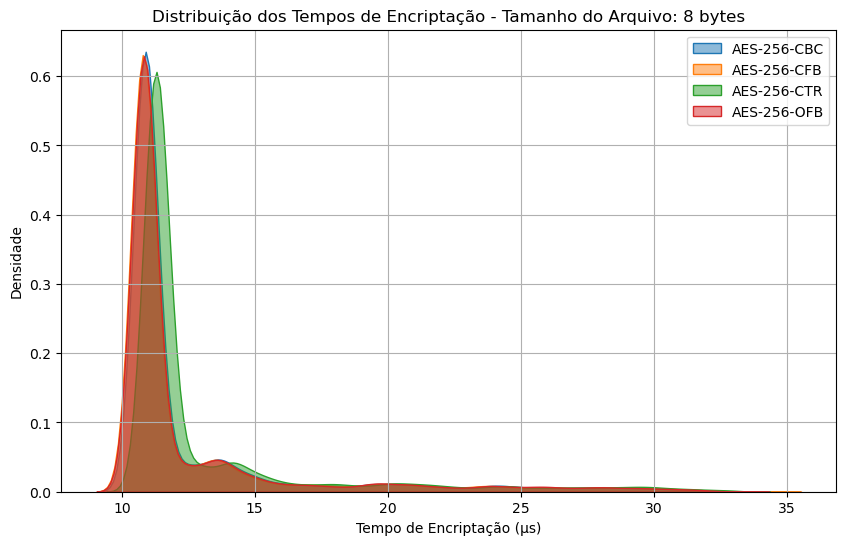

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pasta onde estão os arquivos CSV
stats_folder = "Stats"

# Modos de AES
aes_modes = ["CBC", "CFB", "CTR", "OFB","SHA-256",]

# Lê todos os arquivos CSV e combina os dados
dataframes = []
for mode in aes_modes:
    if mode == "SHA-256":
        file_path = os.path.join(stats_folder, f"sha256_benchmarks.csv")
    else: file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode  # Adiciona uma coluna para identificar o modo
        dataframes.append(df)

# Combina todos os DataFrames em um único
data = pd.concat(dataframes, ignore_index=True)

# Lista de tamanhos de arquivos
file_sizes = data["File Size"].unique()

# Cria um gráfico de distribuição para cada tamanho de arquivo
for size in file_sizes:
    plt.figure(figsize=(10, 6))
    for mode in aes_modes:
        # Filtra os dados pelo tamanho do arquivo e pelo modo
        mode_data = data[(data["File Size"] == size) & (data["Mode"] == mode)]
        encryption_times = mode_data["Encryption Time"]

        # Conta a frequência de cada tempo de encriptação
        value_counts = encryption_times.value_counts()

        # Filtra apenas os tempos com mais de 50 amostras
        valid_times = value_counts[value_counts > 20].index
        filtered_data = encryption_times[encryption_times.isin(valid_times)]

        # Plota a distribuição dos tempos de encriptação usando KDE
        sns.kdeplot(filtered_data, label=f"AES-256-{mode}", fill=True, alpha=0.5)

    # Configurações do gráfico
    plt.title(f"Distribuição dos Tempos de Encriptação - Tamanho do Arquivo: {size} bytes")
    plt.xlabel("Tempo de Encriptação (µs)")
    plt.ylabel("Densidade")
    plt.legend()
    plt.grid(True)

    # Salva o gráfico como imagem
    output_path = os.path.join(stats_folder, f"encryption_distribution_{size}.png")
    #plt.savefig(output_path)
    plt.show()

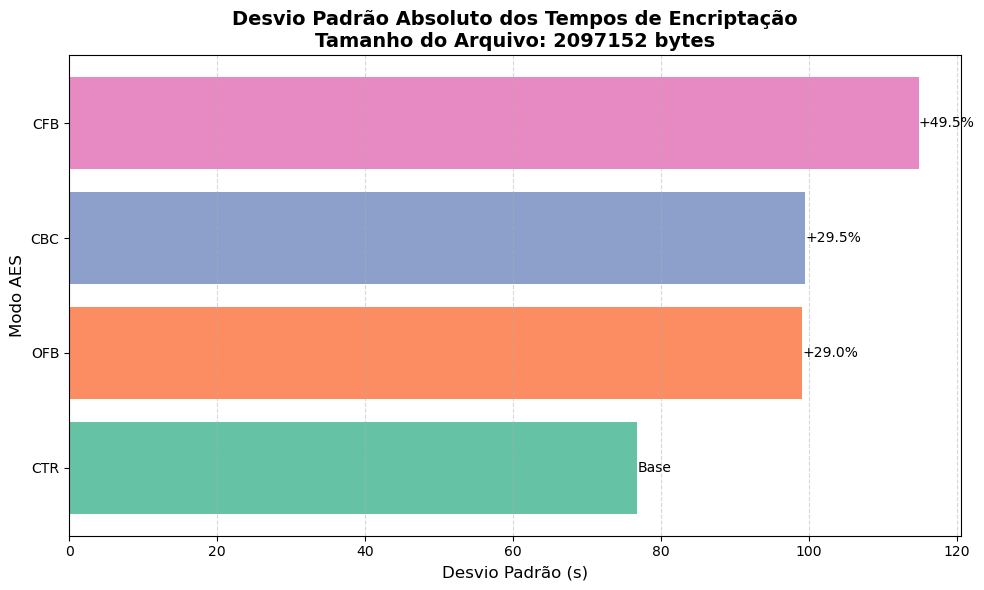

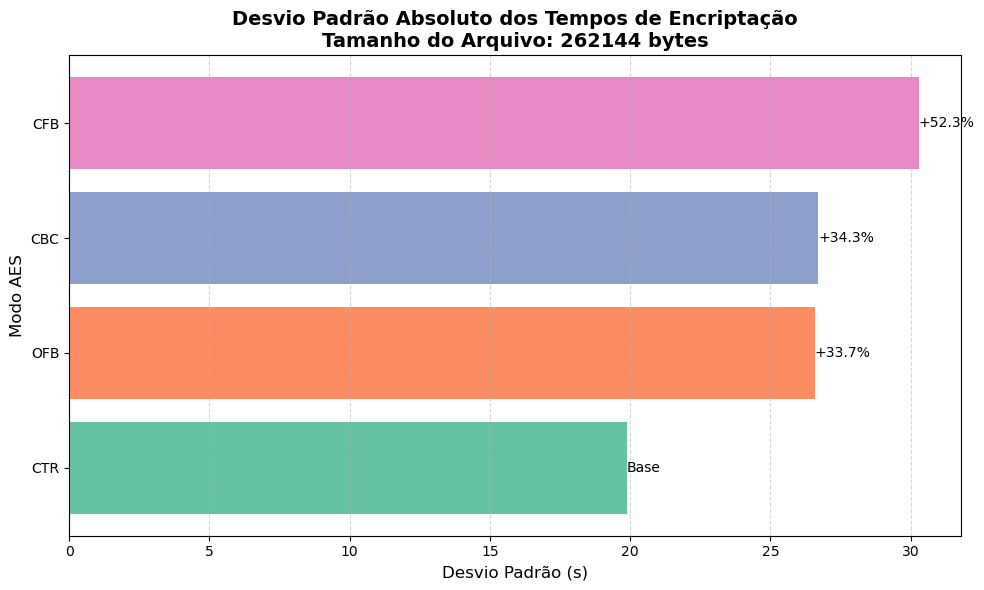

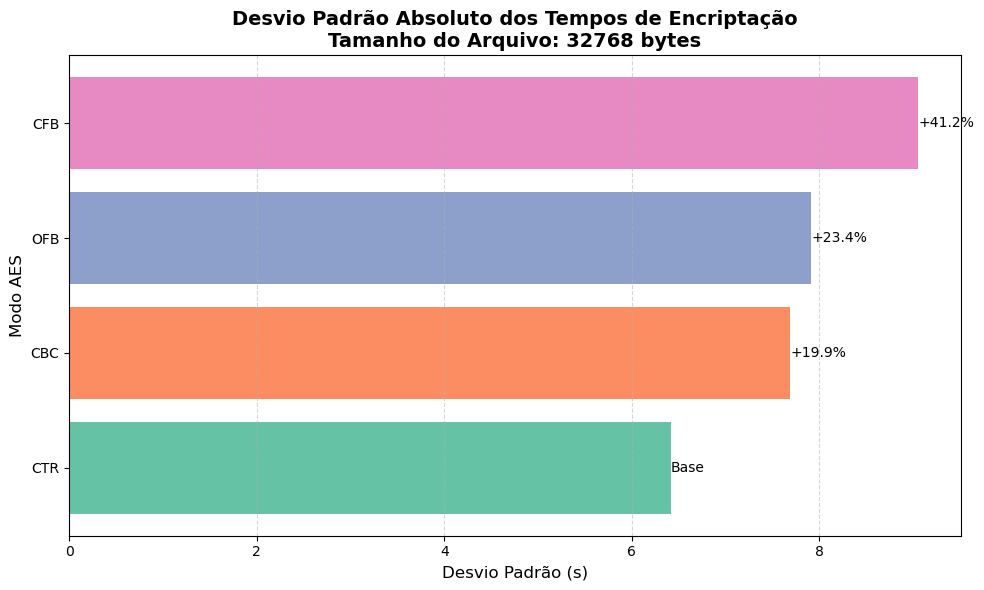

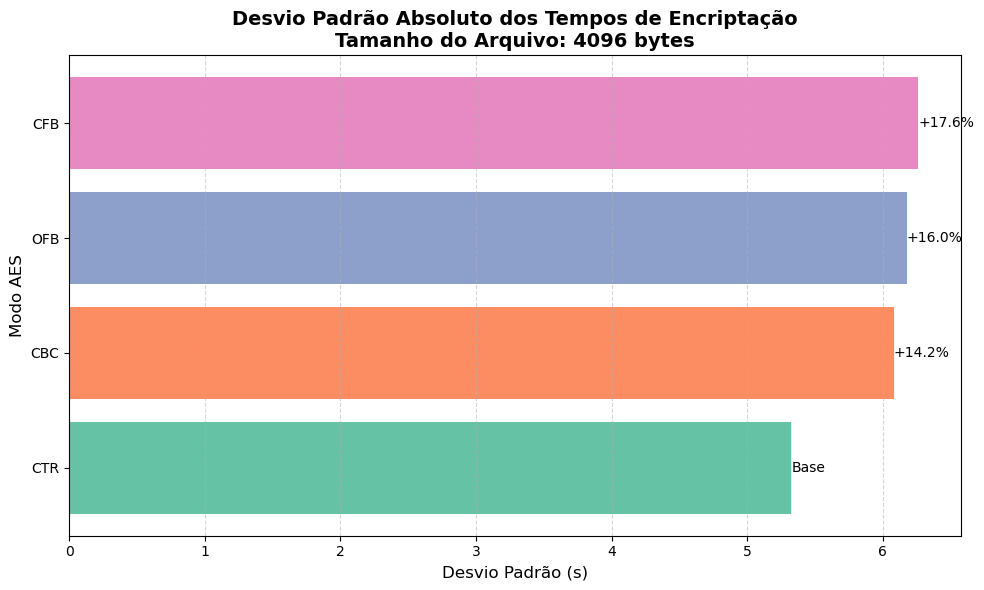

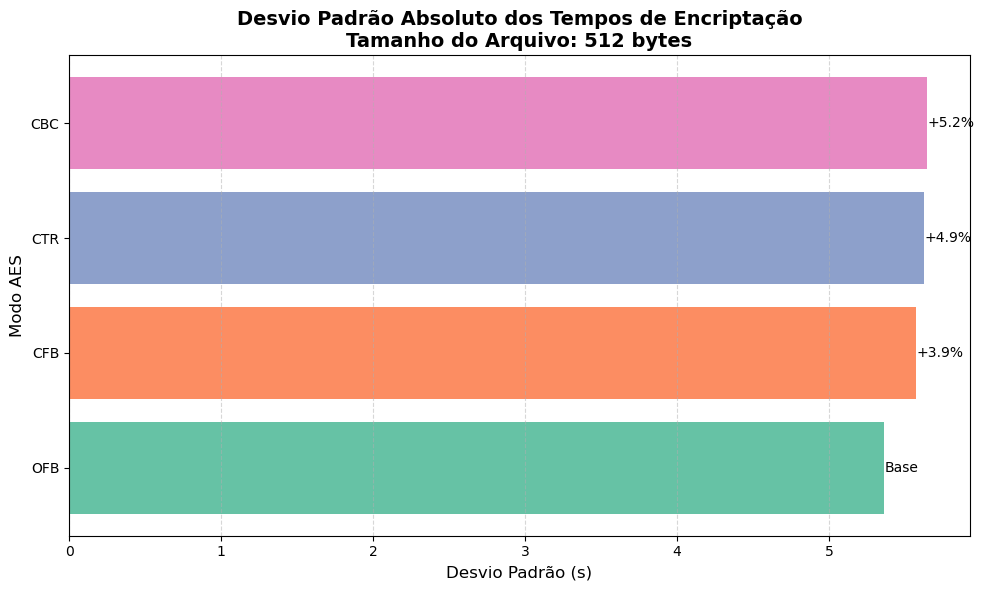

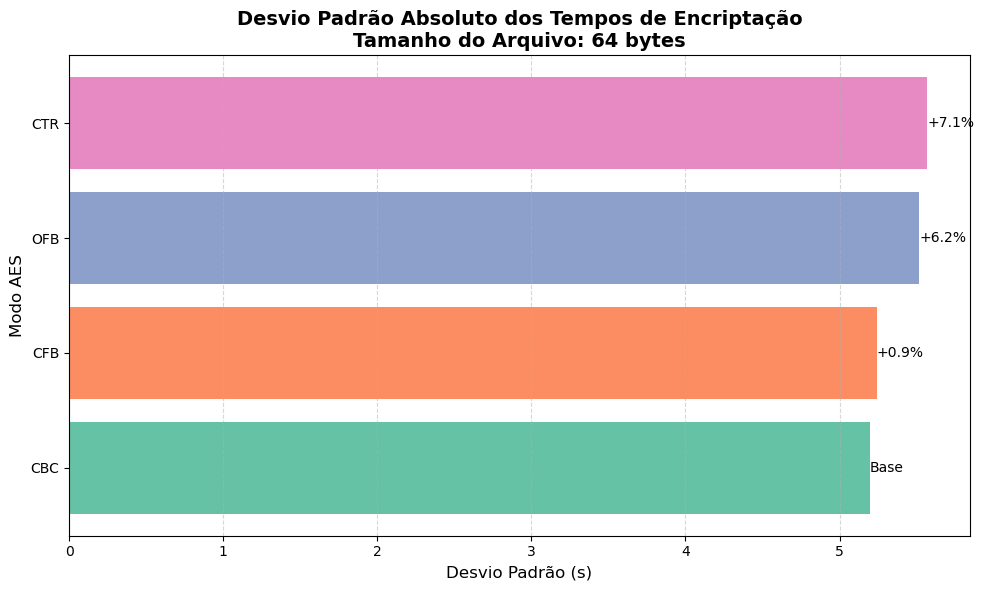

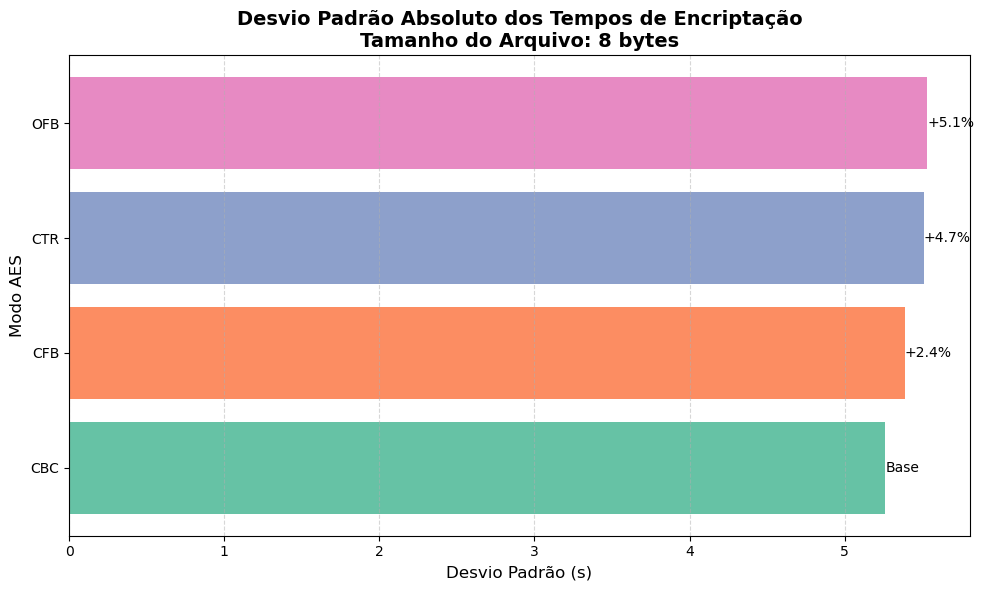

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo visual
plt.style.use("seaborn-v0_8-muted")

# Pasta onde estão os arquivos CSV
stats_folder = "Stats"

# Modos de AES
aes_modes = ["CBC", "CFB", "CTR", "OFB"]

# Lê os arquivos CSV
dataframes = []
for mode in aes_modes:
    file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode
        dataframes.append(df)

# Combina todos os DataFrames
data = pd.concat(dataframes, ignore_index=True)

# Tamanhos únicos
file_sizes = data["File Size"].unique()

# Calcula os desvios padrão absolutos
std_devs = []
for size in file_sizes:
    for mode in aes_modes:
        mode_data = data[(data["File Size"] == size) & (data["Mode"] == mode)]
        std_dev = mode_data["Encryption Time"].std()
        std_devs.append({"File Size": size, "Mode": mode, "Std Dev": std_dev})

# DataFrame final
std_dev_df = pd.DataFrame(std_devs)

# Paleta de cores
colors = sns.color_palette("Set2", len(aes_modes))

# Gráfico para cada tamanho
for size in file_sizes:
    plt.figure(figsize=(10, 6))
    size_data = std_dev_df[std_dev_df["File Size"] == size].sort_values(by="Std Dev", ascending=True)

    # Menor desvio padrão como base
    base_std_dev = size_data["Std Dev"].iloc[0]

    # Diferença percentual em relação ao menor
    size_data["Diff (%)"] = ((size_data["Std Dev"] - base_std_dev) / base_std_dev) * 100

    bars = plt.barh(size_data["Mode"], size_data["Std Dev"], color=colors)

    # Anotações nas barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        diff_pct = size_data["Diff (%)"].iloc[i]
        label = f"+{diff_pct:.1f}%" if diff_pct > 0 else "Base"
        plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2, label, va='center', fontsize=10)

    plt.title(f"Desvio Padrão Absoluto dos Tempos de Encriptação\nTamanho do Arquivo: {size} bytes", fontsize=14, weight='bold')
    plt.xlabel("Desvio Padrão (s)", fontsize=12)
    plt.ylabel("Modo AES", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()

    plt.show()


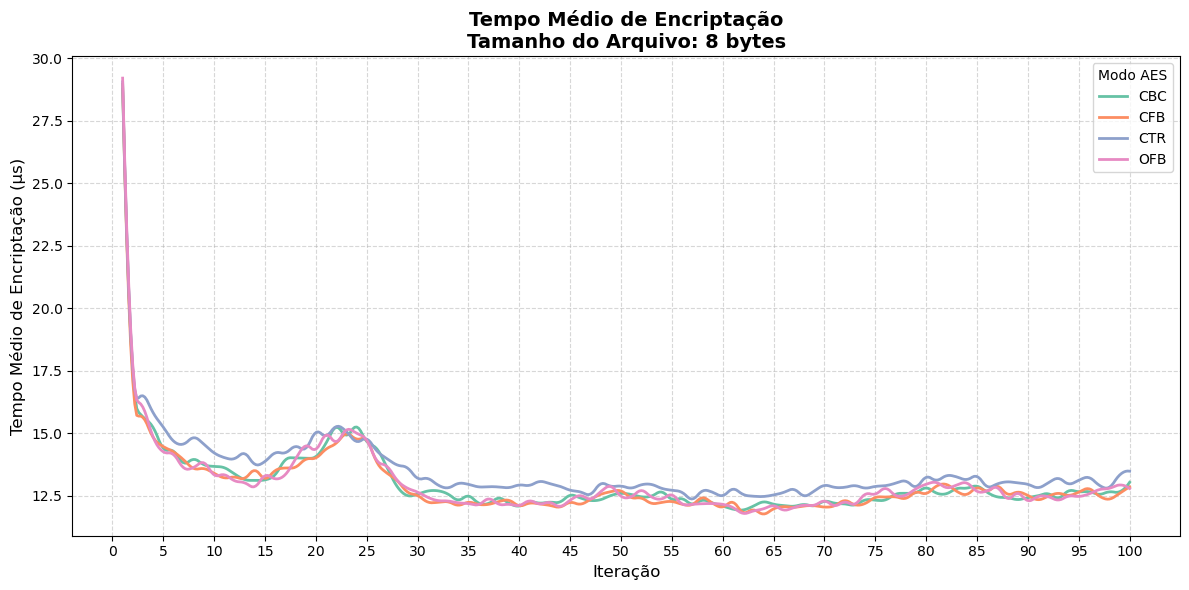

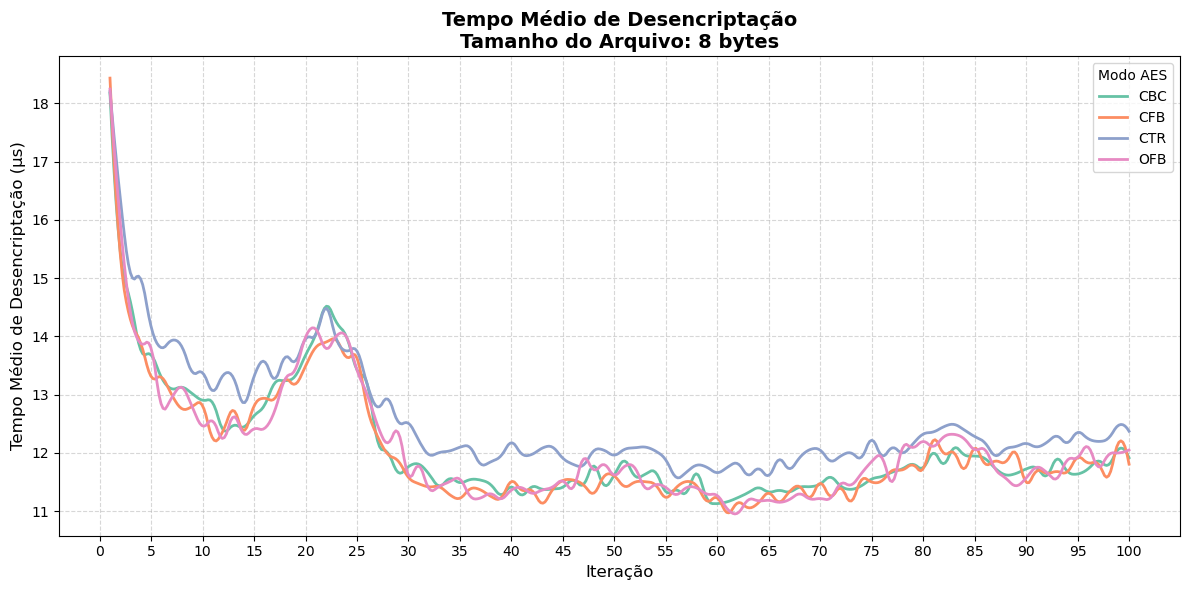

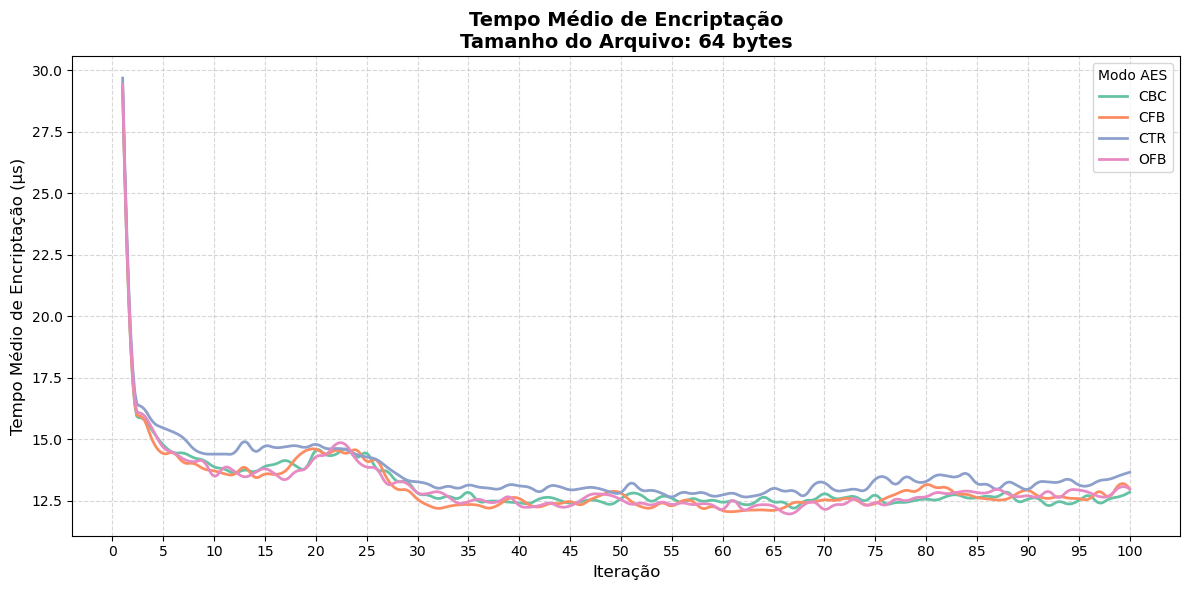

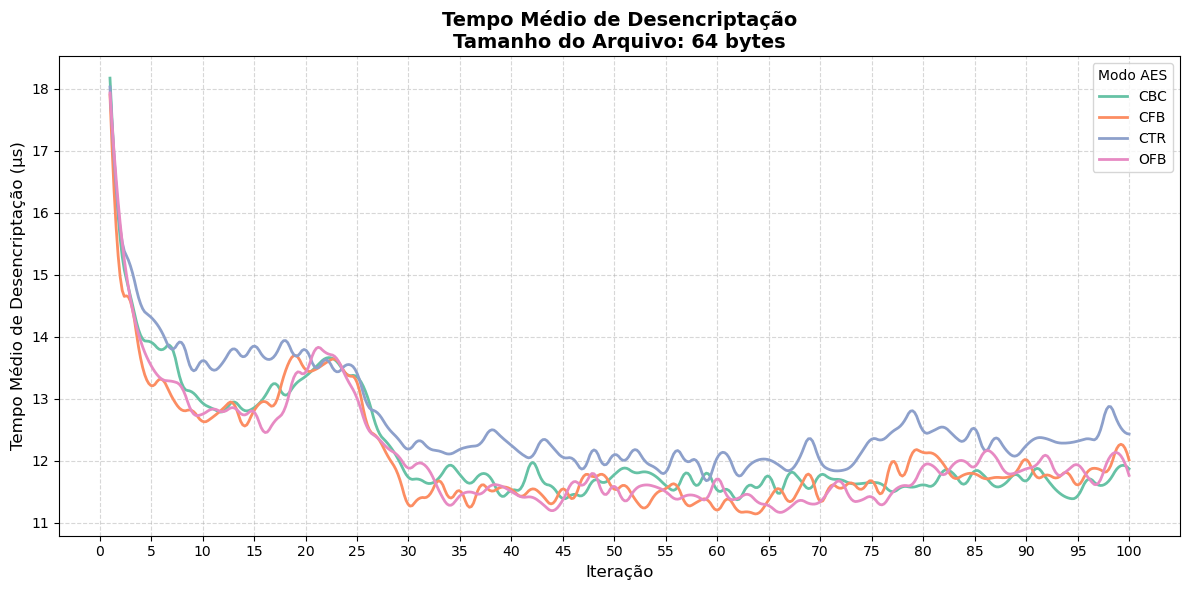

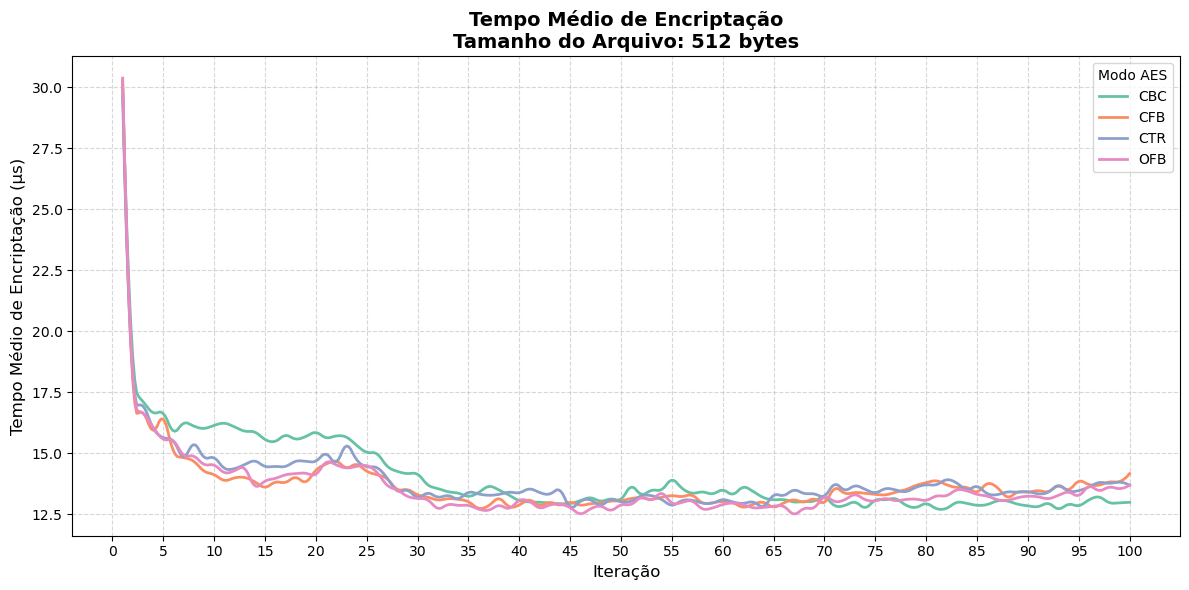

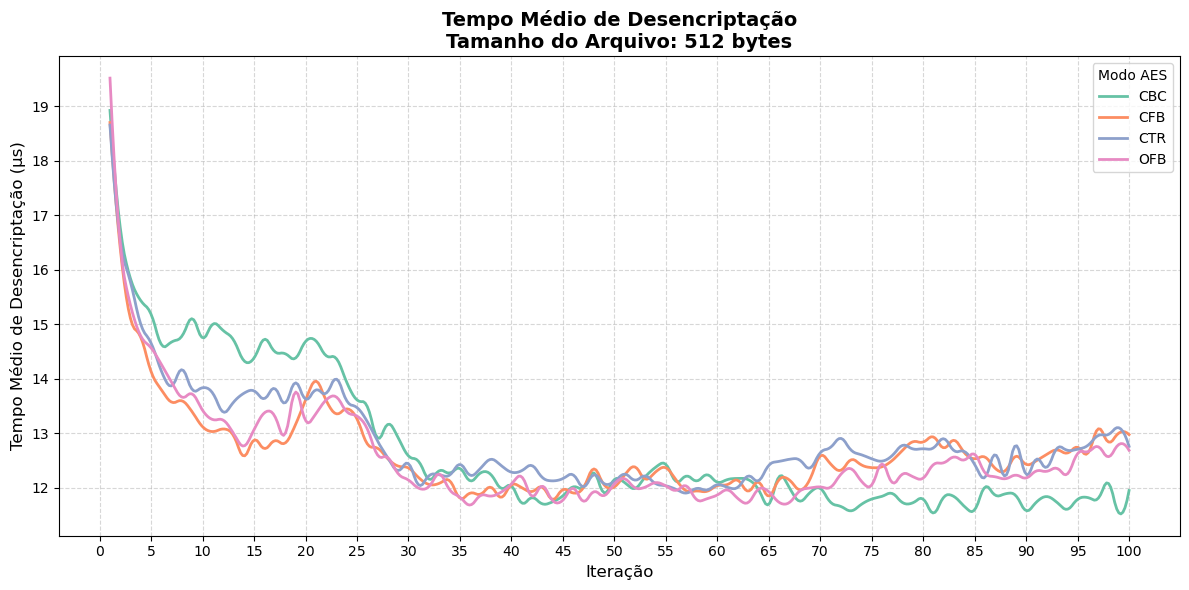

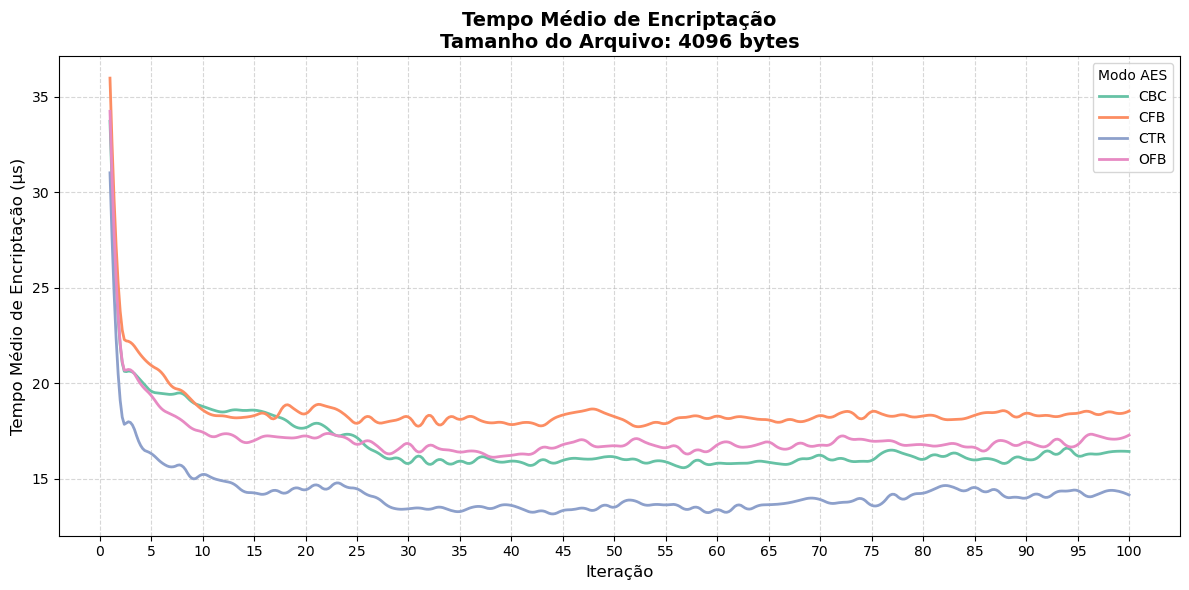

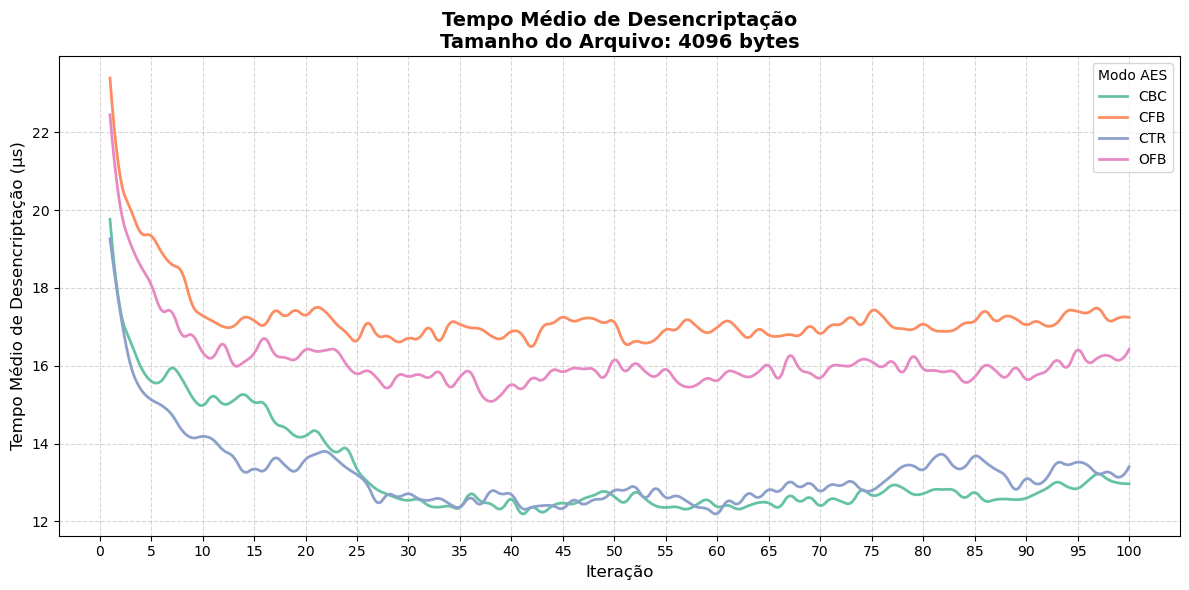

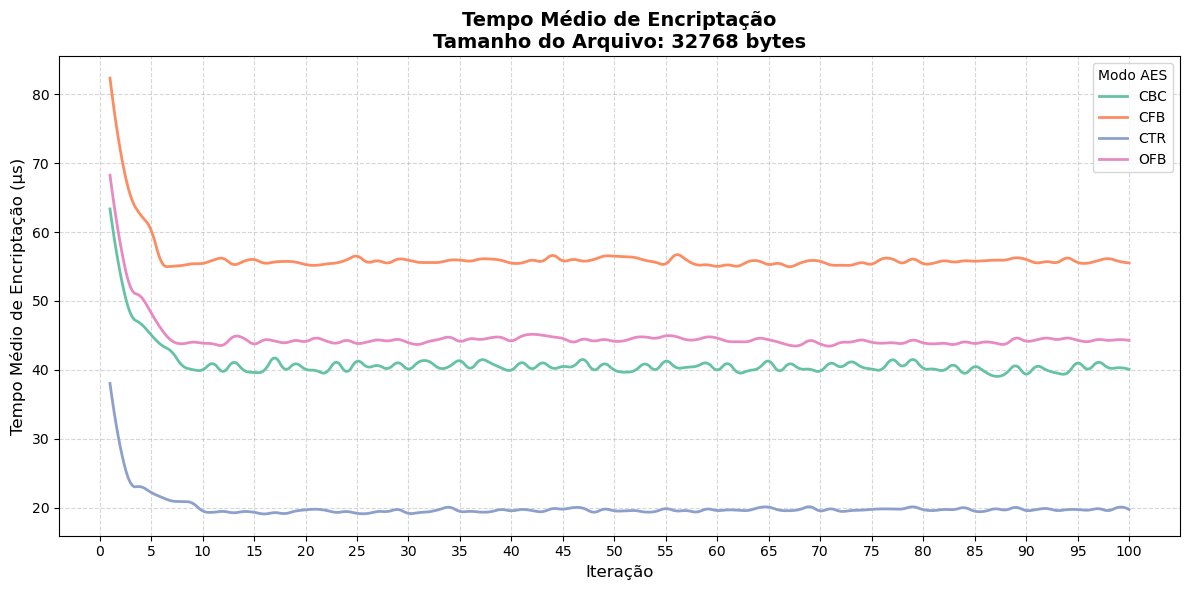

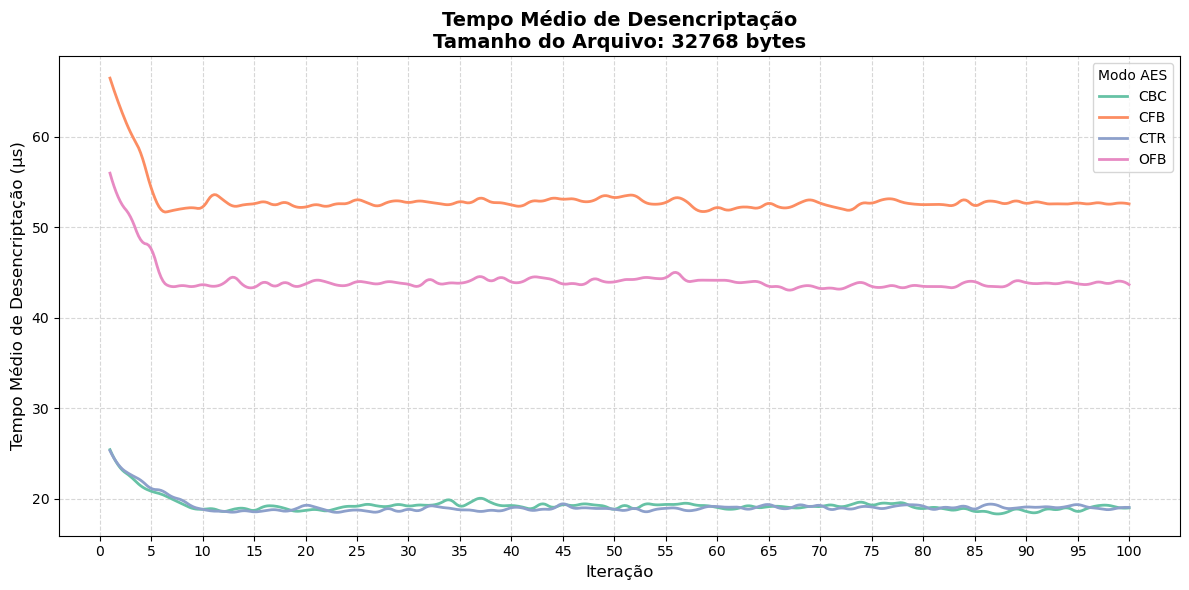

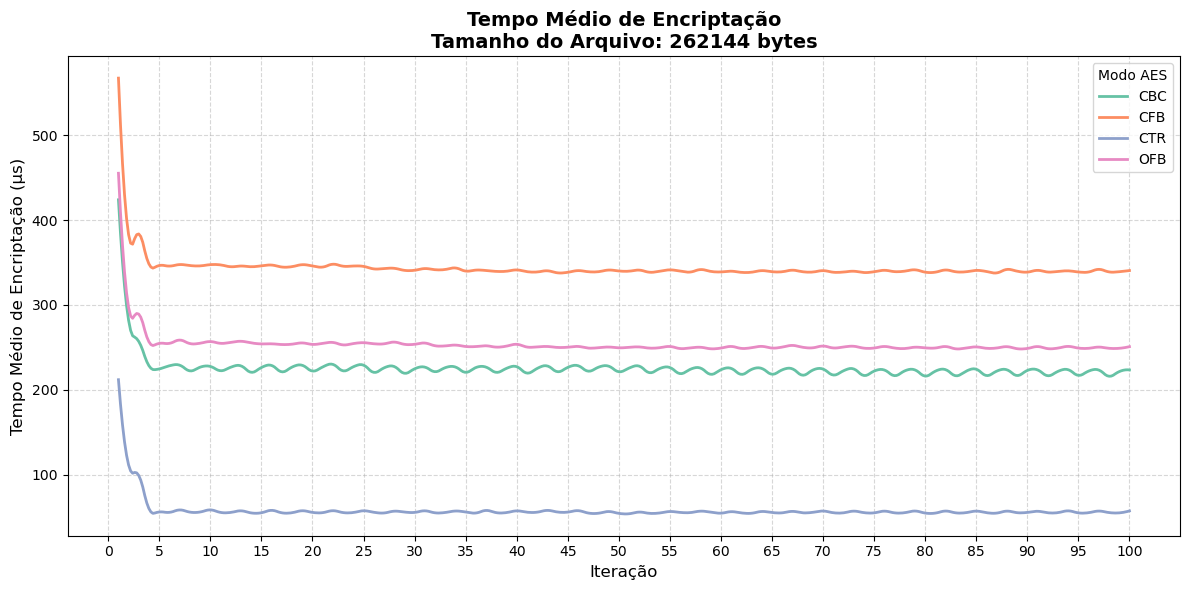

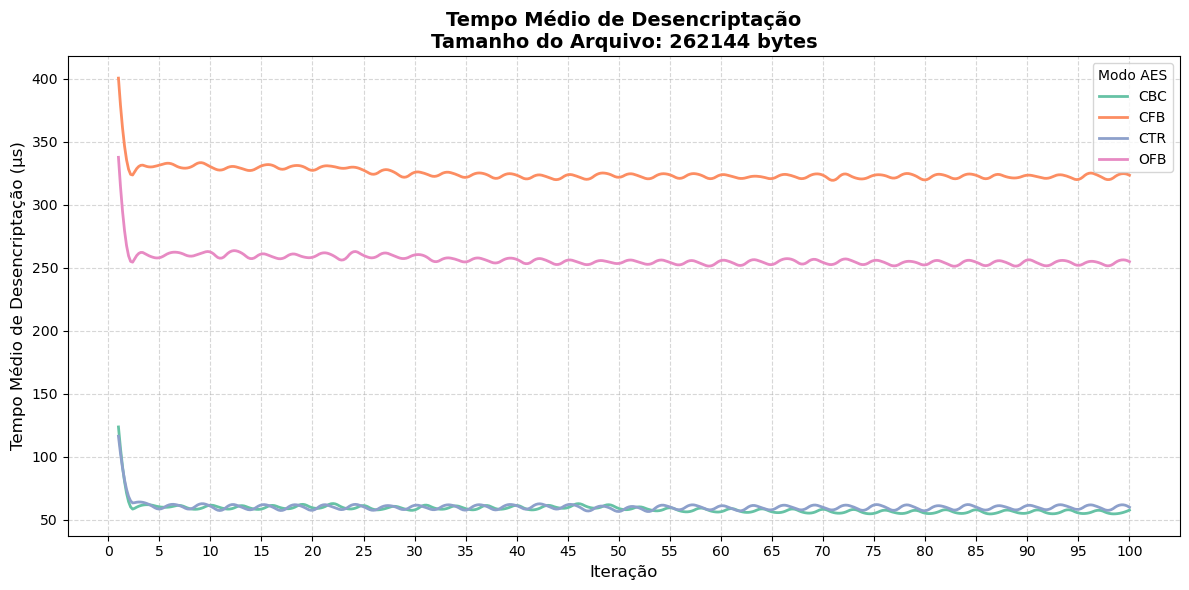

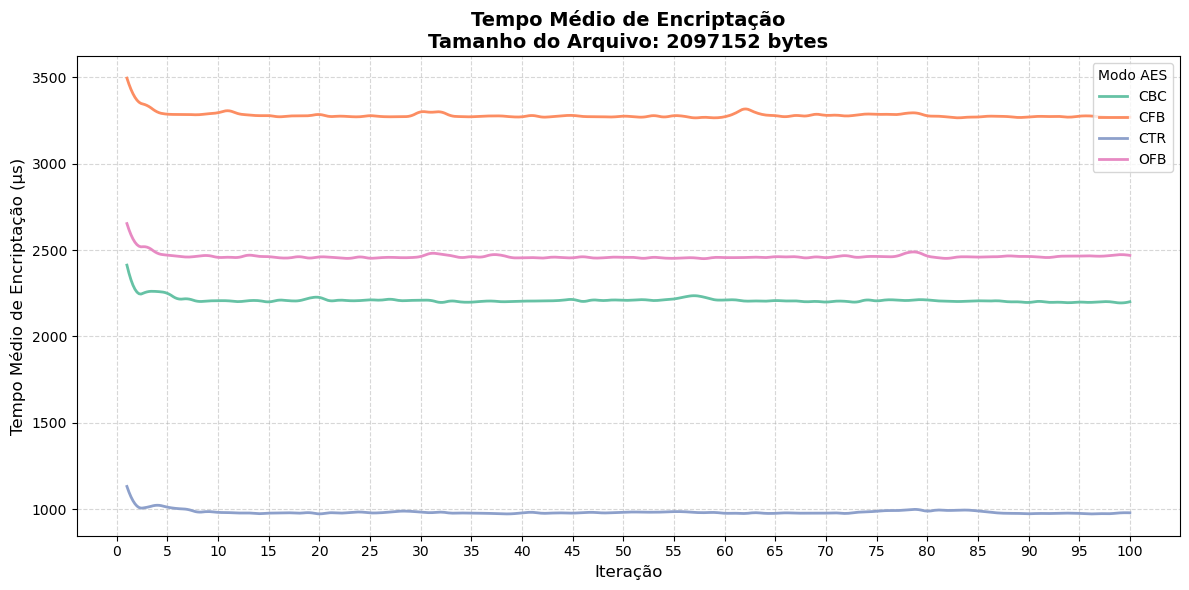

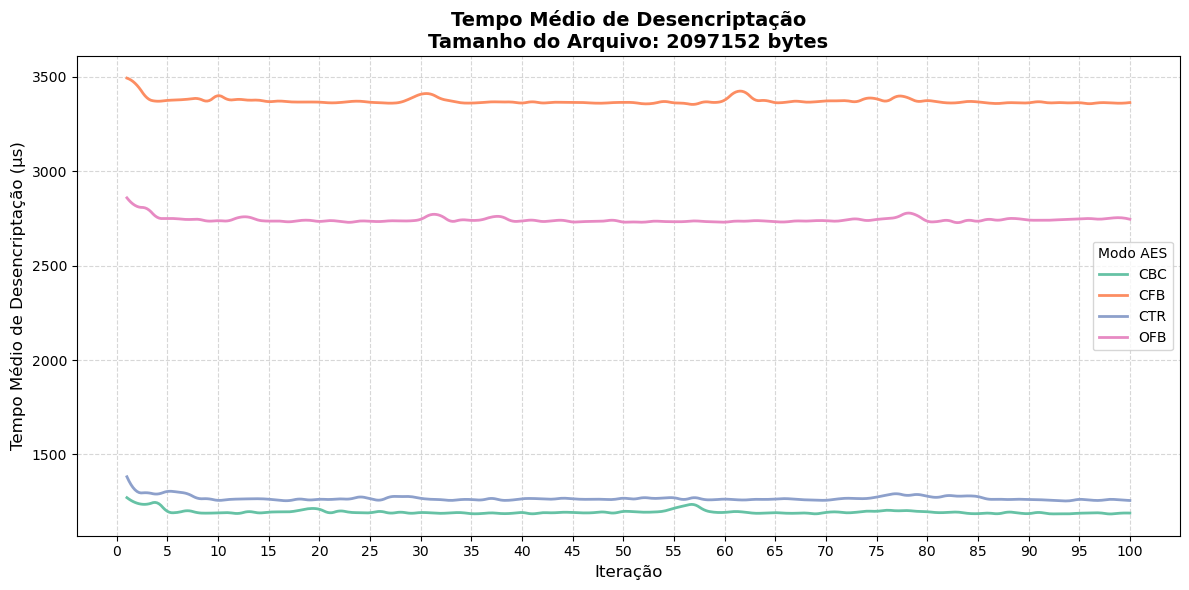

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import numpy as np

# Estilo visual
plt.style.use("seaborn-v0_8-muted")

# Pasta dos arquivos
stats_folder = "Stats"
aes_modes = ["CBC", "CFB", "CTR", "OFB"]

# Lê os CSVs
dataframes = []
for mode in aes_modes:
    file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode
        dataframes.append(df)

# Junta tudo
data = pd.concat(dataframes, ignore_index=True)

# Tamanhos únicos
file_sizes = sorted(data["File Size"].unique())
colors = sns.color_palette("Set2", len(aes_modes))

# Função para suavizar via spline
def smooth_curve(x, y, points=500):  # Aumentando a densidade de pontos
    x_smooth = np.linspace(min(x), max(x), points)  # Mais pontos
    spline = make_interp_spline(x, y, k=2)  # Spline cúbica (ou mudar k=2 para quadrática)
    y_smooth = spline(x_smooth)
    return x_smooth, y_smooth

# Para cada tamanho de ficheiro
for size in file_sizes:
    # --- Encriptação ---
    plt.figure(figsize=(12, 6))
    for mode, color in zip(aes_modes, colors):
        filtered = data[(data["Mode"] == mode) & (data["File Size"] == size)]
        avg_enc = filtered.groupby("Iteration")["Encryption Time"].mean()

        # Pega as iterações reais e os tempos médios
        x, y = avg_enc.index.values, avg_enc.values
        x_smooth, y_smooth = smooth_curve(x, y, points=500)  # Aumentando densidade
        plt.plot(x_smooth, y_smooth, label=mode, linewidth=1, color=color)

    plt.title(f"Tempo Médio de Encriptação\nTamanho do Arquivo: {size} bytes", fontsize=14, weight='bold')
    plt.xlabel("Iteração", fontsize=12)
    plt.ylabel("Tempo Médio de Encriptação (µs)", fontsize=12)
    plt.legend(title="Modo AES")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(np.arange(0, 101, 5))  # Marca cada 5 iterações (de 1 a 100)

    #plt.savefig(os.path.join(stats_folder, f"smooth_enc_time_iter_{size}.png"), dpi=300)
    plt.show()

    # --- Desencriptação ---
    plt.figure(figsize=(12,6))
    for mode, color in zip(aes_modes, colors):
        filtered = data[(data["Mode"] == mode) & (data["File Size"] == size)]
        avg_dec = filtered.groupby("Iteration")["Decryption Time"].mean()

        # Pega as iterações reais e os tempos médios
        x, y = avg_dec.index.values, avg_dec.values
        x_smooth, y_smooth = smooth_curve(x, y, points=500)  # Aumentando densidade
        plt.plot(x_smooth, y_smooth, label=mode, linewidth=2, color=color)

    plt.title(f"Tempo Médio de Desencriptação\nTamanho do Arquivo: {size} bytes", fontsize=14, weight='bold')
    plt.xlabel("Iteração", fontsize=12)
    plt.ylabel("Tempo Médio de Desencriptação (µs)", fontsize=12)
    plt.legend(title="Modo AES")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(np.arange(0, 101, 5))  # Marca cada 5 iterações (de 1 a 100)
    #plt.savefig(os.path.join(stats_folder, f"smooth_dec_time_iter_{size}.png"), dpi=300)
    plt.show()



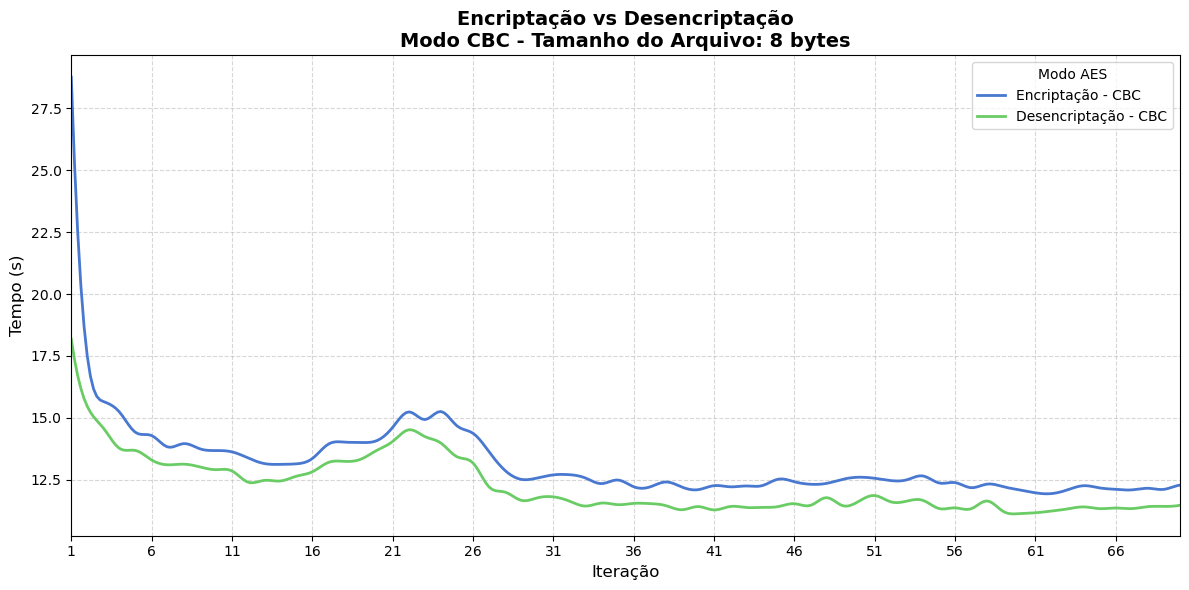

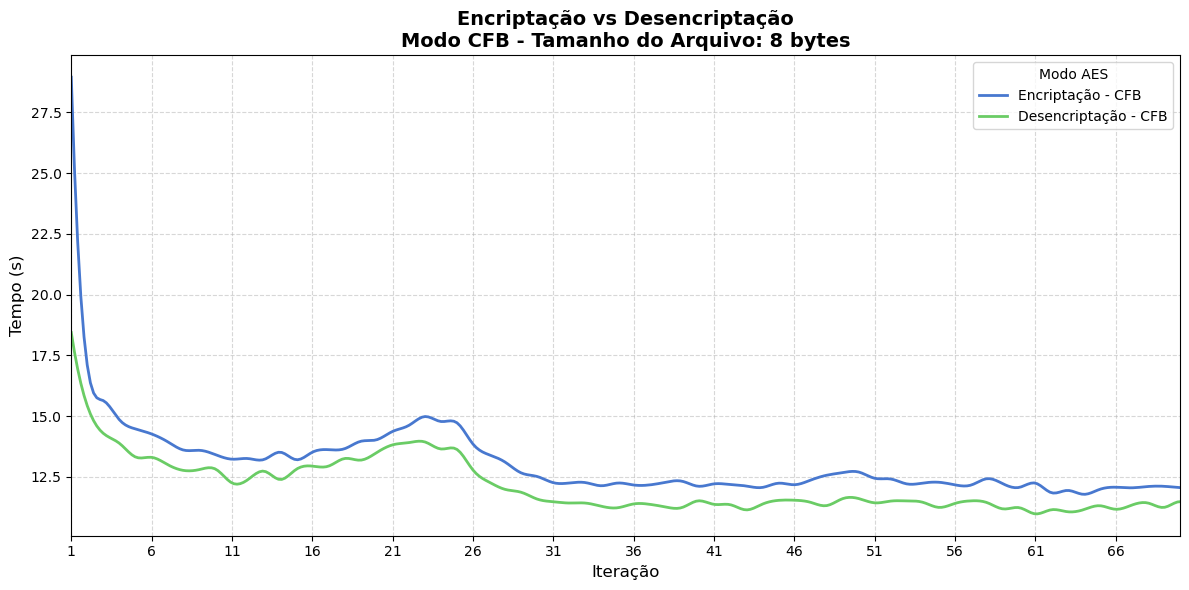

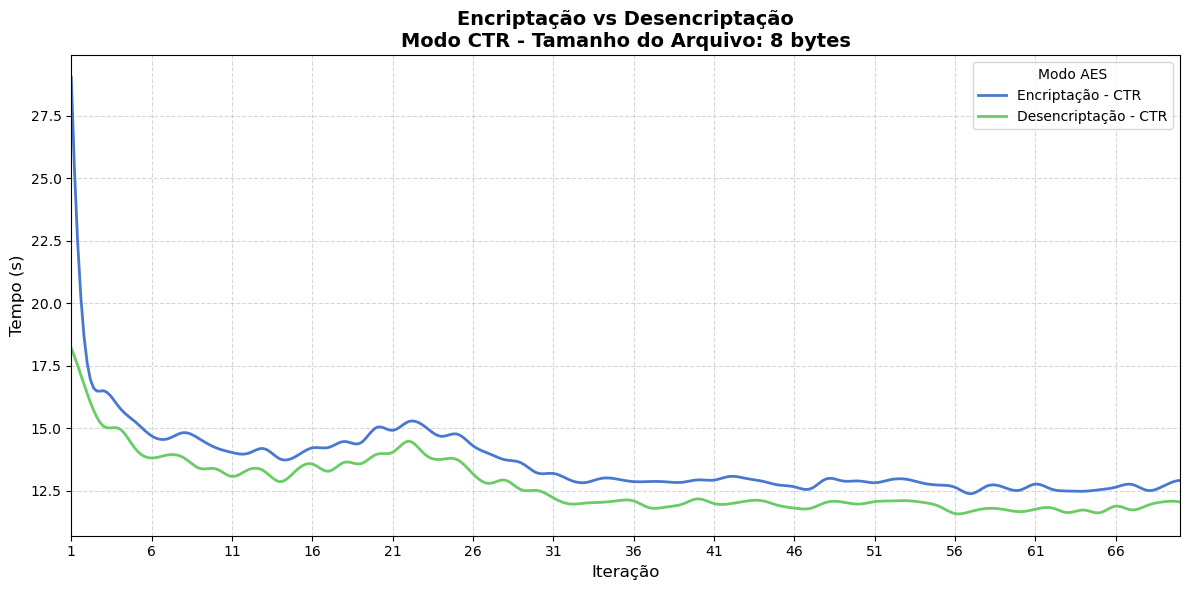

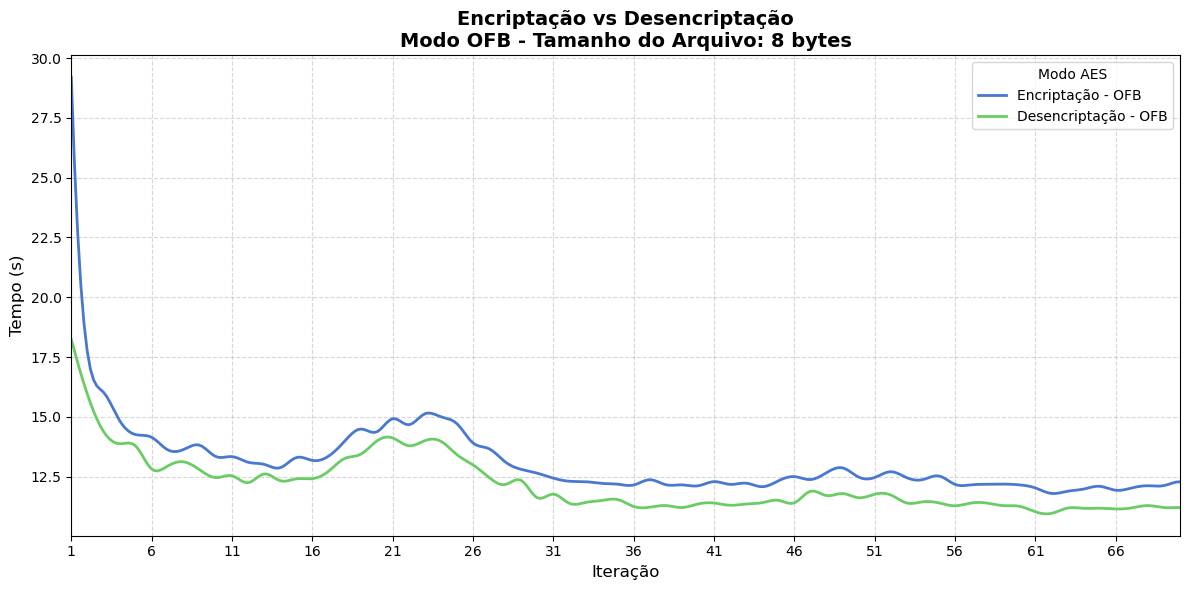

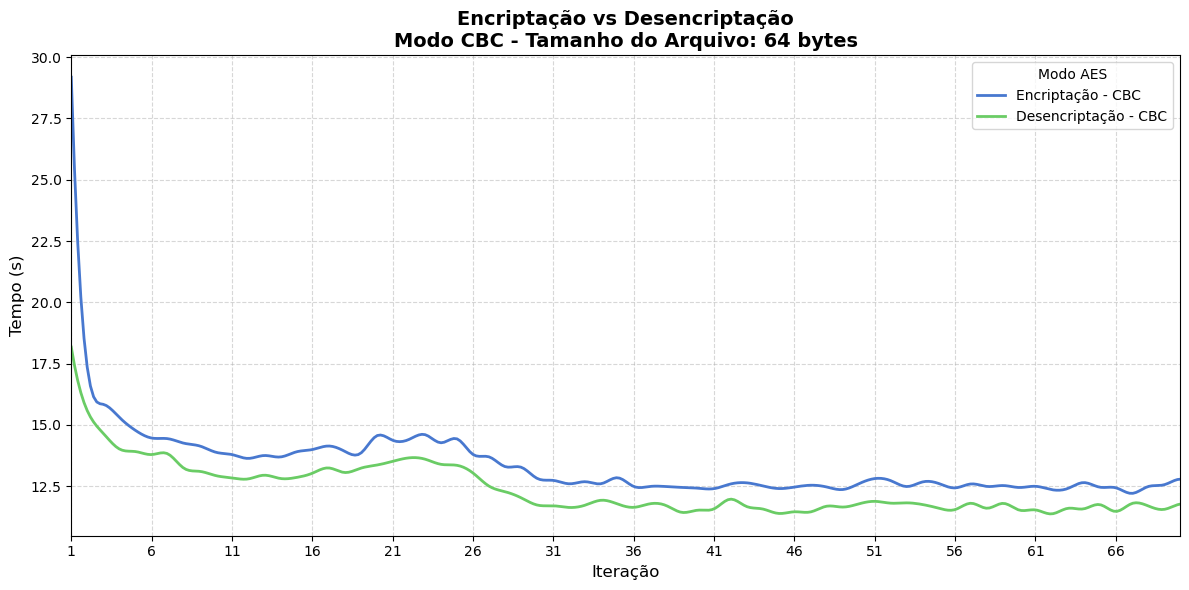

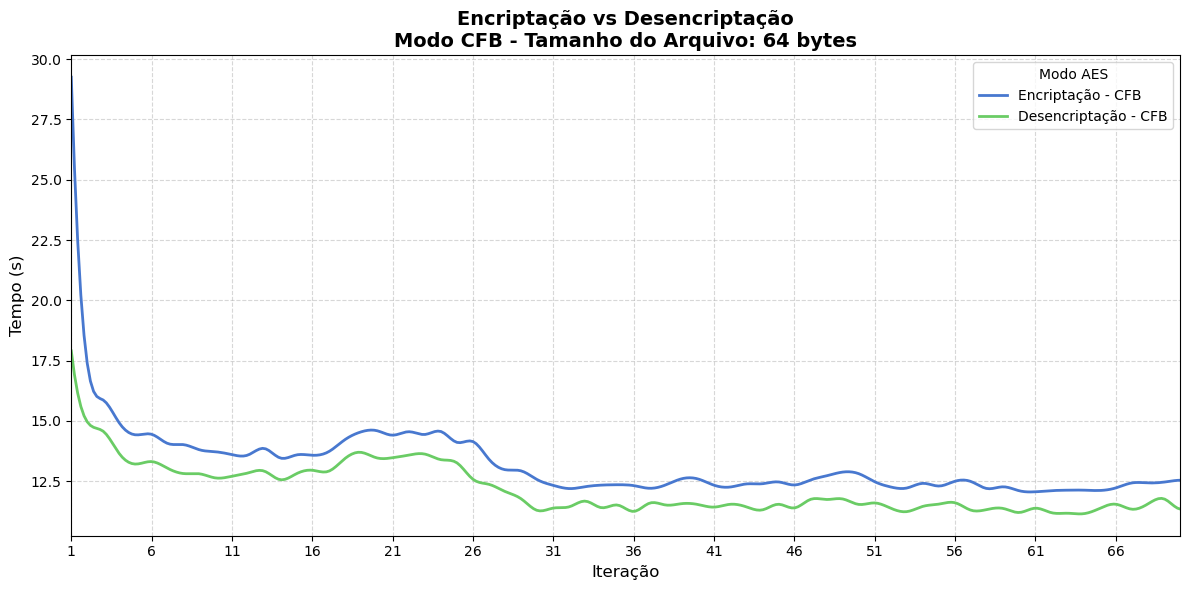

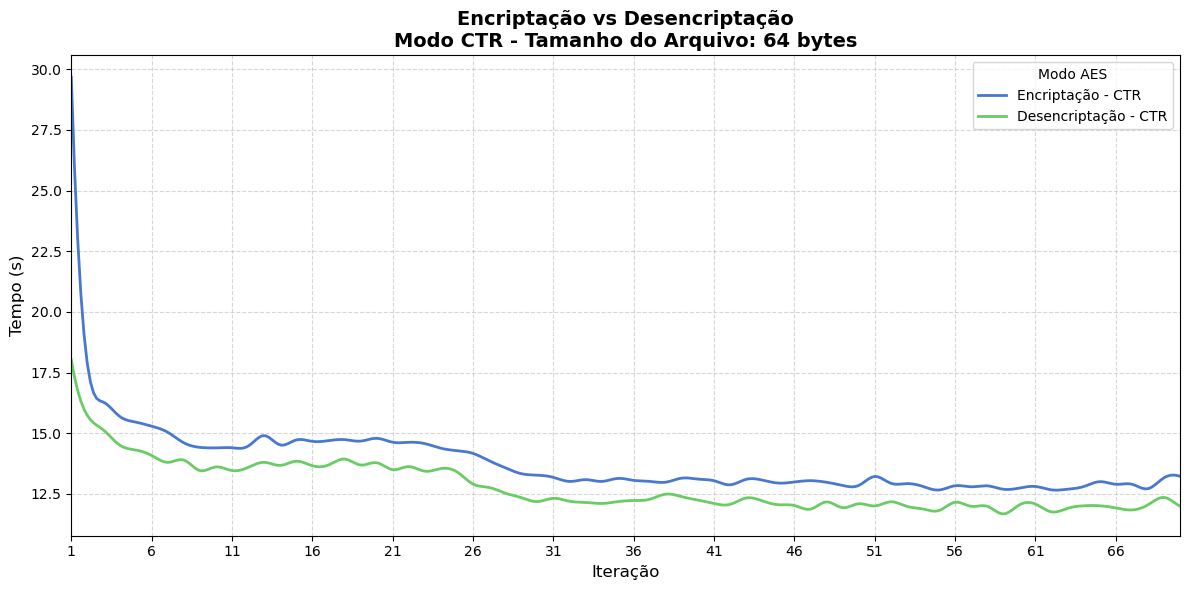

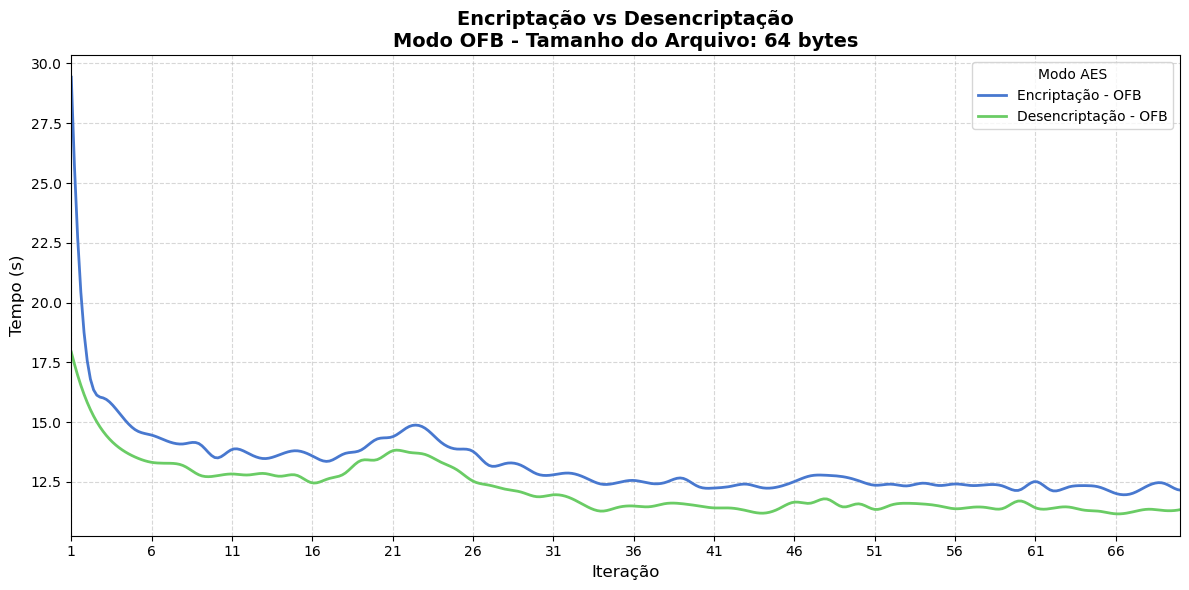

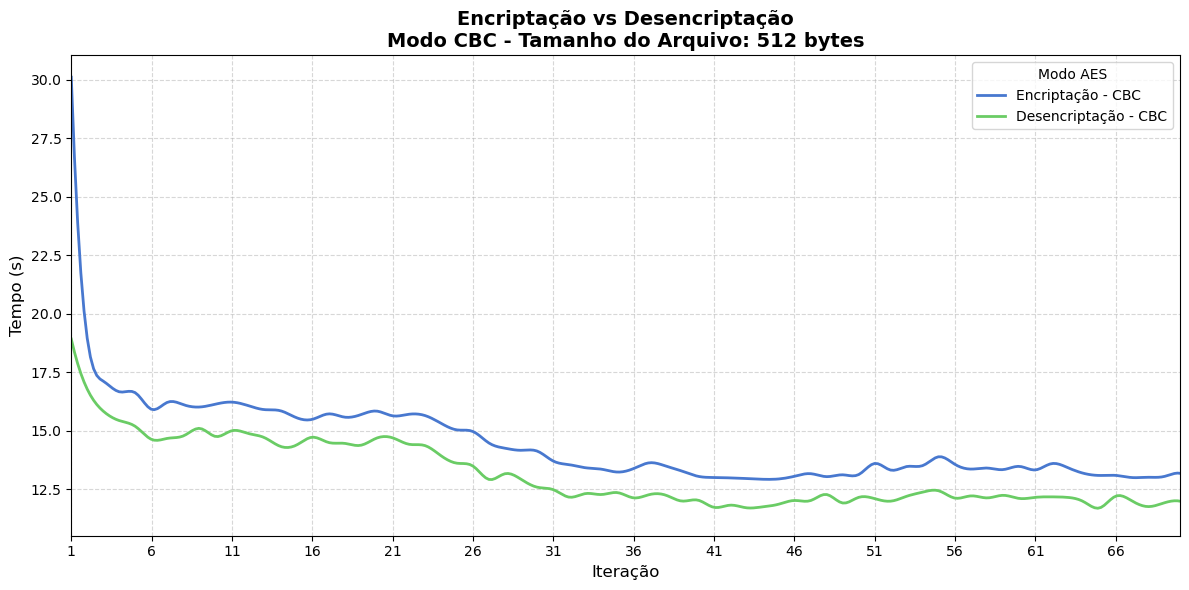

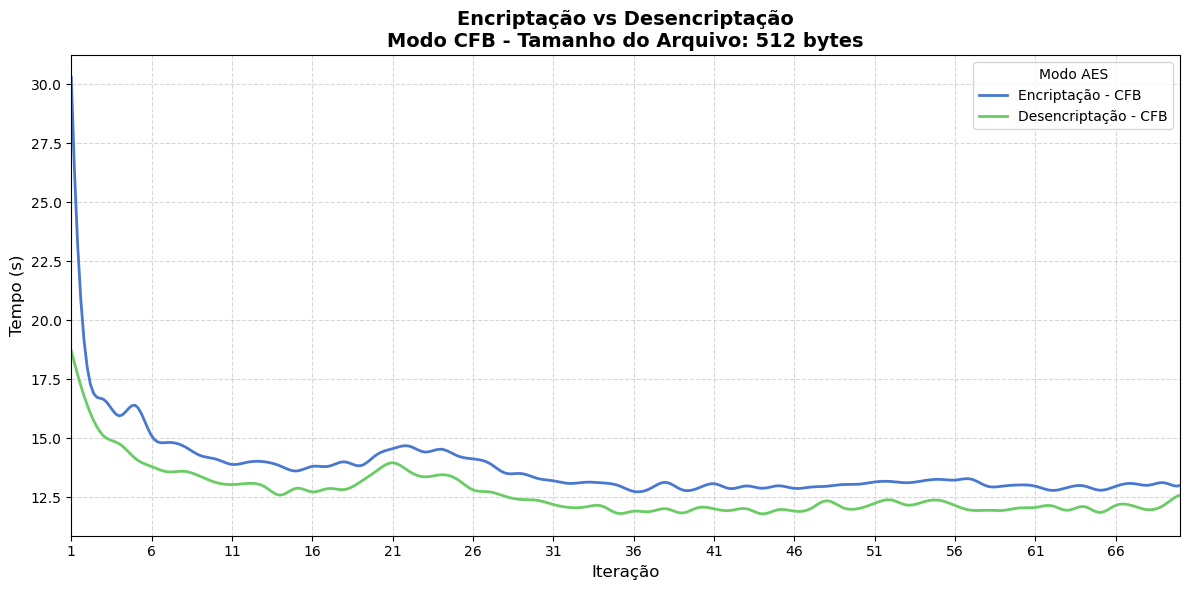

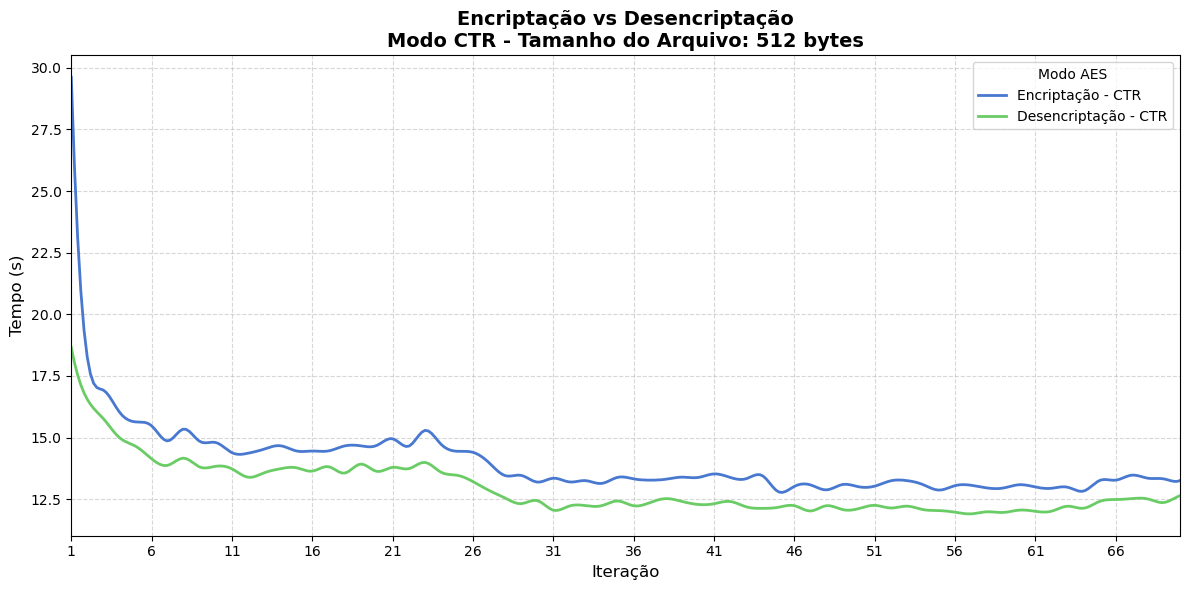

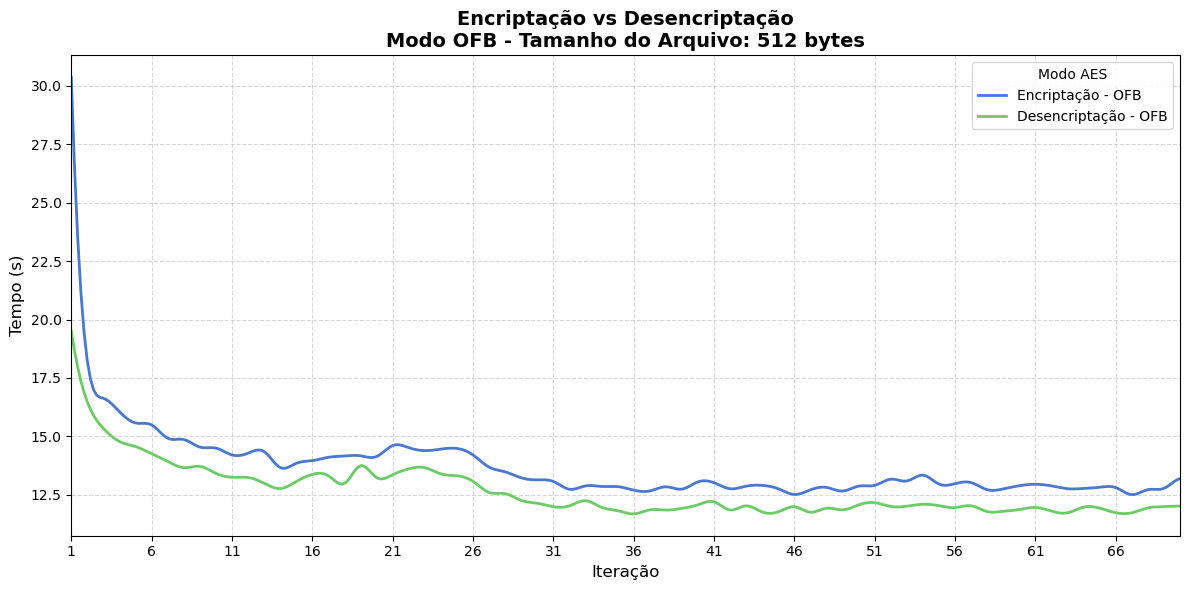

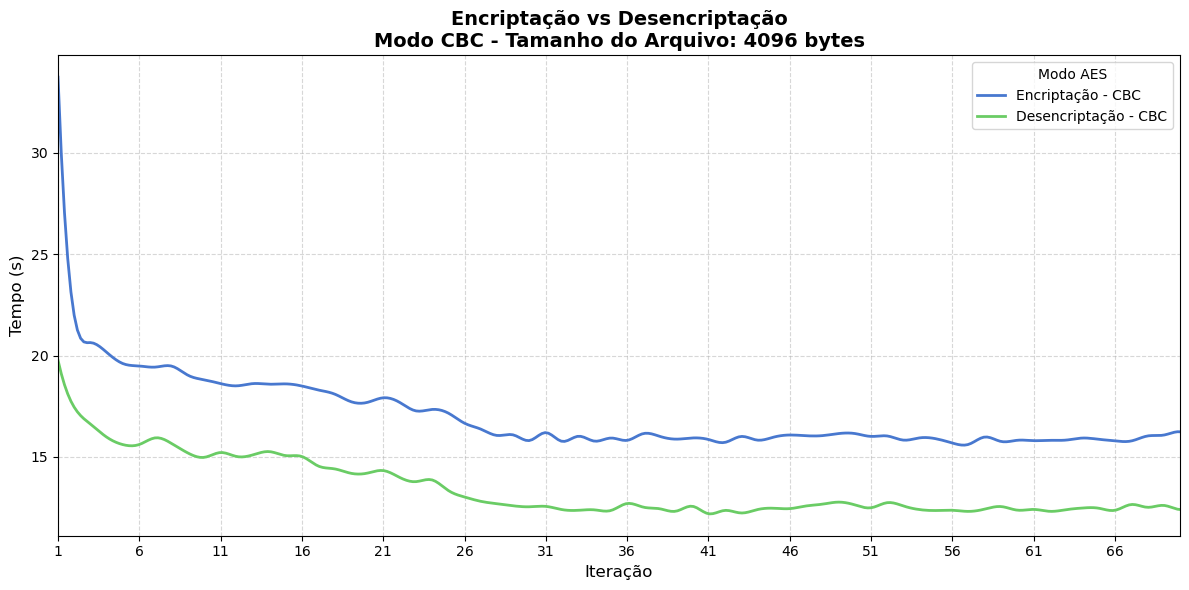

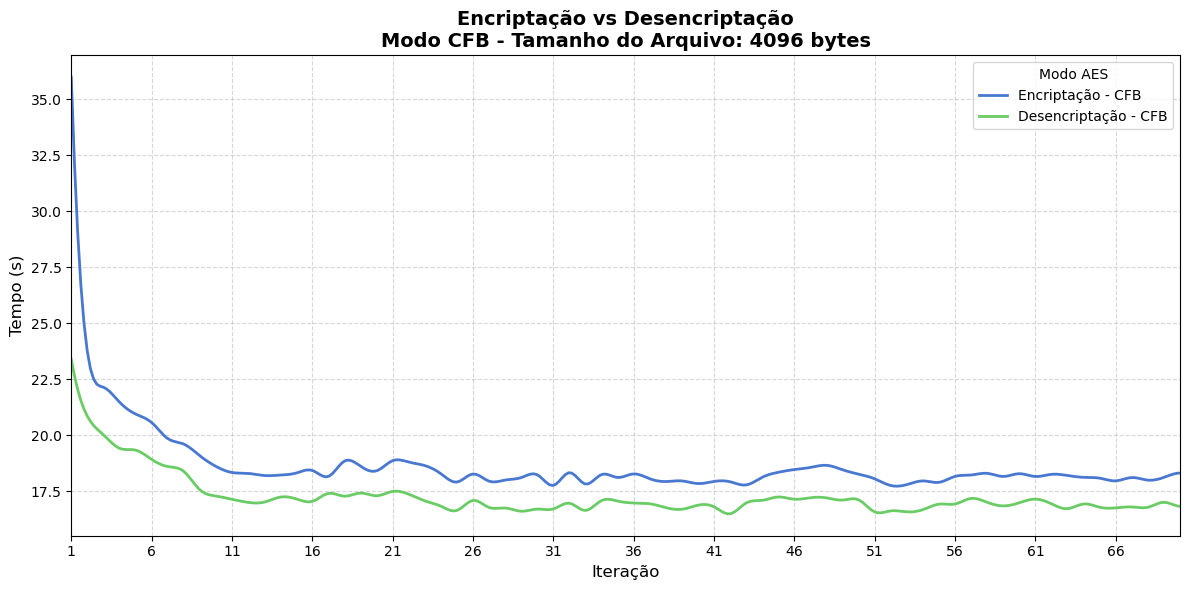

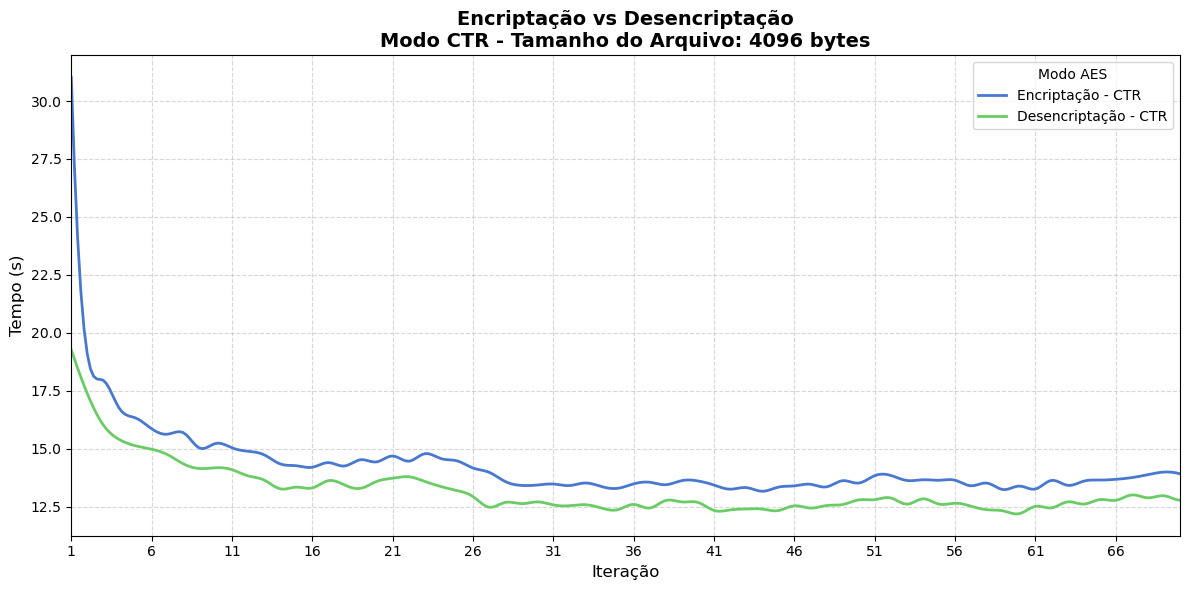

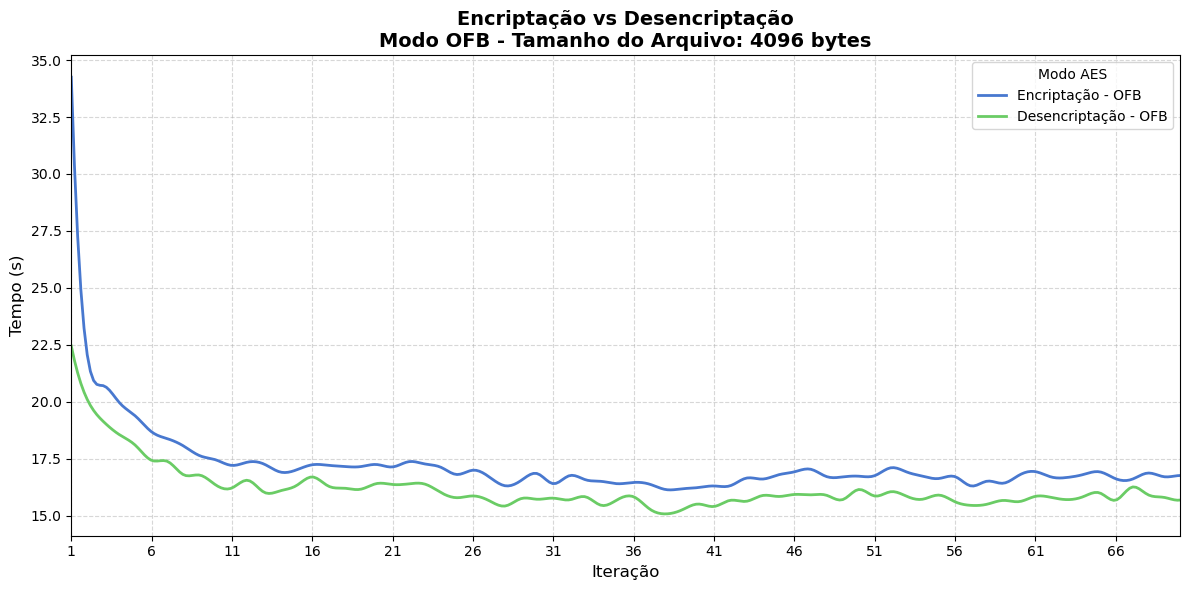

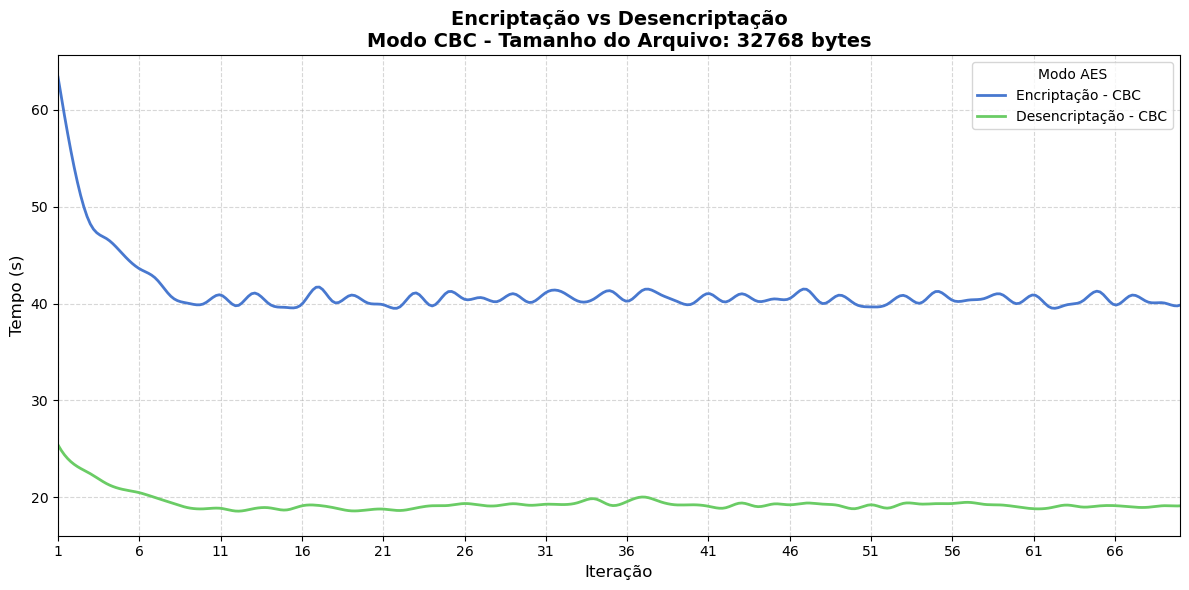

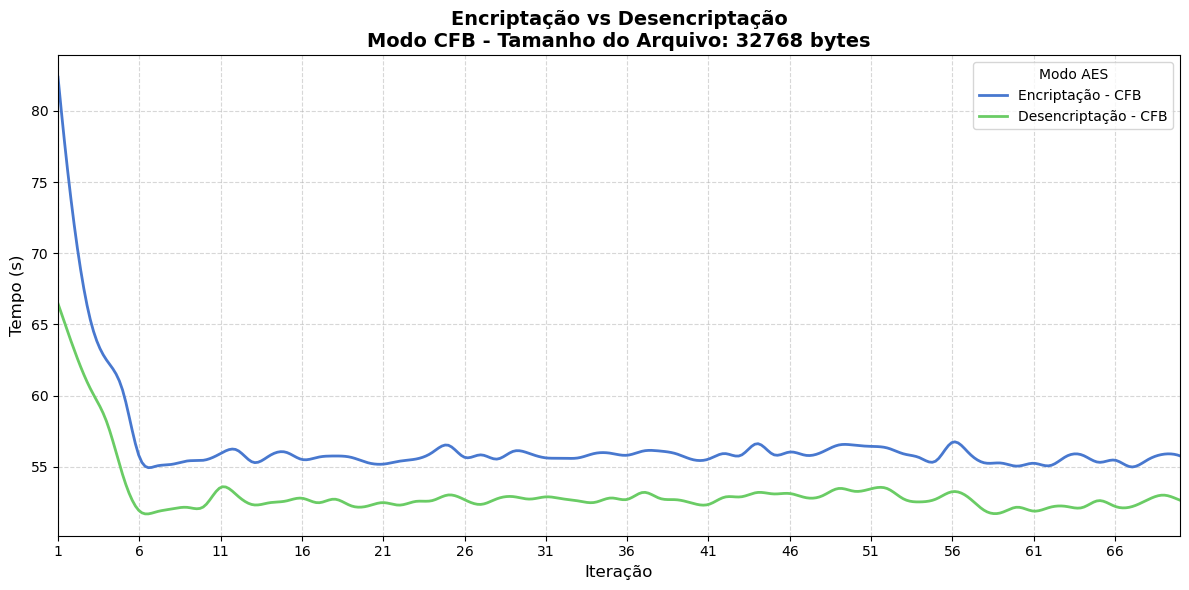

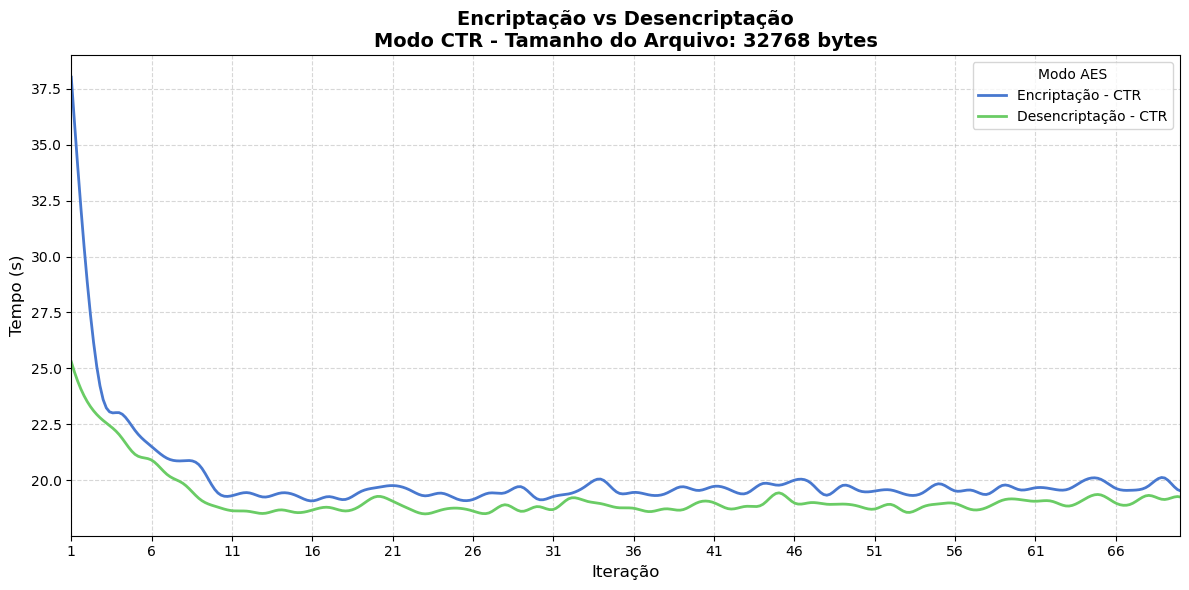

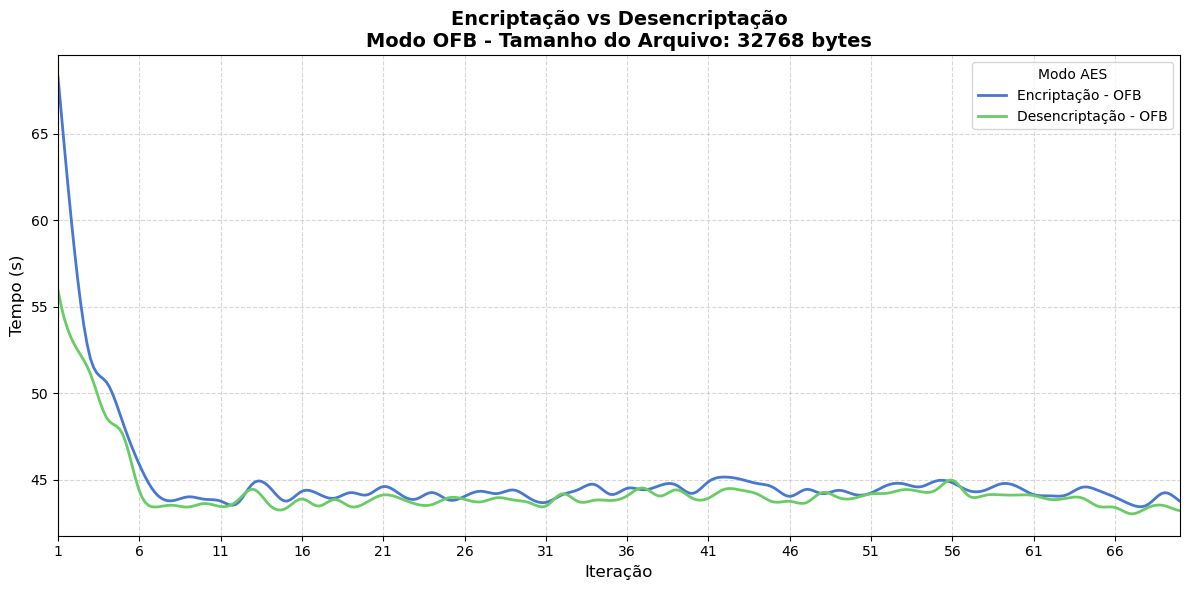

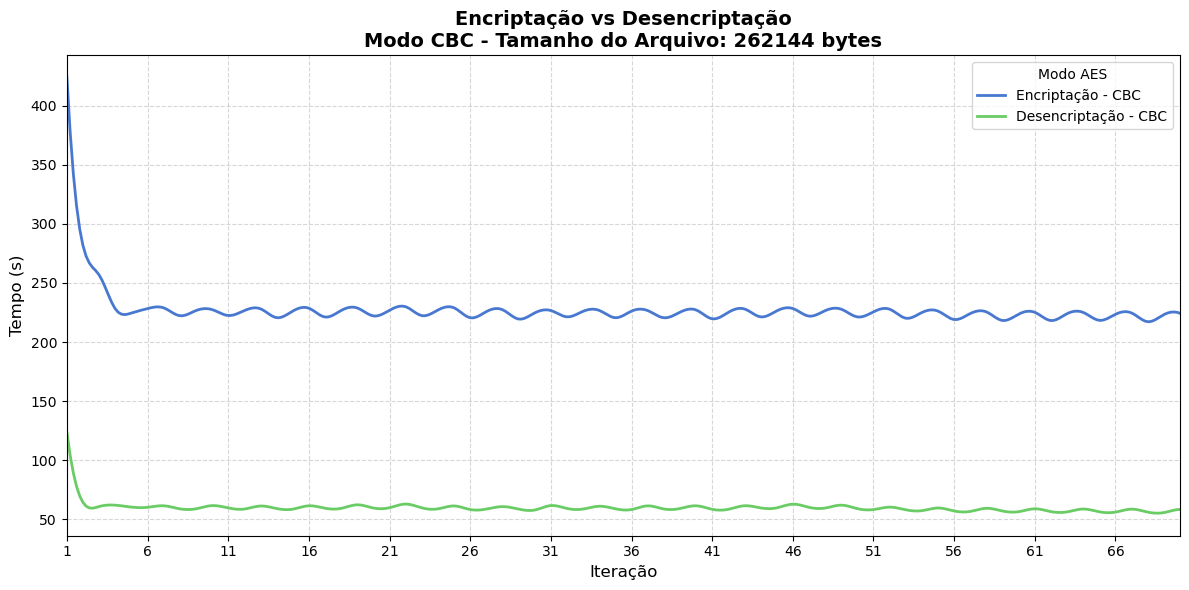

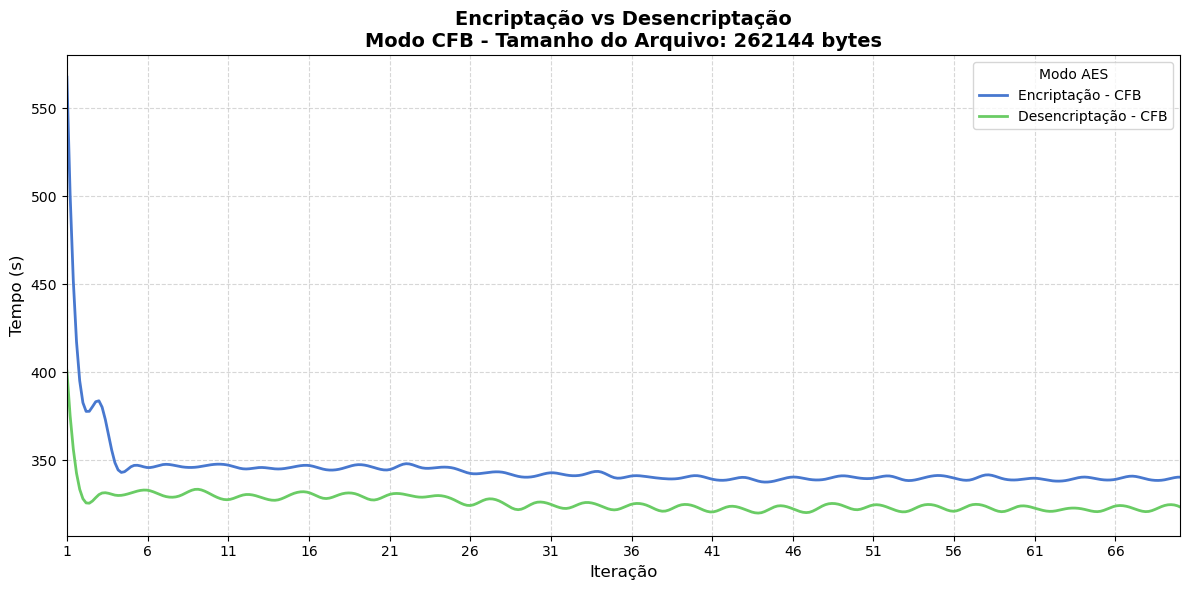

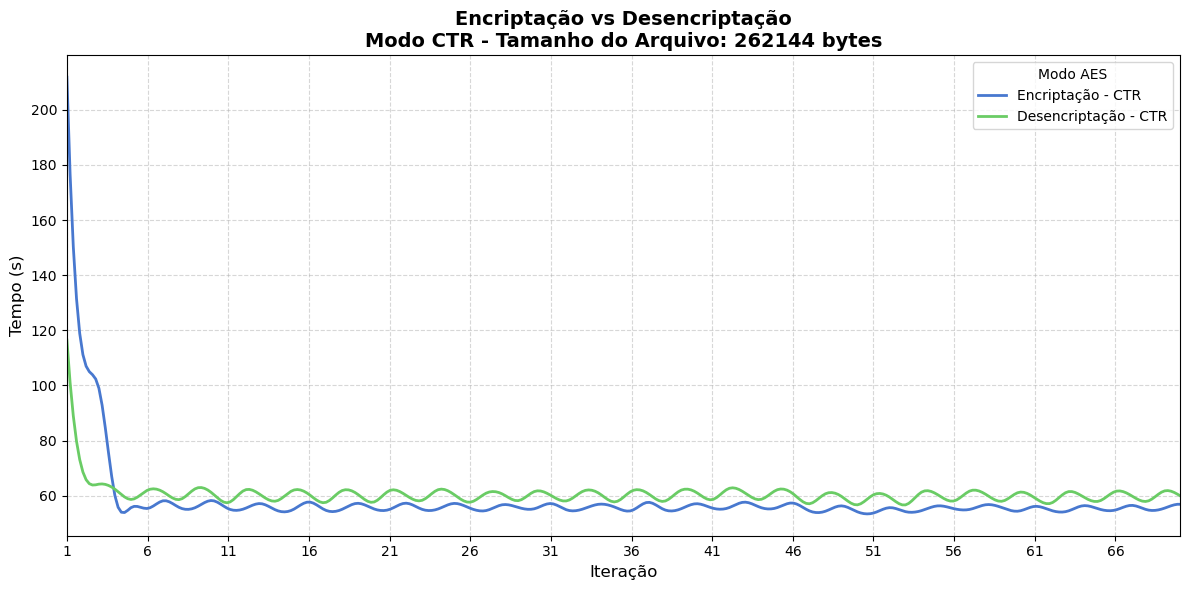

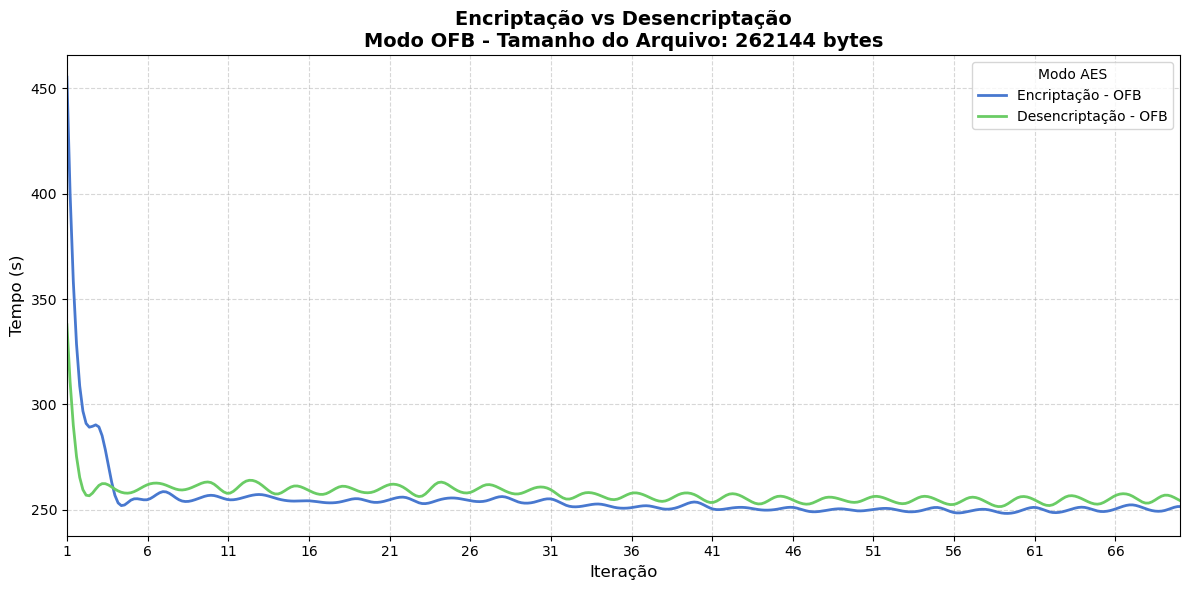

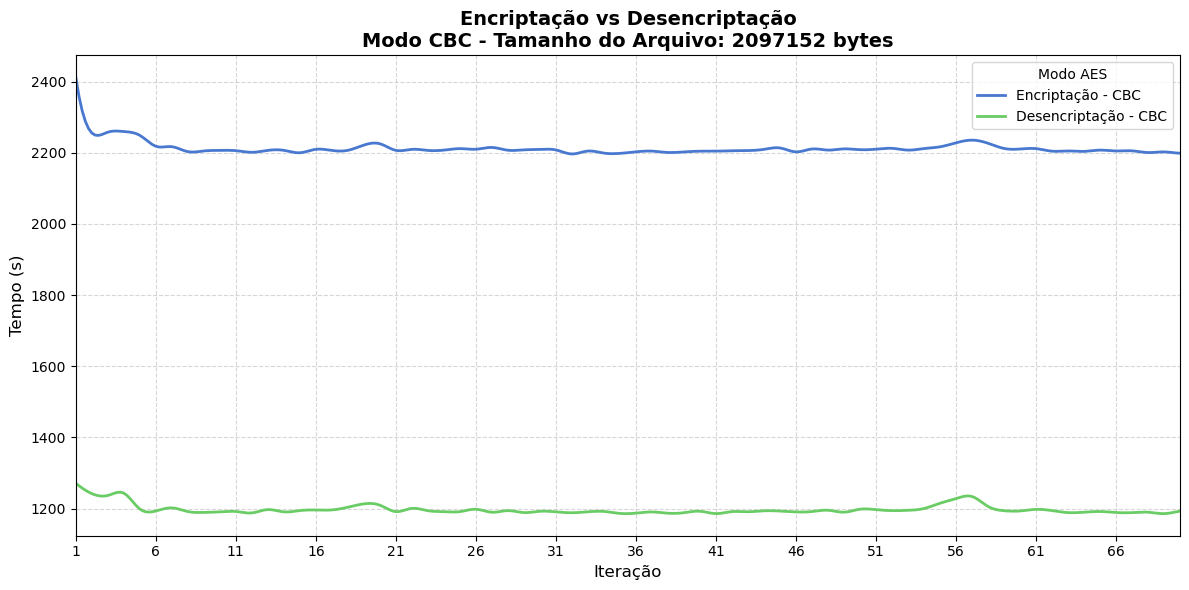

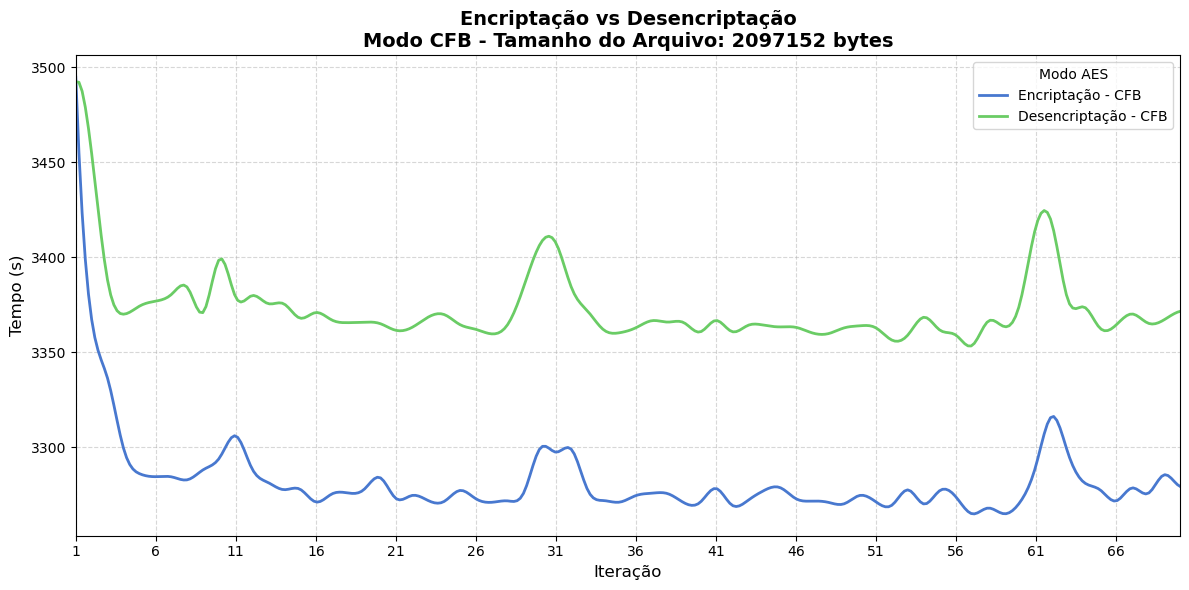

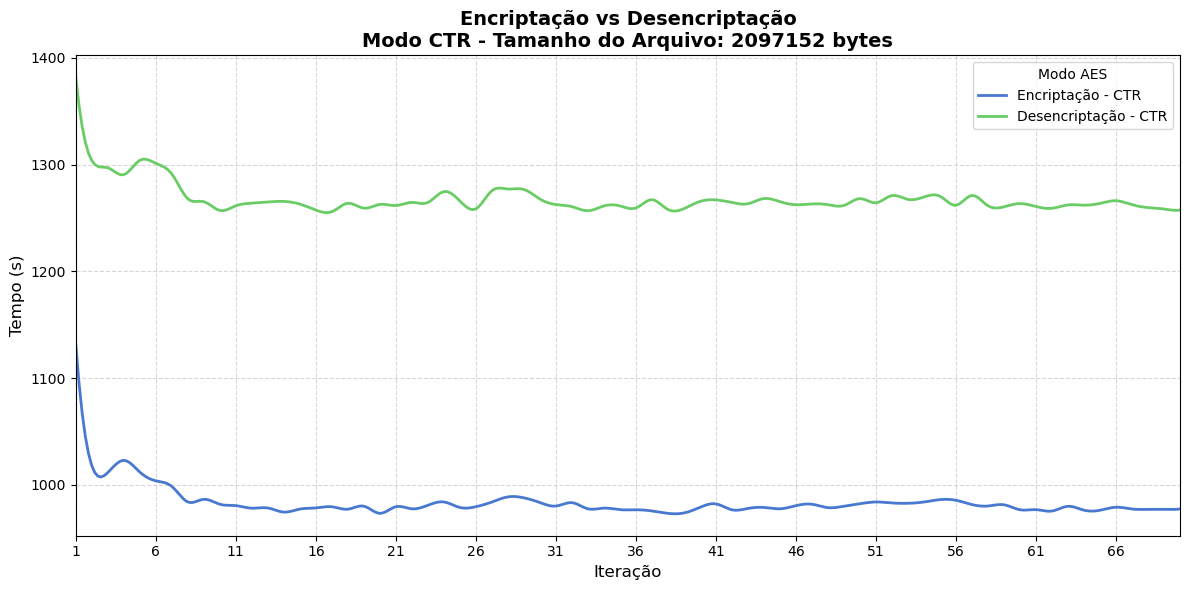

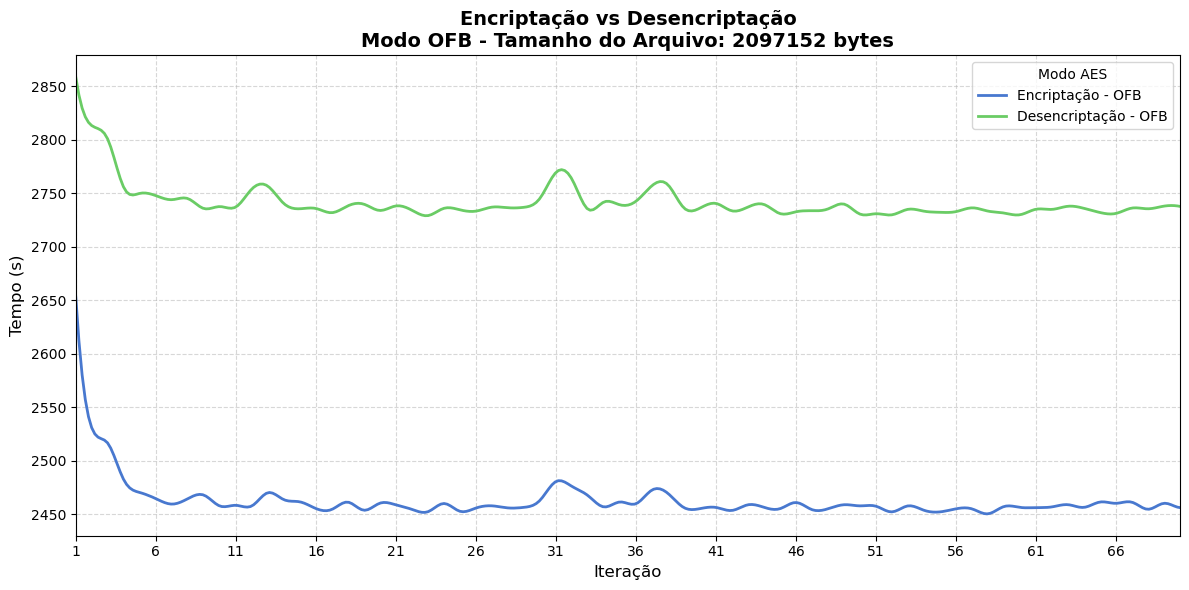

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Estilo visual
plt.style.use("seaborn-v0_8-muted")

# Pasta dos arquivos
stats_folder = "Stats"
aes_modes = ["CBC", "CFB", "CTR", "OFB"]

# Lê os CSVs
dataframes = []
for mode in aes_modes:
    file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode
        dataframes.append(df)

# Junta tudo
data = pd.concat(dataframes, ignore_index=True)

# Função para suavizar via spline
def smooth_curve(x, y, points=500):  # Aumentando a densidade de pontos
    if len(x) < 4:
        return x, y  # Não tem dados suficientes pra suavizar
    x_smooth = np.linspace(min(x), max(x), points)  # Mais pontos
    spline = make_interp_spline(x, y, k=3)  # Spline cúbica (ou mudar k=2 para quadrática)
    y_smooth = spline(x_smooth)
    return x_smooth, y_smooth

# Para cada tamanho de arquivo
file_sizes = sorted(data["File Size"].unique())

# Para cada tamanho de arquivo, cria gráficos comparando encriptação e desencriptação
for size in file_sizes:
    for mode in aes_modes:
        plt.figure(figsize=(12, 6))

        # Filtro dos dados para o tamanho de arquivo e modo de operação
        filtered = data[(data["File Size"] == size) & (data["Mode"] == mode)]
        
        # Calcula as médias de encriptação e desencriptação
        avg_enc = filtered.groupby("Iteration")["Encryption Time"].mean()
        avg_dec = filtered.groupby("Iteration")["Decryption Time"].mean()

        # Pega as iterações reais e os tempos médios
        x_enc, y_enc = avg_enc.index.values, avg_enc.values
        x_dec, y_dec = avg_dec.index.values, avg_dec.values

        # Suavização das curvas
        x_enc_smooth, y_enc_smooth = smooth_curve(x_enc, y_enc, points=500)
        x_dec_smooth, y_dec_smooth = smooth_curve(x_dec, y_dec, points=500)

        # Plotando as curvas para o tamanho de arquivo e modo de operação específicos
        plt.plot(x_enc_smooth, y_enc_smooth, label=f"Encriptação - {mode}", linewidth=2)
        plt.plot(x_dec_smooth, y_dec_smooth, label=f"Desencriptação - {mode}", linewidth=2)

        plt.title(f"Encriptação vs Desencriptação\nModo {mode} - Tamanho do Arquivo: {size} bytes", fontsize=14, weight='bold')
        plt.xlabel("Iteração", fontsize=12)
        plt.ylabel("Tempo (s)", fontsize=12)
        plt.legend(title="Modo AES")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()

        # Limita o eixo X até a iteração 70
        plt.xlim(1, 70)
        plt.xticks(np.arange(1, 71, 5))  # Marca de 5 em 5 até a iteração 70
        
        # Salva o gráfico
        #plt.savefig(os.path.join(stats_folder, f"enc_vs_dec_{mode}_size_{size}_upto70.png"), dpi=300)
        plt.show()



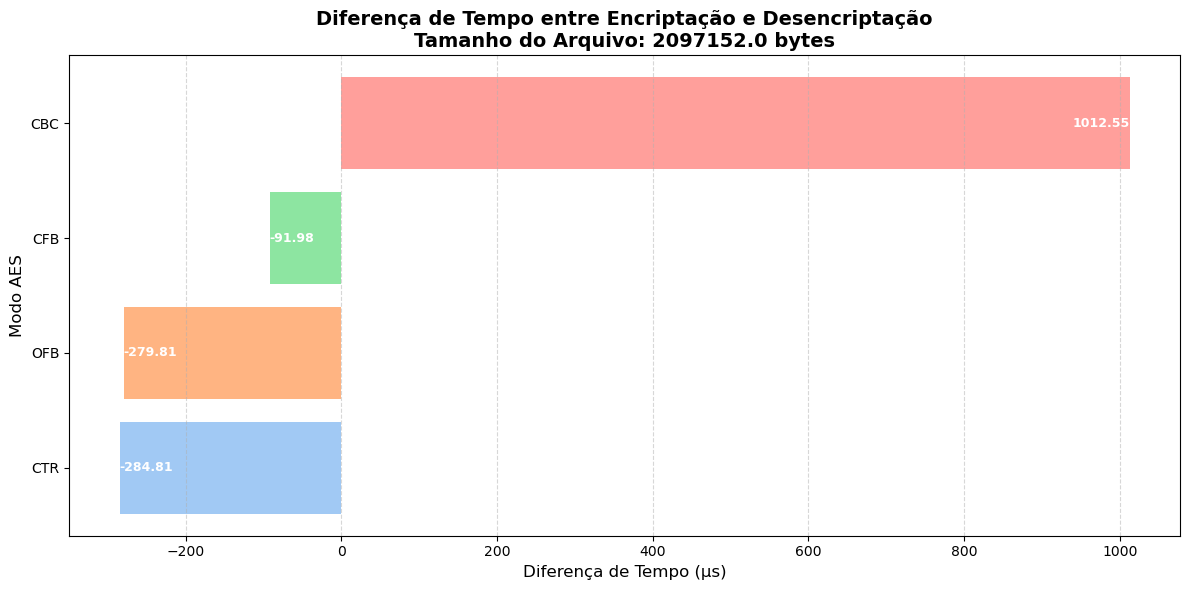

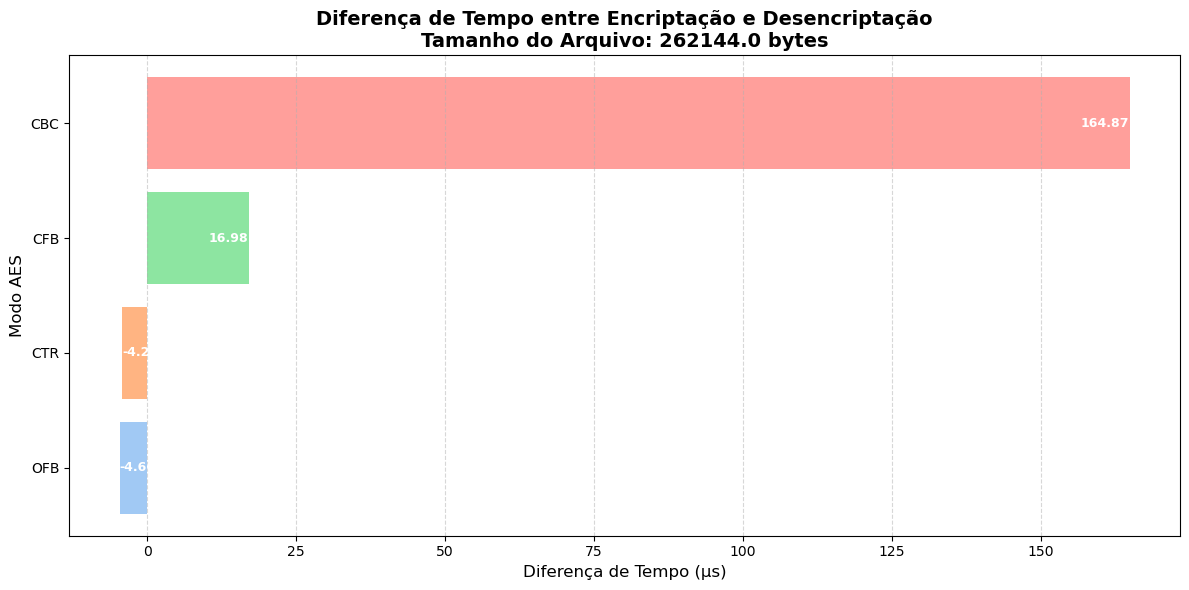

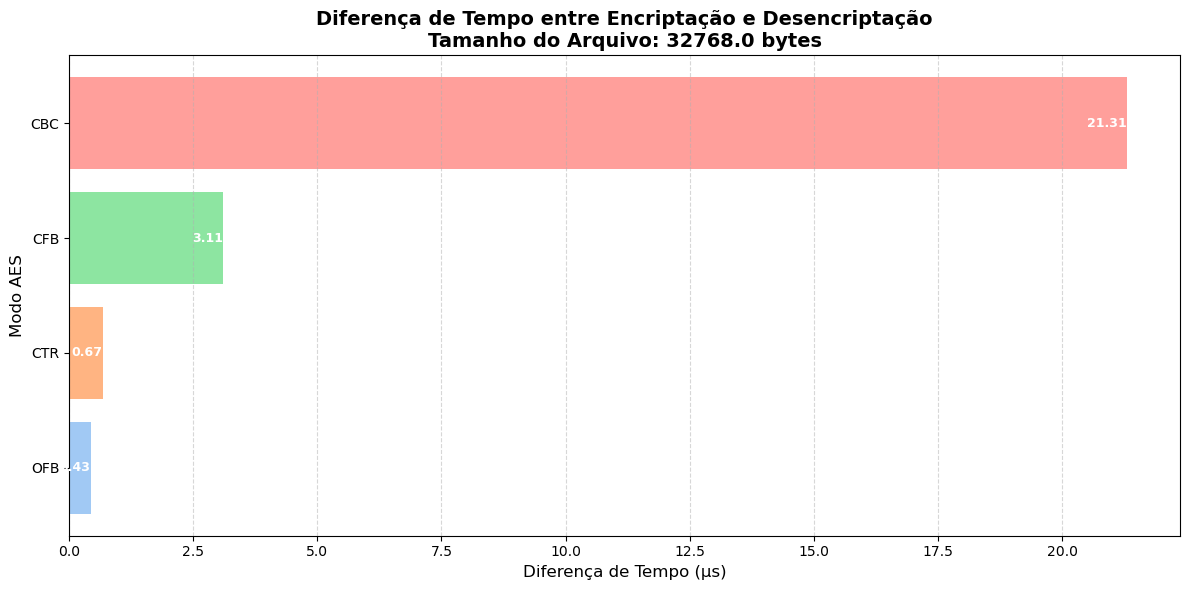

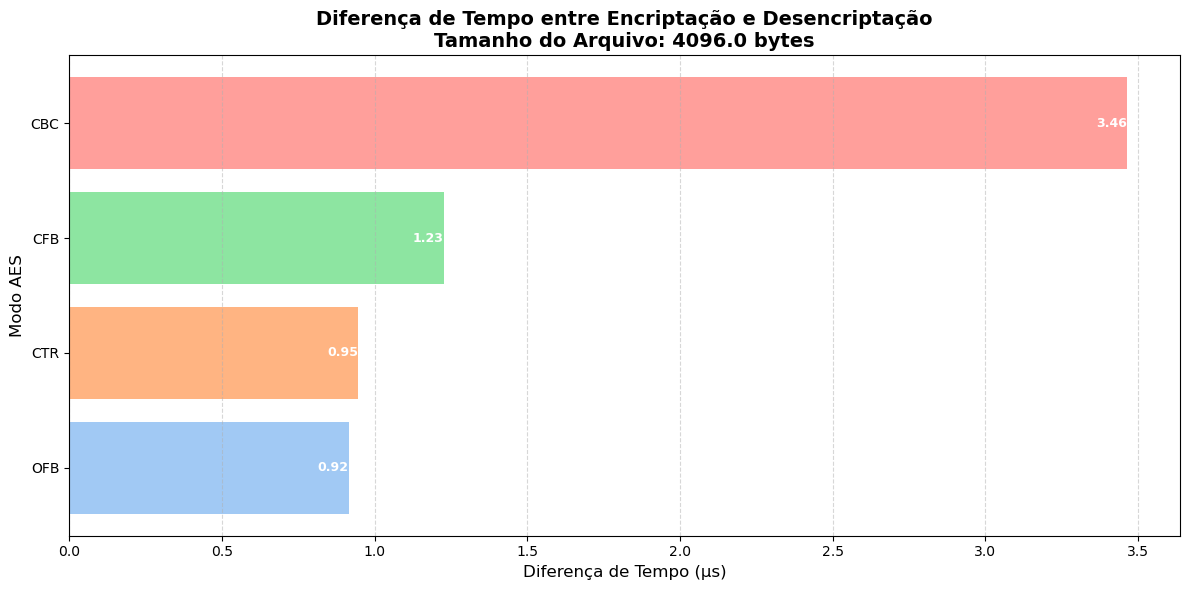

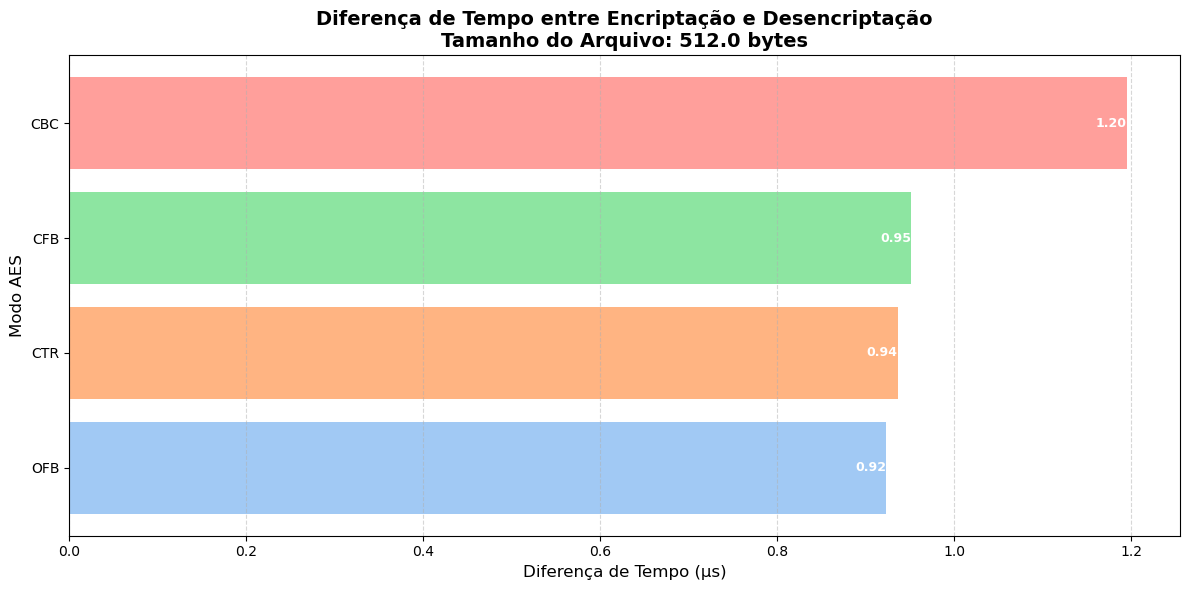

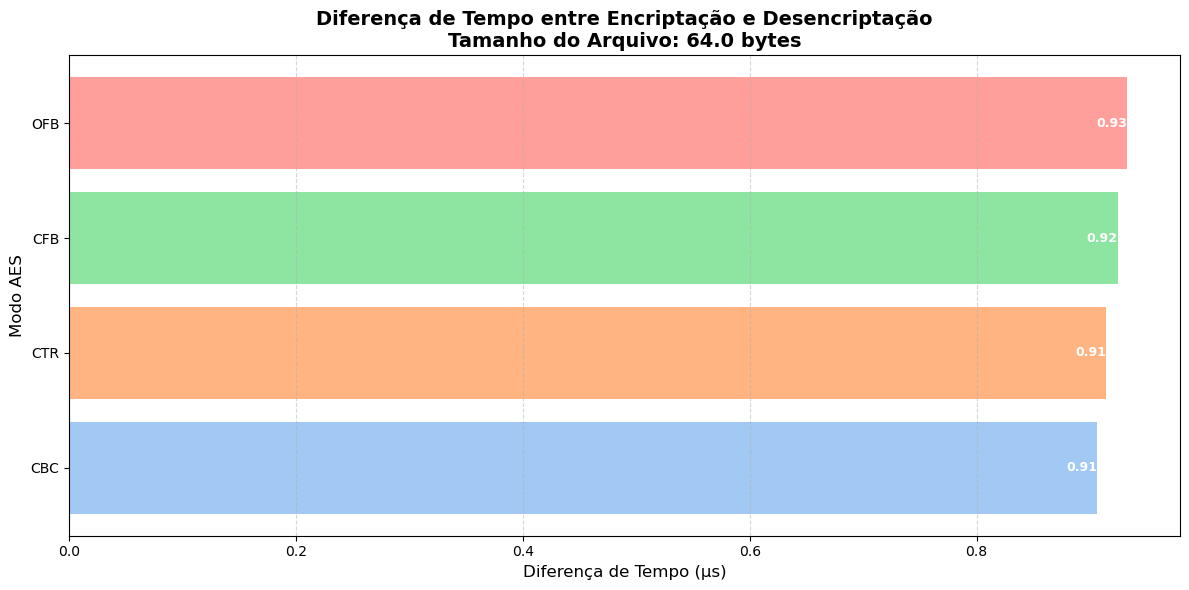

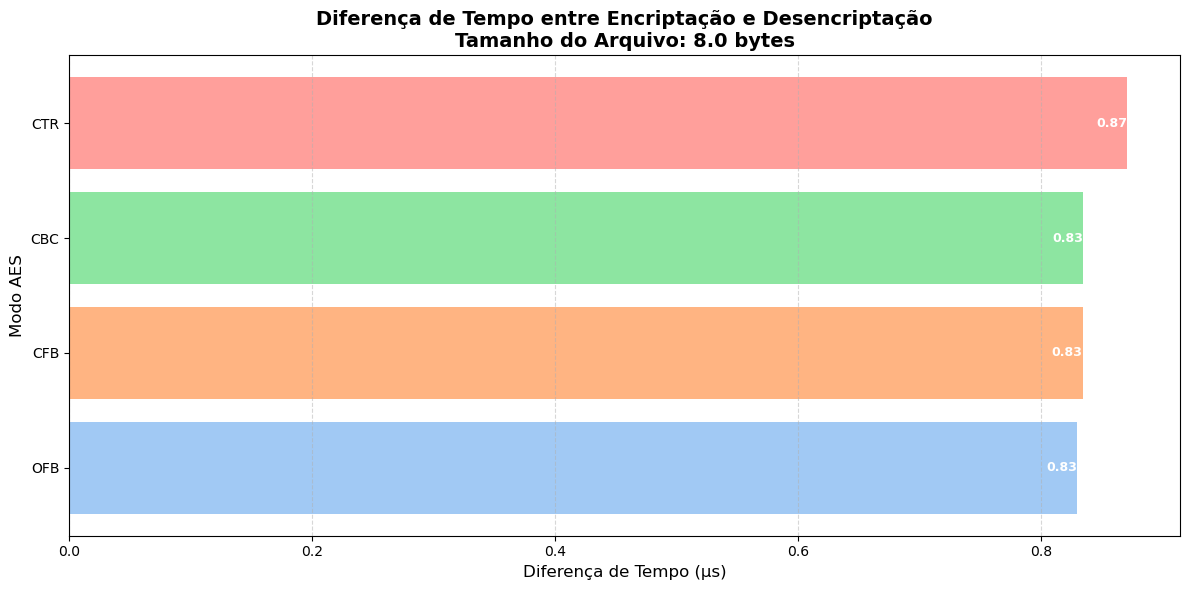

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pasta onde estão os CSVs
stats_folder = "Stats"
aes_modes = ["CBC", "CFB", "CTR", "OFB"]

# Lê todos os arquivos e adiciona o modo como coluna
dataframes = []
for mode in aes_modes:
    file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode
        dataframes.append(df)

# Junta os dados
data = pd.concat(dataframes, ignore_index=True)

# Ignora as primeiras 10 iterações
data = data[data["Iteration"] > 10]

# Pega os tamanhos de ficheiro únicos
file_sizes = data["File Size"].unique()

# Paleta de cores
colors = sns.color_palette("pastel", len(aes_modes))

# Calcula as diferenças entre tempo de encriptação e desencriptação
diff_data = []
for size in file_sizes:
    for mode in aes_modes:
        mode_data = data[(data["File Size"] == size) & (data["Mode"] == mode)]
        mean_enc = mode_data["Encryption Time"].mean()
        mean_dec = mode_data["Decryption Time"].mean()
        diff = mean_enc - mean_dec
        diff_data.append({"File Size": size, "Mode": mode, "Diff": diff})

diff_df = pd.DataFrame(diff_data)

# Gera gráficos por tamanho de ficheiro
for size in file_sizes:
    plt.figure(figsize=(12, 6))
    size_data = diff_df[diff_df["File Size"] == size].sort_values(by="Diff", ascending=True)
    bars = plt.barh(size_data["Mode"], size_data["Diff"], color=colors)

    offset = size_data["Diff"].abs().max() * 0.0001  # espaço para alinhar dentro da barra

    for bar in bars:
        width = bar.get_width()
        label = f"{width:.2f}"
        y = bar.get_y() + bar.get_height() / 2
        # Alinhamento e posição interna da barra
        if width >= 0:
            plt.text(width - offset, y, label, va="center", ha="right", fontsize=9, color="white", fontweight="bold")
        else:
            plt.text(width + offset, y, label, va="center", ha="left", fontsize=9, color="white", fontweight="bold")

    plt.title(f"Diferença de Tempo entre Encriptação e Desencriptação\nTamanho do Arquivo: {size:.1f} bytes",
              fontsize=14, weight='bold')
    plt.xlabel("Diferença de Tempo (µs)", fontsize=12)
    plt.ylabel("Modo AES", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


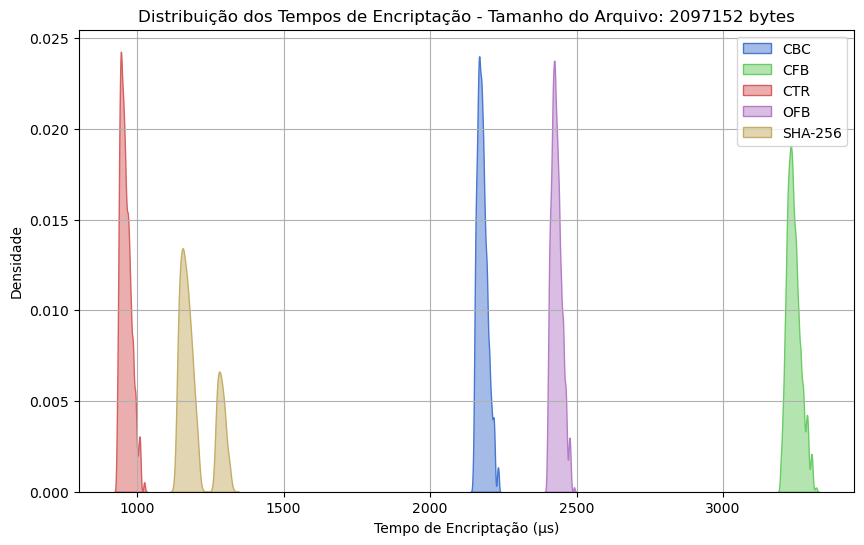

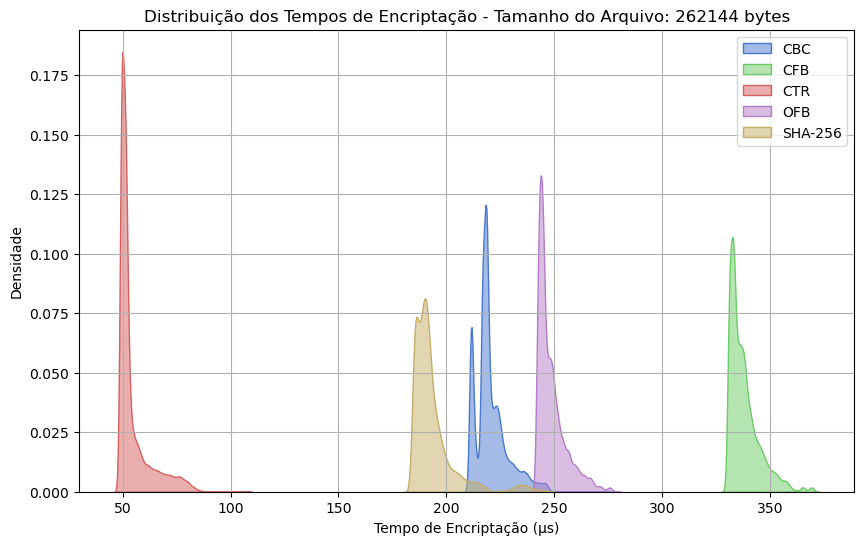

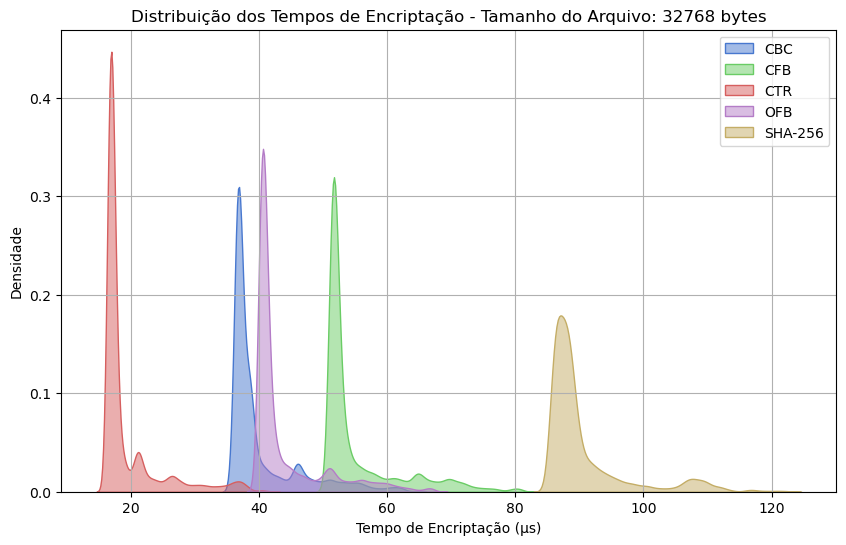

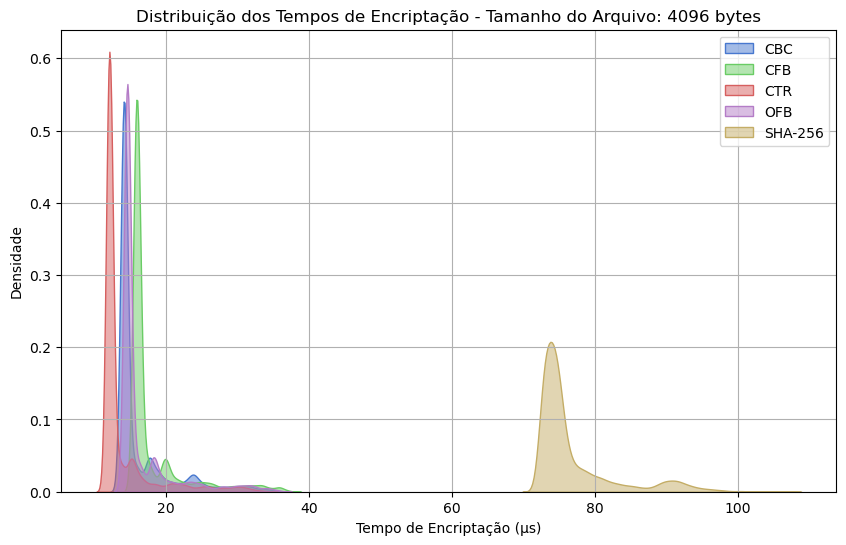

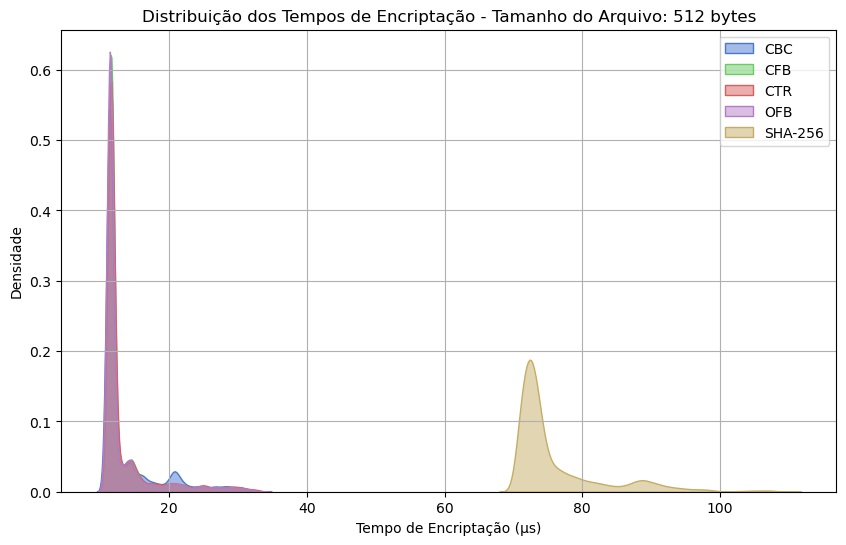

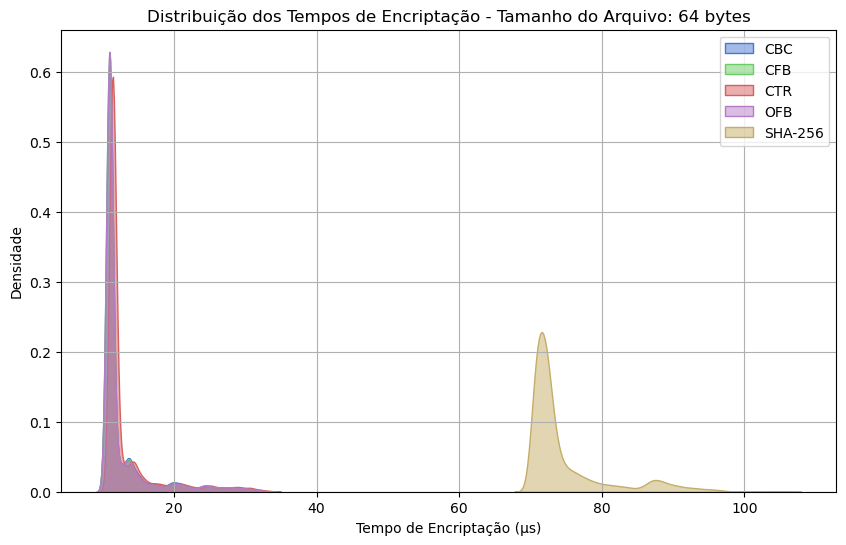

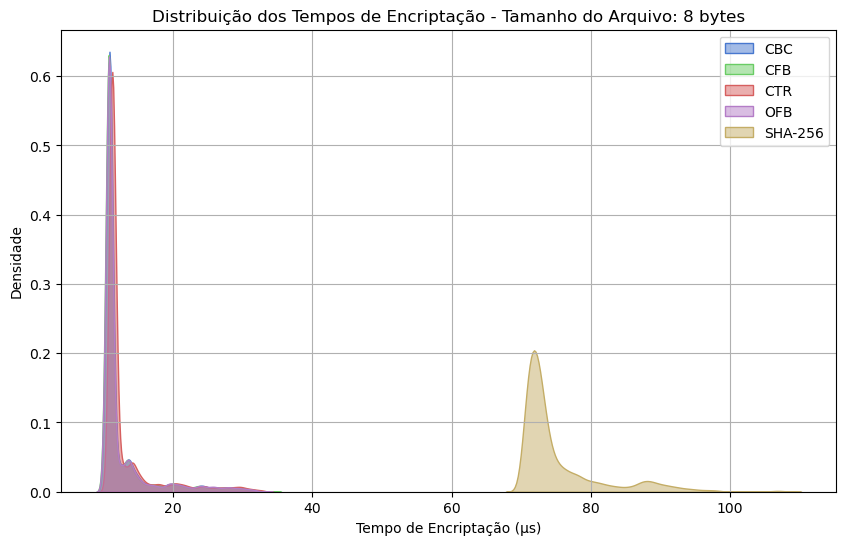

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pasta onde estão os arquivos CSV
stats_folder = "Stats"

# Modos de AES
aes_modes = ["CBC", "CFB", "CTR", "OFB","SHA-256"]

# Lê todos os arquivos CSV e combina os dados
dataframes = []
for mode in aes_modes:
    if mode == "SHA-256":
        file_path = os.path.join(stats_folder, f"sha256_benchmarks.csv")
    else: file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode  # Adiciona uma coluna para identificar o modo
        dataframes.append(df)

# Combina todos os DataFrames em um único
data = pd.concat(dataframes, ignore_index=True)

# Lista de tamanhos de arquivos
file_sizes = data["File Size"].unique()

# Cria um gráfico de distribuição para cada tamanho de arquivo
for size in file_sizes:
    plt.figure(figsize=(10, 6))
    for mode in aes_modes:
        # Filtra os dados pelo tamanho do arquivo e pelo modo
        mode_data = data[(data["File Size"] == size) & (data["Mode"] == mode)]
        encryption_times = mode_data["Encryption Time"]

        # Conta a frequência de cada tempo de encriptação
        value_counts = encryption_times.value_counts()

        # Filtra apenas os tempos com mais de 50 amostras
        valid_times = value_counts[value_counts > 20].index
        filtered_data = encryption_times[encryption_times.isin(valid_times)]

        # Plota a distribuição dos tempos de encriptação usando KDE
        sns.kdeplot(filtered_data, label=mode, fill=True, alpha=0.5)

    # Configurações do gráfico
    plt.title(f"Distribuição dos Tempos de Encriptação - Tamanho do Arquivo: {size} bytes")
    plt.xlabel("Tempo de Encriptação (µs)")
    plt.ylabel("Densidade")
    plt.legend()
    plt.grid(True)

    # Salva o gráfico como imagem
    output_path = os.path.join(stats_folder, f"encryption_distribution_{size}.png")
    #plt.savefig(output_path)
    plt.show()


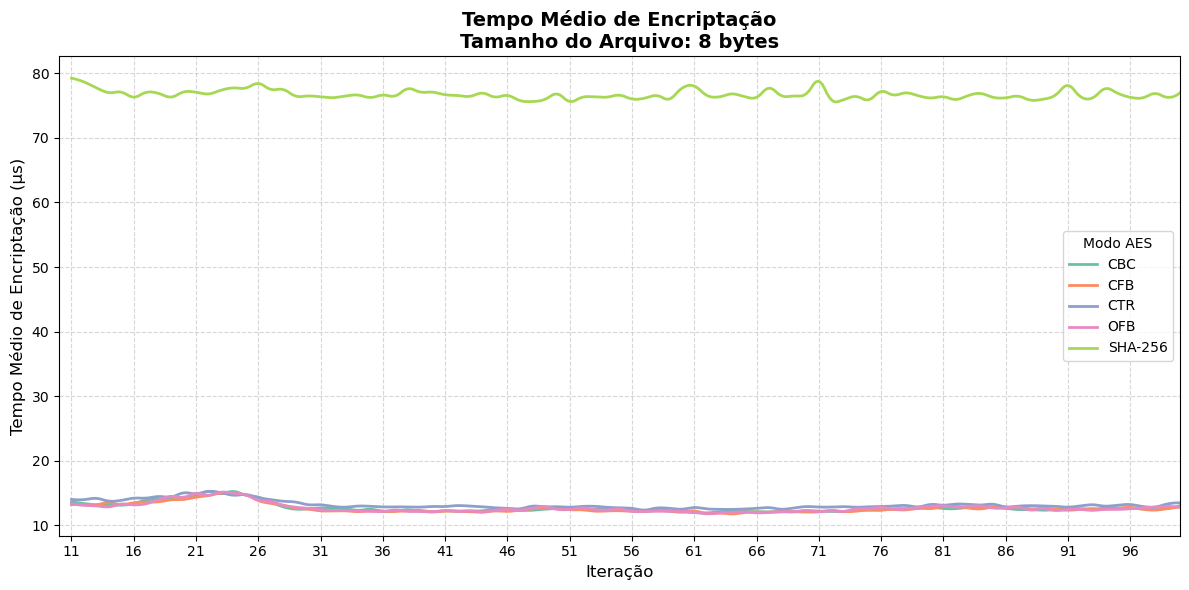

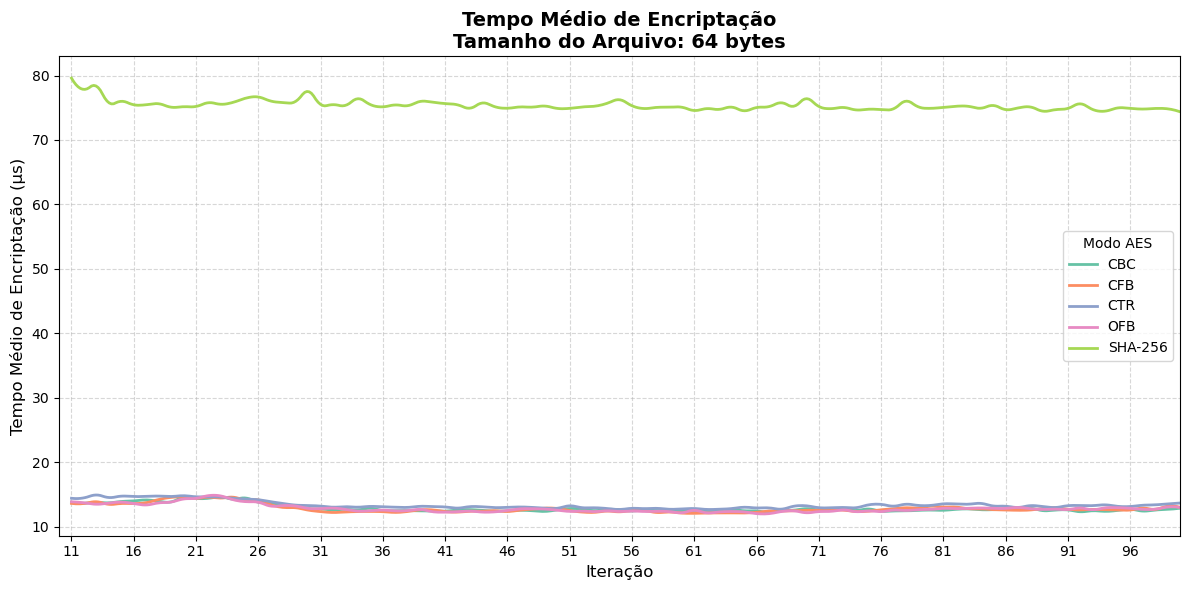

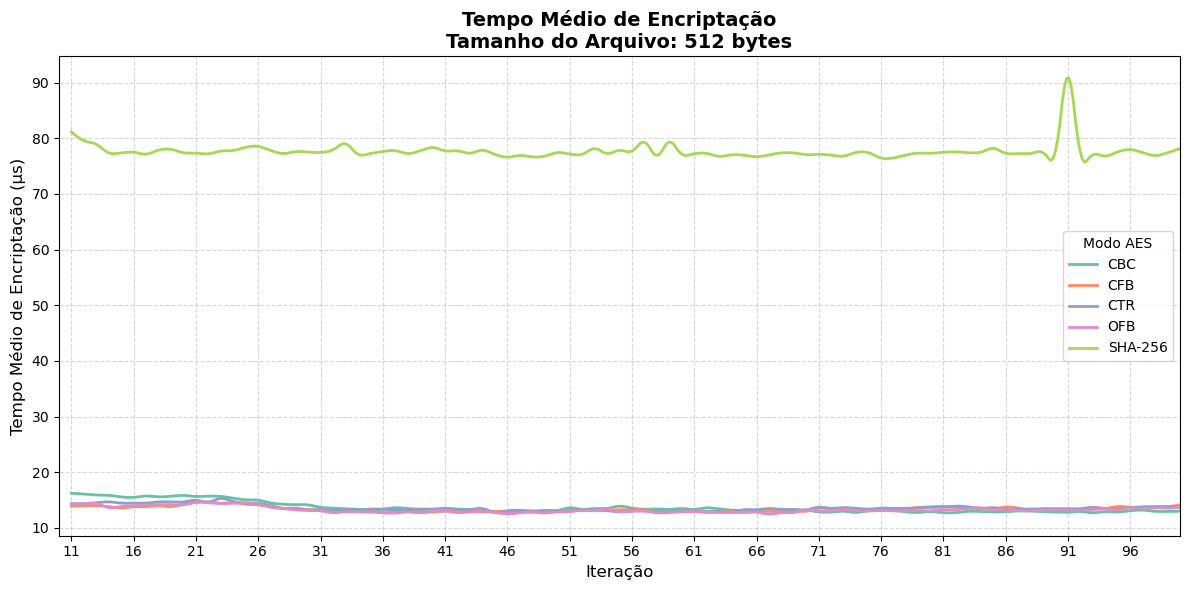

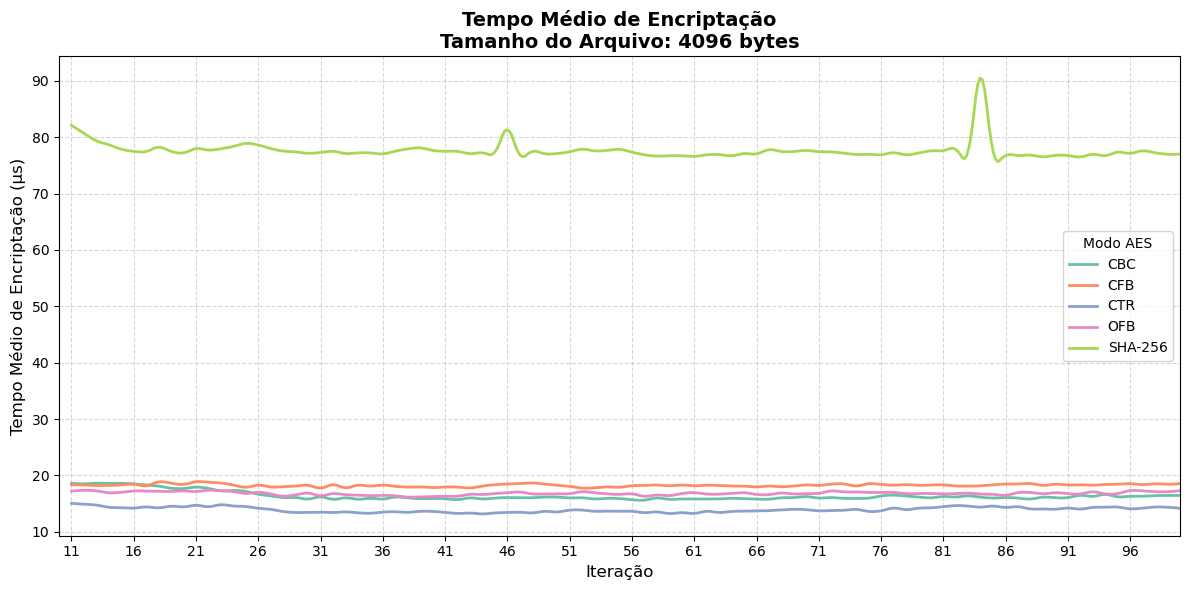

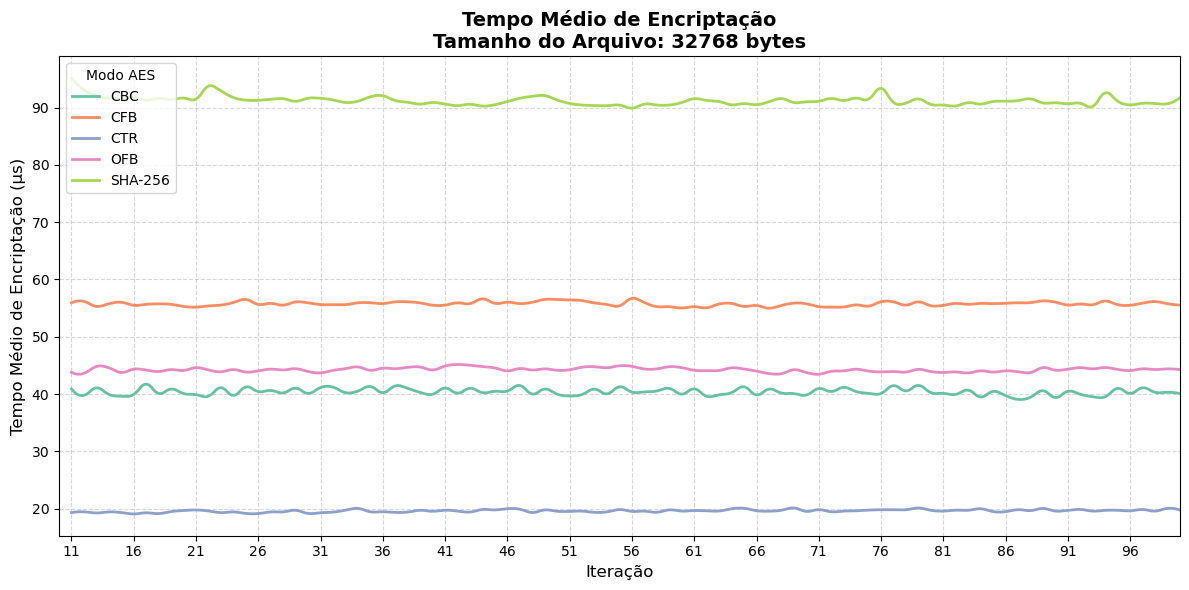

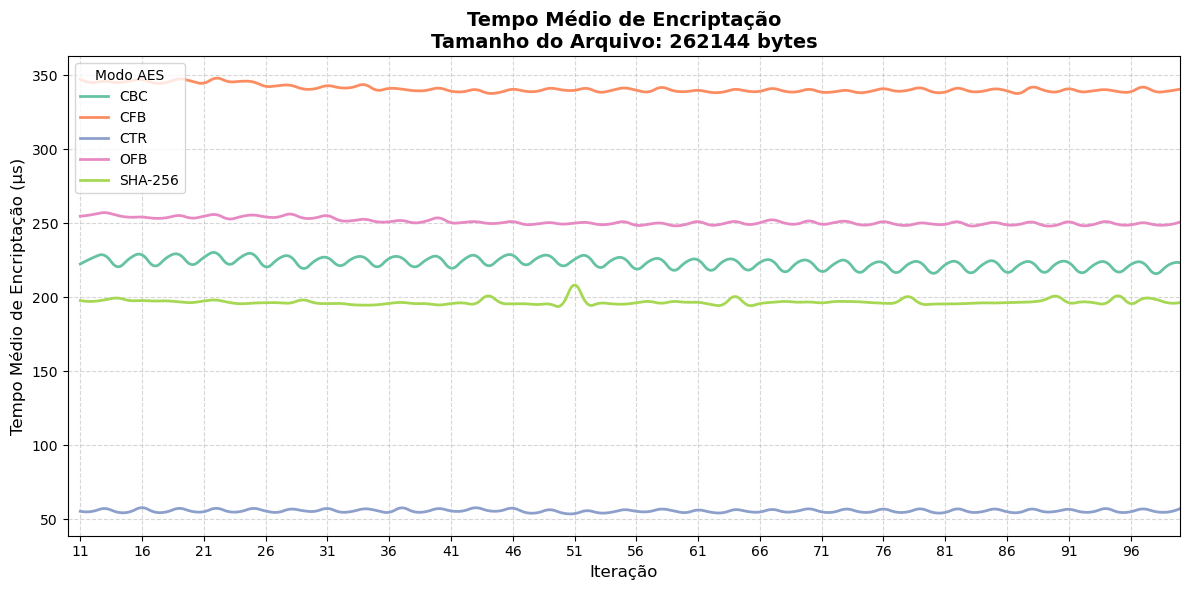

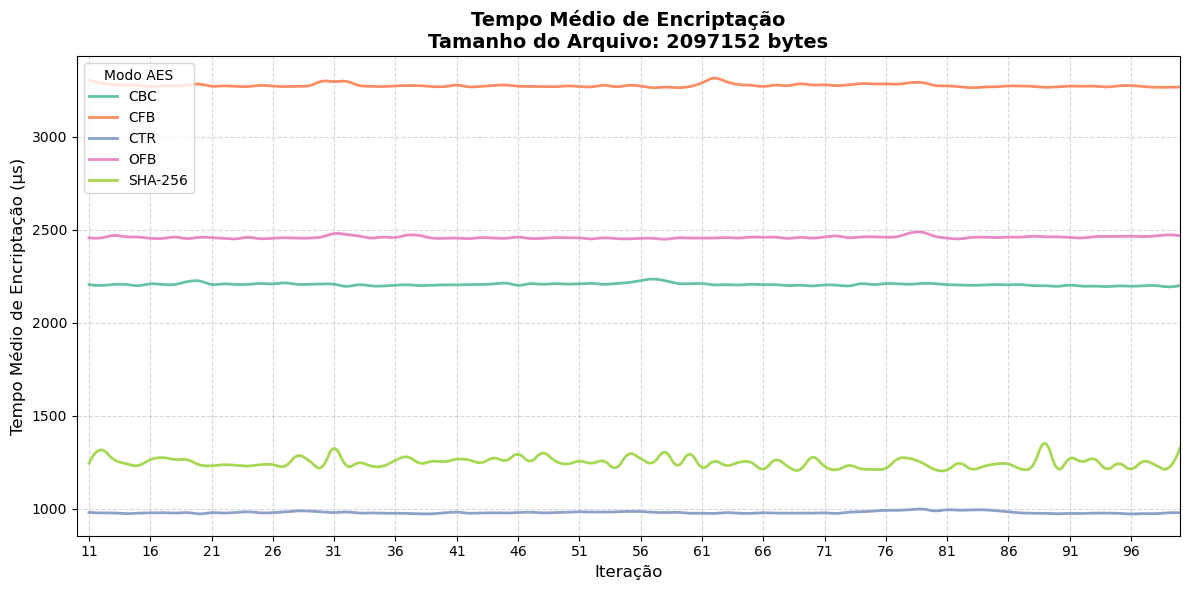

'    plt.figure(figsize=(12,6))\n    for mode, color in zip(aes_modes, colors):\n        if mode == "SHA-256":\n            continue\n        filtered = data[(data["Mode"] == mode) & (data["File Size"] == size)]\n        avg_dec = filtered.groupby("Iteration")["Decryption Time"].mean()\n\n        # Pega as iterações reais e os tempos médios\n        x, y = avg_dec.index.values, avg_dec.values\n        x_smooth, y_smooth = smooth_curve(x, y, points=500)  # Aumentando densidade\n        plt.plot(x_smooth, y_smooth, label=mode, linewidth=2, color=color)\n\n    plt.title(f"Tempo Médio de Desencriptação\nTamanho do Arquivo: {size} bytes", fontsize=14, weight=\'bold\')\n    plt.xlabel("Iteração", fontsize=12)\n    plt.ylabel("Tempo Médio de Desencriptação (µs)", fontsize=12)\n    plt.legend(title="Modo AES")\n    plt.grid(True, linestyle=\'--\', alpha=0.5)\n    plt.tight_layout()\n    plt.xticks(np.arange(0, 101, 5))  # Marca cada 5 iterações (de 1 a 100)\n    #plt.savefig(os.path.join(stats

In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import numpy as np

# Estilo visual
# Pasta onde estão os arquivos CSV
stats_folder = "Stats"

# Modos de AES
aes_modes = ["CBC", "CFB", "CTR", "OFB","SHA-256"]

# Lê todos os arquivos CSV e combina os dados
dataframes = []
for mode in aes_modes:
    if mode == "SHA-256":
        file_path = os.path.join(stats_folder, f"sha256_benchmarks.csv")
    else: file_path = os.path.join(stats_folder, f"AES-256-{mode}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Mode"] = mode  # Adiciona uma coluna para identificar o modo
        dataframes.append(df)

# Combina todos os DataFrames em um único
data = pd.concat(dataframes, ignore_index=True)

# Ignora as primeiras 10 iterações
data = data[data["Iteration"] > 10]
# Tamanhos únicos
file_sizes = sorted(data["File Size"].unique())
colors = sns.color_palette("Set2", len(aes_modes))

# Função para suavizar via spline
def smooth_curve(x, y, points=500):  # Aumentando a densidade de pontos
    x_smooth = np.linspace(min(x), max(x), points)  # Mais pontos
    spline = make_interp_spline(x, y, k=2)  # Spline cúbica (ou mudar k=2 para quadrática)
    y_smooth = spline(x_smooth)
    return x_smooth, y_smooth

# Para cada tamanho de ficheiro
for size in file_sizes:
    # --- Encriptação ---
    plt.figure(figsize=(12, 6))
    for mode, color in zip(aes_modes, colors):
        filtered = data[(data["Mode"] == mode) & (data["File Size"] == size)]
        avg_enc = filtered.groupby("Iteration")["Encryption Time"].mean()

        # Pega as iterações reais e os tempos médios
        x, y = avg_enc.index.values, avg_enc.values
        x_smooth, y_smooth = smooth_curve(x, y, points=500)  # Aumentando densidade
        plt.plot(x_smooth, y_smooth, label=mode, linewidth=2, color=color)

    plt.title(f"Tempo Médio de Encriptação\nTamanho do Arquivo: {size} bytes", fontsize=14, weight='bold')
    plt.xlabel("Iteração", fontsize=12)
    plt.ylabel("Tempo Médio de Encriptação (µs)", fontsize=12)
    plt.legend(title="Modo AES")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(np.arange(1, 101, 5))  # Marca cada 5 iterações (de 1 a 100)
    plt.xlim(10, 100)  # Limita o eixo X até a iteração 100
    #plt.savefig(os.path.join(stats_folder, f"smooth_enc_time_iter_{size}.png"), dpi=300)
    plt.show()

    # --- Desencriptação ---
'''    plt.figure(figsize=(12,6))
    for mode, color in zip(aes_modes, colors):
        if mode == "SHA-256":
            continue
        filtered = data[(data["Mode"] == mode) & (data["File Size"] == size)]
        avg_dec = filtered.groupby("Iteration")["Decryption Time"].mean()

        # Pega as iterações reais e os tempos médios
        x, y = avg_dec.index.values, avg_dec.values
        x_smooth, y_smooth = smooth_curve(x, y, points=500)  # Aumentando densidade
        plt.plot(x_smooth, y_smooth, label=mode, linewidth=2, color=color)

    plt.title(f"Tempo Médio de Desencriptação\nTamanho do Arquivo: {size} bytes", fontsize=14, weight='bold')
    plt.xlabel("Iteração", fontsize=12)
    plt.ylabel("Tempo Médio de Desencriptação (µs)", fontsize=12)
    plt.legend(title="Modo AES")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(np.arange(0, 101, 5))  # Marca cada 5 iterações (de 1 a 100)
    #plt.savefig(os.path.join(stats_folder, f"smooth_dec_time_iter_{size}.png"), dpi=300)
    plt.show()
'''
